# Purpose and plan

In this project, I will attempt to estimate the height of an individual based on their weight, gender, and BMI. I will implement Keras for the machine learning part of this assignment, and use Pandas and Matplotlib for data explotation. I know that the BMI of a person is calculated with height and weight, so I'm hoping that this model will ferrit out the relationship, (BMI = Kg/M^2,) and be able to accuractly predict height.

# Setup

First, I'll import all needed libraries, and set things up so that this project should run smoothly on as many machines as possible. We also want to plot figures inline, so I'll use the built in Jupyter-Notebook magic for that.

In [1]:
# make sure we can support Python 2
from __future__ import division, print_function, unicode_literals

# import our necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import keras
import os

# Plot figures in the notebook with Jupyter-Notebook magic
%matplotlib inline

# give everything a random seed so that we get repeatable results.
seed_value= 42

os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

Using TensorFlow backend.


Time to import data from our CSV file! The file is named "HeightWeightData.csv," nd is stored in the same directory as this notebook. 

In [2]:
# create paths for the loading of data, saving of models, and the saving of images.
DATA_PATH = "./HeightWeightData.csv"

if not os.path.exists("Figures"):
    os.makedirs("Figures")

if not os.path.exists("Models"):
    os.makedirs("Models")    
    
FIGURE_PATH = "./Figures/"

# Exploring and visualizing the data:

Based on the online description of the dataset, the data should be structured as follows:

    Gender : Male / Female

    Height : Number (cm)

    Weight : Number (Kg)

    Index :

        0 - Extremely Weak

        1 - Weak

        2 - Normal

        3 - Overweight

        4 - Obesity

        5 - Extreme Obesity
        
Now, just to make sure that there are no surprises, let's check out the data after importing it into a pandas DataFrame: 

In [3]:
data = pd.read_csv(DATA_PATH)

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
Gender    500 non-null object
Height    500 non-null int64
Weight    500 non-null int64
Index     500 non-null int64
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


Height      Weight       Index
count  500.000000  500.000000  500.000000
mean   169.944000  106.000000    3.748000
std     16.375261   32.382607    1.355053
min    140.000000   50.000000    0.000000
25%    156.000000   80.000000    3.000000
50%    170.500000  106.000000    4.000000
75%    184.000000  136.000000    5.000000
max    199.000000  160.000000    5.000000

There is a single categorical data column to deal with. Let's explore what it contains, and in what amounts:

In [4]:
print(data["Gender"].value_counts())

Female    255
Male      245
Name: Gender, dtype: int64


Now we'll get some more information on how non-categorical features are spread out with the handy pandas hist() method.

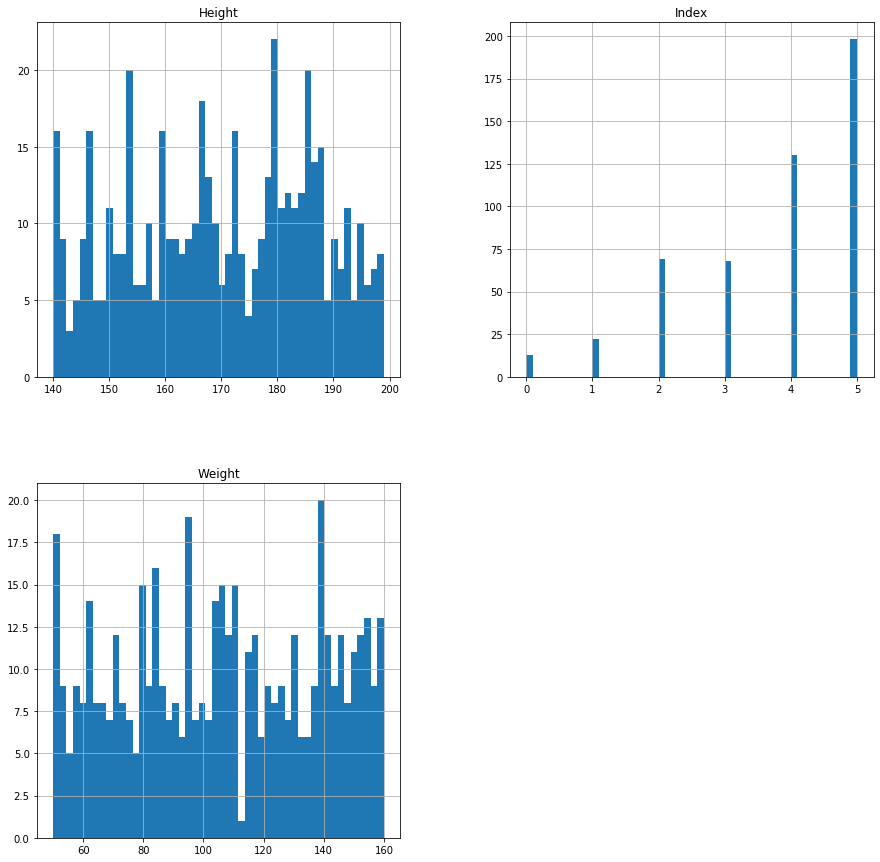

In [5]:
data.hist(bins=50, figsize = [15, 15])
plt.show()

Because the hist() mehtod ignores categorical data, I'll just grab the value_counts of each variable in the "Gender" column, and plot those so that we have all variables visualized.

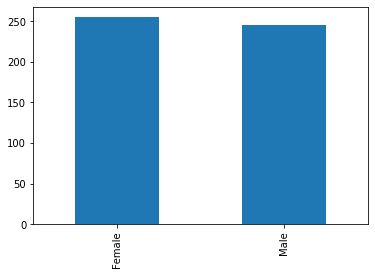

In [6]:
data["Gender"].value_counts().plot(kind="bar")#can't hist() on categorical.
plt.show()

What I've noticed so far is:

1) The data has buit in ratios. There are more females than males in the data, and there are a lot more people in the BMI "5" range than the other ranges. This will require some stratified splitting later if we want to avoid random sampling bias in the training/test sets.

2) There appears to be an obvious relationship between weight and height. I think the reason that the histogram for height and the histogram for weight are jumpy is the fact that there are only 500 instances in this set. I'm definately seeing parallels between the amount of people in a certain range of height, and the amount of people in a certain range of weight. If there were more instances, I think we'd see a much smoother top to the graph. (That smoothness doesn't have to be a straight line, of course.)

I'll continue with a scatter matrix and correlation matrix:

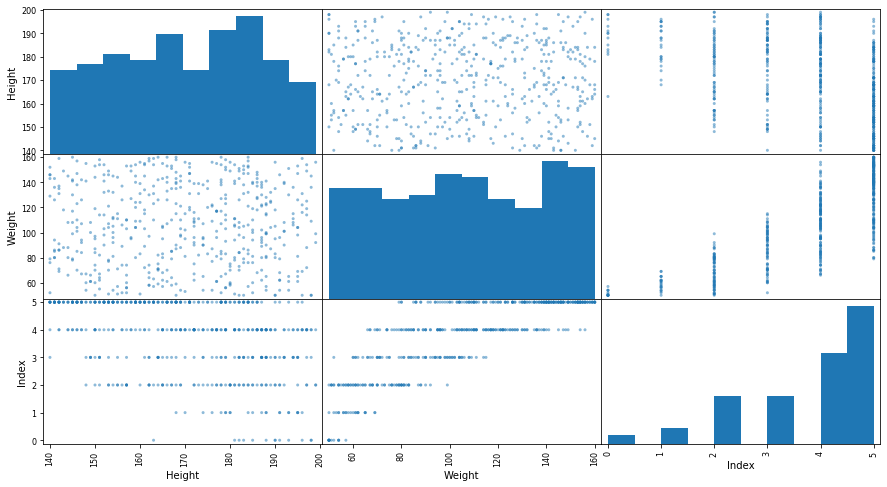


          Height    Weight     Index
Height  1.000000  0.000446 -0.422223
Weight  0.000446  1.000000  0.804569
Index  -0.422223  0.804569  1.000000


In [7]:
from pandas.plotting import scatter_matrix

scatter_matrix(data, figsize=[15,8])
plt.show()

print("")
corr_matrix = data.corr()
print(corr_matrix)

Well after the scatter matrix and correlation matrix, I can tell that my previous assumptions about height and weight were incorrect. The relationship between height and weight is pretty much nothing. However, because BMI links the two with an equation, I am hoping that I can get my model to discover that relationship, and reverse-engineer it, so that it can accurately predict height. I'm hoping that I don't have to add another feature like (Weight/Height) to give the model any hints.

# Process the data for machine learning:
As I mentioned previousely, we will need to be carefule when splitting up the data. I need the test/train matrices of features, (Index, Gender, and Weight,) and labels, (Height.) I also need to come up with a way to deal with the categorical data. This means that the first order of business is to throw the "Gender" column into a one-hot encoder in order to avoid the problems of false correlation that an ordinal encoder would cause.

In [8]:
temp_genders = pd.get_dummies(data["Gender"], prefix="Gender")
data = data.drop(["Gender"], axis=1)
data["Gender_Male"] = temp_genders["Gender_Male"]
data["Gender_Female"] = temp_genders["Gender_Female"]

I'll be doing stratified splitting of the data based around the "Index" feature, because it has the most variance, and I think it will have more effect than something like "Gender" in which the spread is fairly even. The docs for scikit-learn say that the y parameter in the StratifiedShuffleSplit method is supposed to be the target variable in the data, so I guess this is a bit of an experiment.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42) 
for train_index, test_index in split.split(data, data["Index"]):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]
    
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.11, random_state=42) 
for train_index, valid_index in split2.split(train_set, train_set["Index"]):
    train_set = data.loc[train_index]
    valid_set = data.loc[valid_index]

Now that I've split the data up, I'd like to make sure that everything worked out. I'll make a get_dataframe_info() method to check out the shape and 'head' of a data subset, and I'll create some histograms to compare the 'Index' columns' spread between the different data sets.

In [10]:
def get_dataframe_info(dframe, name):
    print("---------------------------------")
    print(name)
    print("")
    print("shape: " + str(np.shape(dframe)))
    print("")
    print(dframe.head())
    print("")

In [11]:
def get_array_info(array, name):
    print("------------------------")
    print(name + ":")
    print("")
    print("shape : " + str(np.shape(array)))
    print("")
    print("first 5 rows:")
    print(array[:5])
    print("")

In [12]:
#make sure everything went smoothly with the splitting:    
get_dataframe_info(train_set, "train_set")
get_dataframe_info(test_set, "test_set")
get_dataframe_info(valid_set, "valid_set")

---------------------------------
train_set

shape: (400, 5)

     Height  Weight  Index  Gender_Male  Gender_Female
147     140     146      5            0              1
377     178     142      5            1              0
105     195     126      4            1              0
7       154     111      5            1              0
179     188     100      3            1              0

---------------------------------
test_set

shape: (50, 5)

     Height  Weight  Index  Gender_Male  Gender_Female
201     179      93      3            1              0
383     151     154      5            1              0
382     177     117      4            1              0
159     181     105      4            1              0
390     167      58      2            0              1

---------------------------------
valid_set

shape: (50, 5)

     Height  Weight  Index  Gender_Male  Gender_Female
449     159     145      5            1              0
155     179     103      4            0      

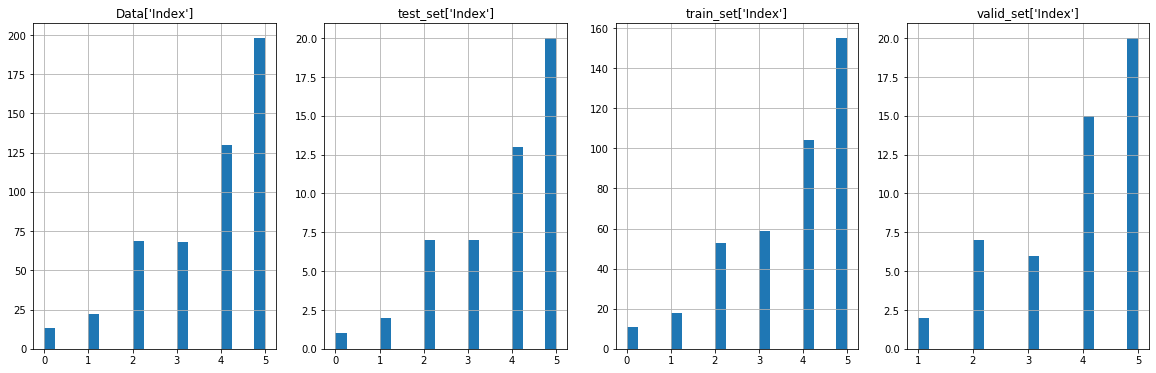

In [13]:
fig = plt.figure(figsize=(20, 6))

dataIndex = fig.add_subplot(1, 4, 1)
data["Index"].hist(bins=20)
dataIndex.title.set_text("Data['Index']")

testIndex = fig.add_subplot(1, 4, 2)
test_set["Index"].hist(bins=20)
testIndex.title.set_text("test_set['Index']")


trainIndex = fig.add_subplot(1, 4, 3)
train_set["Index"].hist(bins=20)
trainIndex.title.set_text("train_set['Index']")

validIndex = fig.add_subplot(1, 4, 4)
valid_set["Index"].hist(bins=20)
validIndex.title.set_text("valid_set['Index']")

plt.show()

We now have a test_set, valid_set, and train_set. I'm content with how those "Index" feature distributions turned out, so I'll move on to creating the label/feature subsets.

In [14]:
train_features = train_set[["Weight", "Gender_Male", "Gender_Female", "Index"]]
train_labels = train_set[["Height"]]

test_features = test_set[["Weight", "Gender_Male", "Gender_Female", "Index"]]
test_labels = test_set[["Height"]]

valid_features = valid_set[["Weight", "Gender_Male", "Gender_Female", "Index"]]
valid_labels = valid_set[["Height"]]

After several attempts at using the default features provided with this dataset, I have decided to change the "Index" column in all of the subsets. Becasue "Index" falls into one of five different categories, there is not enough information given to the model, and I am unable to get my loss lower than around 70. I'll turn all "Index" columns into an actual BMI measurement, which is calculated as: BMI = (Weight in Kilograms)/(Height in Meters squared)

In [15]:
def fix_index_column(dframe):
    dframe["Index"] = dframe["Weight"]/(dframe["Height"]/100)**2

fix_index_column(train_set)
fix_index_column(test_set)
fix_index_column(valid_set)

print(train_set.head())
print("")
print(train_set.corr())#Hey, it increased the correlation! Awesome!

     Height  Weight      Index  Gender_Male  Gender_Female
147     140     146  74.489796            0              1
377     178     142  44.817574            1              0
105     195     126  33.136095            1              0
7       154     111  46.803846            1              0
179     188     100  28.293345            1              0

                 Height    Weight     Index  Gender_Male  Gender_Female
Height         1.000000  0.000080 -0.529824    -0.010733       0.010733
Weight         0.000080  1.000000  0.828242     0.000309      -0.000309
Index         -0.529824  0.828242  1.000000     0.018109      -0.018109
Gender_Male   -0.010733  0.000309  0.018109     1.000000      -1.000000
Gender_Female  0.010733 -0.000309 -0.018109    -1.000000       1.000000


In [16]:
#optional: get some info on the sets.
get_dataframe_info(train_features, "train_features")
get_dataframe_info(train_labels, "train_labels")
get_dataframe_info(test_features, "test_features")
get_dataframe_info(test_labels, "test_labels")
get_dataframe_info(valid_features, "valid_features")
get_dataframe_info(valid_labels, "valid_labels")

---------------------------------
train_features

shape: (400, 4)

     Weight  Gender_Male  Gender_Female  Index
147     146            0              1      5
377     142            1              0      5
105     126            1              0      4
7       111            1              0      5
179     100            1              0      3

---------------------------------
train_labels

shape: (400, 1)

     Height
147     140
377     178
105     195
7       154
179     188

---------------------------------
test_features

shape: (50, 4)

     Weight  Gender_Male  Gender_Female  Index
201      93            1              0      3
383     154            1              0      5
382     117            1              0      4
159     105            1              0      4
390      58            0              1      2

---------------------------------
test_labels

shape: (50, 1)

     Height
201     179
383     151
382     177
159     181
390     167

----------------------------

As a final step before creating the neural network, I'll use a MinMaxScalar to rescale the data into a range between 0 and 1. I'm not worried about outliers, because there don't appear to be any. I decided not to scale my labels, because I found some material saying that this is not nescissary. Note: the MinMaxScaler outputs ndarray objects instead of the origional dataframes, so I'll convert all label sets to ndarrays as well.

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_features = scaler.fit_transform(train_features)
test_features = scaler.fit_transform(test_features)
valid_features = scaler.fit_transform(valid_features)

train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()
valid_labels = valid_labels.to_numpy()

#train_labels = scaler.fit_transform(train_labels)
#test_labels = scaler.fit_transform(test_labels)
#valid_labels = scaler.fit_transform(valid_labels)

In [18]:
get_array_info(train_features, "train_features")
get_array_info(train_labels, "train_labels")

------------------------
train_features:

shape : (400, 4)

first 5 rows:
[[0.87272727 0.         1.         1.        ]
 [0.83636364 1.         0.         1.        ]
 [0.69090909 1.         0.         0.8       ]
 [0.55454545 1.         0.         1.        ]
 [0.45454545 1.         0.         0.6       ]]

------------------------
train_labels:

shape : (400, 1)

first 5 rows:
[[140]
 [178]
 [195]
 [154]
 [188]]



# Prepare the machine learning algorithm

Now that the data is ready for machine learning, I will use Keras to create a feedforward neural network with densly connected layers.

In [67]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

keras.backend.clear_session()
model = Sequential()

model.add(Dense(10, activation="relu", input_shape=[4,]))
model.add(Dense(20, activation="relu"))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


I'll use Mean Squared Error as the loss for this, and also use it for metrics, because this is a regression problem.

In [68]:
model.compile(
 optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
 loss = "mean_squared_error",
 metrics = ["mean_squared_error"]
)

Time to train the model! I'll be using a callback that saves only the best model during this.

In [69]:
save_cb = keras.callbacks.ModelCheckpoint("./Models/proj_7_best_model.h5", save_best_only=True)

results = model.fit(
 train_features, train_labels,
 epochs= 20000,
 batch_size = 40,
 validation_data = (valid_features, valid_labels),
 callbacks=[save_cb]
)

Train on 400 samples, validate on 50 samples
Epoch 1/20000
400/400 [==============================] - 0s 171us/step - loss: 29336.3047 - mean_squared_error: 29336.3047 - val_loss: 28100.7750 - val_mean_squared_error: 28100.7754
Epoch 2/20000
400/400 [==============================] - 0s 26us/step - loss: 29299.9846 - mean_squared_error: 29299.9883 - val_loss: 28064.2934 - val_mean_squared_error: 28064.2930
Epoch 3/20000
400/400 [==============================] - 0s 28us/step - loss: 29263.4766 - mean_squared_error: 29263.4746 - val_loss: 28028.0117 - val_mean_squared_error: 28028.0098
Epoch 4/20000
400/400 [==============================] - 0s 28us/step - loss: 29226.9199 - mean_squared_error: 29226.9199 - val_loss: 27990.8699 - val_mean_squared_error: 27990.8691
Epoch 5/20000
400/400 [==============================] - 0s 25us/step - loss: 29188.6027 - mean_squared_error: 29188.6055 - val_loss: 27951.9898 - val_mean_squared_error: 27951.9902
Epoch 6/20000
400/400 [=====================

C:\Anaconda\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 9/20000
400/400 [==============================] - 0s 27us/step - loss: 28975.7896 - mean_squared_error: 28975.7891 - val_loss: 27726.2656 - val_mean_squared_error: 27726.2656
Epoch 10/20000
400/400 [==============================] - 0s 30us/step - loss: 28891.4762 - mean_squared_error: 28891.4746 - val_loss: 27633.9516 - val_mean_squared_error: 27633.9531
Epoch 11/20000
400/400 [==============================] - 0s 35us/step - loss: 28786.6119 - mean_squared_error: 28786.6094 - val_loss: 27521.5637 - val_mean_squared_error: 27521.5625
Epoch 12/20000
400/400 [==============================] - 0s 32us/step - loss: 28658.5664 - mean_squared_error: 28658.5645 - val_loss: 27385.7668 - val_mean_squared_error: 27385.7656
Epoch 13/20000
400/400 [==============================] - 0s 27us/step - loss: 28504.2768 - mean_squared_error: 28504.2754 - val_loss: 27223.5723 - val_mean_squared_error: 27223.5723
Epoch 14/20000
400/400 [==============================] - 0s 27us/step - loss: 28319.4

400/400 [==============================] - 0s 37us/step - loss: 1201.8451 - mean_squared_error: 1201.8451 - val_loss: 1110.4511 - val_mean_squared_error: 1110.4510
Epoch 55/20000
400/400 [==============================] - ETA: 0s - loss: 777.1545 - mean_squared_error: 777.15 - 0s 35us/step - loss: 1155.2000 - mean_squared_error: 1155.2000 - val_loss: 1079.2540 - val_mean_squared_error: 1079.2540
Epoch 56/20000
400/400 [==============================] - 0s 30us/step - loss: 1118.9306 - mean_squared_error: 1118.9305 - val_loss: 1058.4872 - val_mean_squared_error: 1058.4873
Epoch 57/20000
400/400 [==============================] - 0s 27us/step - loss: 1097.1141 - mean_squared_error: 1097.1140 - val_loss: 1042.0845 - val_mean_squared_error: 1042.0845
Epoch 58/20000
400/400 [==============================] - 0s 30us/step - loss: 1077.1592 - mean_squared_error: 1077.1591 - val_loss: 1030.8531 - val_mean_squared_error: 1030.8530
Epoch 59/20000
400/400 [==============================] - 0s 30u

Epoch 100/20000
400/400 [==============================] - 0s 27us/step - loss: 838.1716 - mean_squared_error: 838.1716 - val_loss: 805.3503 - val_mean_squared_error: 805.3503
Epoch 101/20000
400/400 [==============================] - 0s 27us/step - loss: 833.2460 - mean_squared_error: 833.2460 - val_loss: 800.8097 - val_mean_squared_error: 800.8097
Epoch 102/20000
400/400 [==============================] - 0s 27us/step - loss: 827.9994 - mean_squared_error: 827.9993 - val_loss: 795.0077 - val_mean_squared_error: 795.0076
Epoch 103/20000
400/400 [==============================] - 0s 27us/step - loss: 822.8019 - mean_squared_error: 822.8019 - val_loss: 789.6358 - val_mean_squared_error: 789.6358
Epoch 104/20000
400/400 [==============================] - 0s 25us/step - loss: 817.7968 - mean_squared_error: 817.7968 - val_loss: 784.2266 - val_mean_squared_error: 784.2266
Epoch 105/20000
400/400 [==============================] - 0s 30us/step - loss: 812.6614 - mean_squared_error: 812.6615 

400/400 [==============================] - 0s 27us/step - loss: 616.1515 - mean_squared_error: 616.1516 - val_loss: 581.2807 - val_mean_squared_error: 581.2808
Epoch 147/20000
400/400 [==============================] - 0s 27us/step - loss: 611.7502 - mean_squared_error: 611.7502 - val_loss: 576.2429 - val_mean_squared_error: 576.2430
Epoch 148/20000
400/400 [==============================] - 0s 30us/step - loss: 607.4678 - mean_squared_error: 607.4678 - val_loss: 572.0383 - val_mean_squared_error: 572.0383
Epoch 149/20000
400/400 [==============================] - 0s 27us/step - loss: 603.1533 - mean_squared_error: 603.1533 - val_loss: 568.5837 - val_mean_squared_error: 568.5837
Epoch 150/20000
400/400 [==============================] - 0s 25us/step - loss: 598.6591 - mean_squared_error: 598.6591 - val_loss: 564.6923 - val_mean_squared_error: 564.6923
Epoch 151/20000
400/400 [==============================] - 0s 35us/step - loss: 594.2737 - mean_squared_error: 594.2737 - val_loss: 560.

400/400 [==============================] - 0s 30us/step - loss: 440.5726 - mean_squared_error: 440.5726 - val_loss: 414.7327 - val_mean_squared_error: 414.7327
Epoch 193/20000
400/400 [==============================] - 0s 27us/step - loss: 437.4469 - mean_squared_error: 437.4469 - val_loss: 411.3522 - val_mean_squared_error: 411.3522
Epoch 194/20000
400/400 [==============================] - 0s 27us/step - loss: 434.5785 - mean_squared_error: 434.5784 - val_loss: 409.7285 - val_mean_squared_error: 409.7285
Epoch 195/20000
400/400 [==============================] - 0s 35us/step - loss: 431.2430 - mean_squared_error: 431.2430 - val_loss: 406.4876 - val_mean_squared_error: 406.4876
Epoch 196/20000
400/400 [==============================] - 0s 27us/step - loss: 428.3685 - mean_squared_error: 428.3684 - val_loss: 403.1472 - val_mean_squared_error: 403.1472
Epoch 197/20000
400/400 [==============================] - 0s 25us/step - loss: 425.4563 - mean_squared_error: 425.4563 - val_loss: 400.

400/400 [==============================] - 0s 25us/step - loss: 329.3828 - mean_squared_error: 329.3829 - val_loss: 319.3767 - val_mean_squared_error: 319.3767
Epoch 239/20000
400/400 [==============================] - 0s 30us/step - loss: 327.6444 - mean_squared_error: 327.6444 - val_loss: 317.7546 - val_mean_squared_error: 317.7546
Epoch 240/20000
400/400 [==============================] - 0s 37us/step - loss: 325.5947 - mean_squared_error: 325.5947 - val_loss: 316.9086 - val_mean_squared_error: 316.9086
Epoch 241/20000
400/400 [==============================] - 0s 35us/step - loss: 324.4238 - mean_squared_error: 324.4238 - val_loss: 317.4195 - val_mean_squared_error: 317.4195
Epoch 242/20000
400/400 [==============================] - 0s 32us/step - loss: 322.3248 - mean_squared_error: 322.3248 - val_loss: 315.5609 - val_mean_squared_error: 315.5609
Epoch 243/20000
400/400 [==============================] - 0s 30us/step - loss: 320.6560 - mean_squared_error: 320.6560 - val_loss: 313.

400/400 [==============================] - 0s 25us/step - loss: 268.3588 - mean_squared_error: 268.3588 - val_loss: 275.0783 - val_mean_squared_error: 275.0783
Epoch 285/20000
400/400 [==============================] - 0s 27us/step - loss: 267.4893 - mean_squared_error: 267.4893 - val_loss: 273.2689 - val_mean_squared_error: 273.2689
Epoch 286/20000
400/400 [==============================] - 0s 27us/step - loss: 266.8764 - mean_squared_error: 266.8764 - val_loss: 274.7838 - val_mean_squared_error: 274.7838
Epoch 287/20000
400/400 [==============================] - 0s 27us/step - loss: 265.4357 - mean_squared_error: 265.4358 - val_loss: 274.3268 - val_mean_squared_error: 274.3268
Epoch 288/20000
400/400 [==============================] - 0s 27us/step - loss: 264.3032 - mean_squared_error: 264.3032 - val_loss: 272.6315 - val_mean_squared_error: 272.6315
Epoch 289/20000
400/400 [==============================] - 0s 25us/step - loss: 264.1656 - mean_squared_error: 264.1656 - val_loss: 269.

400/400 [==============================] - 0s 30us/step - loss: 229.0844 - mean_squared_error: 229.0844 - val_loss: 246.4335 - val_mean_squared_error: 246.4335
Epoch 331/20000
400/400 [==============================] - 0s 37us/step - loss: 228.2547 - mean_squared_error: 228.2547 - val_loss: 247.2834 - val_mean_squared_error: 247.2834
Epoch 332/20000
400/400 [==============================] - 0s 32us/step - loss: 227.5627 - mean_squared_error: 227.5627 - val_loss: 246.6978 - val_mean_squared_error: 246.6978
Epoch 333/20000
400/400 [==============================] - 0s 32us/step - loss: 226.7508 - mean_squared_error: 226.7508 - val_loss: 244.4439 - val_mean_squared_error: 244.4439
Epoch 334/20000
400/400 [==============================] - 0s 27us/step - loss: 226.7438 - mean_squared_error: 226.7438 - val_loss: 241.0757 - val_mean_squared_error: 241.0757
Epoch 335/20000
400/400 [==============================] - 0s 25us/step - loss: 225.6471 - mean_squared_error: 225.6471 - val_loss: 244.

400/400 [==============================] - 0s 27us/step - loss: 196.6946 - mean_squared_error: 196.6946 - val_loss: 219.8169 - val_mean_squared_error: 219.8170
Epoch 377/20000
400/400 [==============================] - 0s 25us/step - loss: 196.1086 - mean_squared_error: 196.1086 - val_loss: 219.8886 - val_mean_squared_error: 219.8885
Epoch 378/20000
400/400 [==============================] - 0s 27us/step - loss: 195.6740 - mean_squared_error: 195.6740 - val_loss: 218.1935 - val_mean_squared_error: 218.1935
Epoch 379/20000
400/400 [==============================] - 0s 40us/step - loss: 194.7607 - mean_squared_error: 194.7607 - val_loss: 218.7517 - val_mean_squared_error: 218.7517
Epoch 380/20000
400/400 [==============================] - 0s 32us/step - loss: 194.2106 - mean_squared_error: 194.2106 - val_loss: 219.5365 - val_mean_squared_error: 219.5365
Epoch 381/20000
400/400 [==============================] - 0s 30us/step - loss: 193.5733 - mean_squared_error: 193.5733 - val_loss: 217.

400/400 [==============================] - 0s 30us/step - loss: 170.1655 - mean_squared_error: 170.1655 - val_loss: 199.4627 - val_mean_squared_error: 199.4627
Epoch 423/20000
400/400 [==============================] - 0s 27us/step - loss: 169.7672 - mean_squared_error: 169.7672 - val_loss: 196.9496 - val_mean_squared_error: 196.9496
Epoch 424/20000
400/400 [==============================] - 0s 25us/step - loss: 169.2387 - mean_squared_error: 169.2387 - val_loss: 199.8035 - val_mean_squared_error: 199.8035
Epoch 425/20000
400/400 [==============================] - 0s 27us/step - loss: 168.7764 - mean_squared_error: 168.7764 - val_loss: 197.0723 - val_mean_squared_error: 197.0723
Epoch 426/20000
400/400 [==============================] - 0s 30us/step - loss: 168.2223 - mean_squared_error: 168.2222 - val_loss: 198.4839 - val_mean_squared_error: 198.4839
Epoch 427/20000
400/400 [==============================] - 0s 25us/step - loss: 167.7778 - mean_squared_error: 167.7778 - val_loss: 196.

400/400 [==============================] - 0s 30us/step - loss: 150.5756 - mean_squared_error: 150.5756 - val_loss: 184.3839 - val_mean_squared_error: 184.3839
Epoch 469/20000
400/400 [==============================] - 0s 30us/step - loss: 150.2267 - mean_squared_error: 150.2267 - val_loss: 184.3687 - val_mean_squared_error: 184.3687
Epoch 470/20000
400/400 [==============================] - 0s 25us/step - loss: 149.9183 - mean_squared_error: 149.9183 - val_loss: 183.4679 - val_mean_squared_error: 183.4679
Epoch 471/20000
400/400 [==============================] - 0s 27us/step - loss: 149.8907 - mean_squared_error: 149.8907 - val_loss: 186.7140 - val_mean_squared_error: 186.7140
Epoch 472/20000
400/400 [==============================] - 0s 27us/step - loss: 149.2818 - mean_squared_error: 149.2818 - val_loss: 185.8879 - val_mean_squared_error: 185.8879
Epoch 473/20000
400/400 [==============================] - 0s 25us/step - loss: 149.0968 - mean_squared_error: 149.0968 - val_loss: 184.

400/400 [==============================] - 0s 27us/step - loss: 138.4070 - mean_squared_error: 138.4070 - val_loss: 180.0118 - val_mean_squared_error: 180.0118
Epoch 515/20000
400/400 [==============================] - 0s 30us/step - loss: 138.2603 - mean_squared_error: 138.2603 - val_loss: 179.5677 - val_mean_squared_error: 179.5677
Epoch 516/20000
400/400 [==============================] - 0s 27us/step - loss: 138.5510 - mean_squared_error: 138.5510 - val_loss: 184.1347 - val_mean_squared_error: 184.1347
Epoch 517/20000
400/400 [==============================] - 0s 25us/step - loss: 138.0171 - mean_squared_error: 138.0171 - val_loss: 177.9716 - val_mean_squared_error: 177.9717
Epoch 518/20000
400/400 [==============================] - 0s 25us/step - loss: 137.8919 - mean_squared_error: 137.8919 - val_loss: 178.7848 - val_mean_squared_error: 178.7848
Epoch 519/20000
400/400 [==============================] - 0s 30us/step - loss: 137.5660 - mean_squared_error: 137.5660 - val_loss: 180.

400/400 [==============================] - 0s 25us/step - loss: 132.3190 - mean_squared_error: 132.3190 - val_loss: 181.5143 - val_mean_squared_error: 181.5143
Epoch 561/20000
400/400 [==============================] - 0s 27us/step - loss: 132.1730 - mean_squared_error: 132.1730 - val_loss: 178.4331 - val_mean_squared_error: 178.4332
Epoch 562/20000
400/400 [==============================] - 0s 27us/step - loss: 132.4276 - mean_squared_error: 132.4276 - val_loss: 182.8765 - val_mean_squared_error: 182.8765
Epoch 563/20000
400/400 [==============================] - 0s 27us/step - loss: 132.0410 - mean_squared_error: 132.0410 - val_loss: 175.7708 - val_mean_squared_error: 175.7708
Epoch 564/20000
400/400 [==============================] - 0s 25us/step - loss: 132.0812 - mean_squared_error: 132.0812 - val_loss: 175.8580 - val_mean_squared_error: 175.8580
Epoch 565/20000
400/400 [==============================] - 0s 25us/step - loss: 131.7205 - mean_squared_error: 131.7205 - val_loss: 179.

Epoch 607/20000
400/400 [==============================] - 0s 27us/step - loss: 129.7085 - mean_squared_error: 129.7085 - val_loss: 182.4054 - val_mean_squared_error: 182.4054
Epoch 608/20000
400/400 [==============================] - 0s 25us/step - loss: 129.6319 - mean_squared_error: 129.6319 - val_loss: 181.9144 - val_mean_squared_error: 181.9144
Epoch 609/20000
400/400 [==============================] - 0s 27us/step - loss: 129.6786 - mean_squared_error: 129.6786 - val_loss: 178.6588 - val_mean_squared_error: 178.6588
Epoch 610/20000
400/400 [==============================] - 0s 25us/step - loss: 129.6638 - mean_squared_error: 129.6638 - val_loss: 179.9657 - val_mean_squared_error: 179.9657
Epoch 611/20000
400/400 [==============================] - 0s 25us/step - loss: 129.5699 - mean_squared_error: 129.5699 - val_loss: 180.1459 - val_mean_squared_error: 180.1459
Epoch 612/20000
400/400 [==============================] - 0s 25us/step - loss: 129.5799 - mean_squared_error: 129.5799 

400/400 [==============================] - 0s 27us/step - loss: 129.0531 - mean_squared_error: 129.0532 - val_loss: 183.4684 - val_mean_squared_error: 183.4684
Epoch 654/20000
400/400 [==============================] - 0s 32us/step - loss: 130.2625 - mean_squared_error: 130.2625 - val_loss: 176.1110 - val_mean_squared_error: 176.1110
Epoch 655/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4765 - mean_squared_error: 128.4765 - val_loss: 185.4715 - val_mean_squared_error: 185.4715
Epoch 656/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0567 - mean_squared_error: 129.0567 - val_loss: 187.7195 - val_mean_squared_error: 187.7195
Epoch 657/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1574 - mean_squared_error: 129.1574 - val_loss: 179.9185 - val_mean_squared_error: 179.9184
Epoch 658/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2027 - mean_squared_error: 129.2027 - val_loss: 182.

400/400 [==============================] - 0s 25us/step - loss: 128.8154 - mean_squared_error: 128.8154 - val_loss: 181.4924 - val_mean_squared_error: 181.4924
Epoch 700/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8522 - mean_squared_error: 128.8522 - val_loss: 185.7274 - val_mean_squared_error: 185.7274
Epoch 701/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1531 - mean_squared_error: 129.1531 - val_loss: 186.1129 - val_mean_squared_error: 186.1129
Epoch 702/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7436 - mean_squared_error: 128.7436 - val_loss: 186.6281 - val_mean_squared_error: 186.6281
Epoch 703/20000
400/400 [==============================] - 0s 22us/step - loss: 129.3380 - mean_squared_error: 129.3380 - val_loss: 177.3271 - val_mean_squared_error: 177.3271
Epoch 704/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3812 - mean_squared_error: 129.3812 - val_loss: 187.

400/400 [==============================] - 0s 27us/step - loss: 128.9914 - mean_squared_error: 128.9915 - val_loss: 179.8451 - val_mean_squared_error: 179.8450
Epoch 746/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4425 - mean_squared_error: 128.4425 - val_loss: 188.4633 - val_mean_squared_error: 188.4633
Epoch 747/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9125 - mean_squared_error: 128.9125 - val_loss: 188.6928 - val_mean_squared_error: 188.6928
Epoch 748/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6800 - mean_squared_error: 128.6800 - val_loss: 179.1233 - val_mean_squared_error: 179.1233
Epoch 749/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8059 - mean_squared_error: 128.8060 - val_loss: 186.2346 - val_mean_squared_error: 186.2346
Epoch 750/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6885 - mean_squared_error: 128.6885 - val_loss: 184.

400/400 [==============================] - 0s 30us/step - loss: 128.5523 - mean_squared_error: 128.5523 - val_loss: 184.2449 - val_mean_squared_error: 184.2449
Epoch 792/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6863 - mean_squared_error: 128.6863 - val_loss: 183.1326 - val_mean_squared_error: 183.1326
Epoch 793/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6124 - mean_squared_error: 128.6124 - val_loss: 183.8747 - val_mean_squared_error: 183.8747
Epoch 794/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5297 - mean_squared_error: 128.5297 - val_loss: 184.4291 - val_mean_squared_error: 184.4291
Epoch 795/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4556 - mean_squared_error: 128.4556 - val_loss: 185.1661 - val_mean_squared_error: 185.1661
Epoch 796/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4967 - mean_squared_error: 128.4967 - val_loss: 185.

400/400 [==============================] - 0s 30us/step - loss: 128.6584 - mean_squared_error: 128.6584 - val_loss: 183.6083 - val_mean_squared_error: 183.6083
Epoch 838/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7800 - mean_squared_error: 128.7800 - val_loss: 190.0310 - val_mean_squared_error: 190.0310
Epoch 839/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8729 - mean_squared_error: 128.8729 - val_loss: 184.9056 - val_mean_squared_error: 184.9056
Epoch 840/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6294 - mean_squared_error: 128.6294 - val_loss: 181.9195 - val_mean_squared_error: 181.9195
Epoch 841/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8836 - mean_squared_error: 128.8836 - val_loss: 186.3289 - val_mean_squared_error: 186.3289
Epoch 842/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4883 - mean_squared_error: 128.4883 - val_loss: 182.

400/400 [==============================] - 0s 30us/step - loss: 128.7982 - mean_squared_error: 128.7982 - val_loss: 180.9477 - val_mean_squared_error: 180.9477
Epoch 884/20000
400/400 [==============================] - 0s 27us/step - loss: 128.3578 - mean_squared_error: 128.3578 - val_loss: 186.9097 - val_mean_squared_error: 186.9097
Epoch 885/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7678 - mean_squared_error: 128.7678 - val_loss: 187.3916 - val_mean_squared_error: 187.3916
Epoch 886/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9380 - mean_squared_error: 128.9380 - val_loss: 181.1555 - val_mean_squared_error: 181.1555
Epoch 887/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4497 - mean_squared_error: 128.4498 - val_loss: 187.5130 - val_mean_squared_error: 187.5130
Epoch 888/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9310 - mean_squared_error: 128.9310 - val_loss: 185.

400/400 [==============================] - 0s 27us/step - loss: 129.0580 - mean_squared_error: 129.0580 - val_loss: 180.4239 - val_mean_squared_error: 180.4239
Epoch 930/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8671 - mean_squared_error: 128.8671 - val_loss: 189.9720 - val_mean_squared_error: 189.9720
Epoch 931/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6371 - mean_squared_error: 128.6371 - val_loss: 184.3650 - val_mean_squared_error: 184.3650
Epoch 932/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7900 - mean_squared_error: 128.7900 - val_loss: 181.1644 - val_mean_squared_error: 181.1644
Epoch 933/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6627 - mean_squared_error: 128.6627 - val_loss: 181.0523 - val_mean_squared_error: 181.0523
Epoch 934/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5161 - mean_squared_error: 128.5161 - val_loss: 187.

400/400 [==============================] - 0s 27us/step - loss: 128.3967 - mean_squared_error: 128.3967 - val_loss: 185.4830 - val_mean_squared_error: 185.4830
Epoch 976/20000
400/400 [==============================] - 0s 25us/step - loss: 129.2099 - mean_squared_error: 129.2099 - val_loss: 189.5445 - val_mean_squared_error: 189.5445
Epoch 977/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6546 - mean_squared_error: 128.6546 - val_loss: 179.4072 - val_mean_squared_error: 179.4072
Epoch 978/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8280 - mean_squared_error: 128.8280 - val_loss: 181.1107 - val_mean_squared_error: 181.1107
Epoch 979/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5121 - mean_squared_error: 128.5121 - val_loss: 189.2465 - val_mean_squared_error: 189.2465
Epoch 980/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8171 - mean_squared_error: 128.8171 - val_loss: 189.

400/400 [==============================] - 0s 25us/step - loss: 129.7797 - mean_squared_error: 129.7797 - val_loss: 179.4194 - val_mean_squared_error: 179.4194
Epoch 1022/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0277 - mean_squared_error: 129.0277 - val_loss: 186.4992 - val_mean_squared_error: 186.4992
Epoch 1023/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3203 - mean_squared_error: 129.3203 - val_loss: 185.3604 - val_mean_squared_error: 185.3604
Epoch 1024/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7310 - mean_squared_error: 128.7310 - val_loss: 180.9084 - val_mean_squared_error: 180.9084
Epoch 1025/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5089 - mean_squared_error: 128.5089 - val_loss: 184.9566 - val_mean_squared_error: 184.9566
Epoch 1026/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9771 - mean_squared_error: 128.9771 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.6772 - mean_squared_error: 128.6772 - val_loss: 187.5813 - val_mean_squared_error: 187.5813
Epoch 1068/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5053 - mean_squared_error: 128.5052 - val_loss: 182.0912 - val_mean_squared_error: 182.0912
Epoch 1069/20000
400/400 [==============================] - 0s 35us/step - loss: 128.7457 - mean_squared_error: 128.7458 - val_loss: 187.1082 - val_mean_squared_error: 187.1082
Epoch 1070/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4629 - mean_squared_error: 128.4629 - val_loss: 181.7301 - val_mean_squared_error: 181.7301
Epoch 1071/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8667 - mean_squared_error: 128.8667 - val_loss: 185.4942 - val_mean_squared_error: 185.4942
Epoch 1072/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5006 - mean_squared_error: 128.5006 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 129.2744 - mean_squared_error: 129.2744 - val_loss: 183.2207 - val_mean_squared_error: 183.2207
Epoch 1114/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7055 - mean_squared_error: 128.7055 - val_loss: 188.8841 - val_mean_squared_error: 188.8841
Epoch 1115/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7451 - mean_squared_error: 128.7451 - val_loss: 181.5179 - val_mean_squared_error: 181.5179
Epoch 1116/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7720 - mean_squared_error: 128.7720 - val_loss: 185.7227 - val_mean_squared_error: 185.7227
Epoch 1117/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7193 - mean_squared_error: 128.7193 - val_loss: 185.1361 - val_mean_squared_error: 185.1361
Epoch 1118/20000
400/400 [==============================] - 0s 22us/step - loss: 128.5190 - mean_squared_error: 128.5190 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.0451 - mean_squared_error: 129.0451 - val_loss: 186.7374 - val_mean_squared_error: 186.7374
Epoch 1160/20000
400/400 [==============================] - 0s 25us/step - loss: 128.2810 - mean_squared_error: 128.2810 - val_loss: 182.1929 - val_mean_squared_error: 182.1929
Epoch 1161/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6687 - mean_squared_error: 128.6687 - val_loss: 181.8171 - val_mean_squared_error: 181.8170
Epoch 1162/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7984 - mean_squared_error: 128.7984 - val_loss: 186.3676 - val_mean_squared_error: 186.3676
Epoch 1163/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5493 - mean_squared_error: 128.5493 - val_loss: 184.3064 - val_mean_squared_error: 184.3064
Epoch 1164/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5231 - mean_squared_error: 128.5231 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.5876 - mean_squared_error: 129.5876 - val_loss: 183.1402 - val_mean_squared_error: 183.1402
Epoch 1206/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3510 - mean_squared_error: 129.3510 - val_loss: 195.5164 - val_mean_squared_error: 195.5164
Epoch 1207/20000
400/400 [==============================] - 0s 27us/step - loss: 130.1124 - mean_squared_error: 130.1124 - val_loss: 179.9842 - val_mean_squared_error: 179.9842
Epoch 1208/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1402 - mean_squared_error: 129.1402 - val_loss: 189.3955 - val_mean_squared_error: 189.3956
Epoch 1209/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7981 - mean_squared_error: 128.7981 - val_loss: 182.6052 - val_mean_squared_error: 182.6052
Epoch 1210/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6884 - mean_squared_error: 128.6884 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 128.9442 - mean_squared_error: 128.9442 - val_loss: 185.2965 - val_mean_squared_error: 185.2966
Epoch 1252/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9293 - mean_squared_error: 128.9293 - val_loss: 180.7958 - val_mean_squared_error: 180.7958
Epoch 1253/20000
400/400 [==============================] - 0s 35us/step - loss: 129.9612 - mean_squared_error: 129.9612 - val_loss: 192.7893 - val_mean_squared_error: 192.7893
Epoch 1254/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7516 - mean_squared_error: 128.7516 - val_loss: 179.7701 - val_mean_squared_error: 179.7701
Epoch 1255/20000
400/400 [==============================] - 0s 25us/step - loss: 129.2308 - mean_squared_error: 129.2308 - val_loss: 185.6378 - val_mean_squared_error: 185.6378
Epoch 1256/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7661 - mean_squared_error: 128.7661 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.7655 - mean_squared_error: 128.7655 - val_loss: 183.8868 - val_mean_squared_error: 183.8868
Epoch 1298/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9589 - mean_squared_error: 128.9590 - val_loss: 185.6782 - val_mean_squared_error: 185.6782
Epoch 1299/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6992 - mean_squared_error: 128.6991 - val_loss: 183.8718 - val_mean_squared_error: 183.8718
Epoch 1300/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8774 - mean_squared_error: 128.8775 - val_loss: 186.0758 - val_mean_squared_error: 186.0758
Epoch 1301/20000
400/400 [==============================] - 0s 27us/step - loss: 128.3949 - mean_squared_error: 128.3949 - val_loss: 182.4876 - val_mean_squared_error: 182.4876
Epoch 1302/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7839 - mean_squared_error: 128.7839 - val_loss:

Epoch 1343/20000
400/400 [==============================] - 0s 32us/step - loss: 130.6216 - mean_squared_error: 130.6216 - val_loss: 174.2746 - val_mean_squared_error: 174.2746
Epoch 1344/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4059 - mean_squared_error: 128.4059 - val_loss: 186.8009 - val_mean_squared_error: 186.8009
Epoch 1345/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8822 - mean_squared_error: 128.8822 - val_loss: 191.4637 - val_mean_squared_error: 191.4637
Epoch 1346/20000
400/400 [==============================] - 0s 25us/step - loss: 129.9769 - mean_squared_error: 129.9769 - val_loss: 180.2933 - val_mean_squared_error: 180.2933
Epoch 1347/20000
400/400 [==============================] - 0s 35us/step - loss: 128.5375 - mean_squared_error: 128.5375 - val_loss: 187.9464 - val_mean_squared_error: 187.9464
Epoch 1348/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7874 - mean_squared_error: 128

400/400 [==============================] - 0s 27us/step - loss: 128.8960 - mean_squared_error: 128.8960 - val_loss: 185.4353 - val_mean_squared_error: 185.4353
Epoch 1390/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6323 - mean_squared_error: 128.6323 - val_loss: 186.0556 - val_mean_squared_error: 186.0556
Epoch 1391/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5879 - mean_squared_error: 128.5879 - val_loss: 182.7614 - val_mean_squared_error: 182.7614
Epoch 1392/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5493 - mean_squared_error: 128.5494 - val_loss: 184.2671 - val_mean_squared_error: 184.2671
Epoch 1393/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4656 - mean_squared_error: 128.4656 - val_loss: 187.6467 - val_mean_squared_error: 187.6467
Epoch 1394/20000
400/400 [==============================] - 0s 25us/step - loss: 129.3551 - mean_squared_error: 129.3551 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 129.1101 - mean_squared_error: 129.1100 - val_loss: 185.9868 - val_mean_squared_error: 185.9868
Epoch 1436/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5563 - mean_squared_error: 128.5563 - val_loss: 184.7711 - val_mean_squared_error: 184.7711
Epoch 1437/20000
400/400 [==============================] - 0s 40us/step - loss: 128.6118 - mean_squared_error: 128.6118 - val_loss: 184.1973 - val_mean_squared_error: 184.1973
Epoch 1438/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8486 - mean_squared_error: 128.8486 - val_loss: 182.9008 - val_mean_squared_error: 182.9008
Epoch 1439/20000
400/400 [==============================] - 0s 25us/step - loss: 128.3784 - mean_squared_error: 128.3784 - val_loss: 185.6138 - val_mean_squared_error: 185.6138
Epoch 1440/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7379 - mean_squared_error: 128.7379 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.7311 - mean_squared_error: 128.7311 - val_loss: 183.5862 - val_mean_squared_error: 183.5862
Epoch 1482/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7312 - mean_squared_error: 128.7312 - val_loss: 183.3429 - val_mean_squared_error: 183.3429
Epoch 1483/20000
400/400 [==============================] - 0s 25us/step - loss: 129.2467 - mean_squared_error: 129.2467 - val_loss: 189.9715 - val_mean_squared_error: 189.9715
Epoch 1484/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7190 - mean_squared_error: 128.7190 - val_loss: 182.2223 - val_mean_squared_error: 182.2223
Epoch 1485/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5780 - mean_squared_error: 128.5780 - val_loss: 184.9959 - val_mean_squared_error: 184.9959
Epoch 1486/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7872 - mean_squared_error: 128.7872 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.9395 - mean_squared_error: 128.9395 - val_loss: 181.3591 - val_mean_squared_error: 181.3591
Epoch 1528/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8771 - mean_squared_error: 128.8771 - val_loss: 185.7127 - val_mean_squared_error: 185.7127
Epoch 1529/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4183 - mean_squared_error: 128.4183 - val_loss: 185.2913 - val_mean_squared_error: 185.2913
Epoch 1530/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9444 - mean_squared_error: 128.9444 - val_loss: 181.8691 - val_mean_squared_error: 181.8691
Epoch 1531/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4473 - mean_squared_error: 128.4473 - val_loss: 186.8264 - val_mean_squared_error: 186.8264
Epoch 1532/20000
400/400 [==============================] - 0s 35us/step - loss: 128.8524 - mean_squared_error: 128.8524 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.9005 - mean_squared_error: 128.9005 - val_loss: 183.8205 - val_mean_squared_error: 183.8205
Epoch 1574/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7837 - mean_squared_error: 128.7837 - val_loss: 183.5394 - val_mean_squared_error: 183.5394
Epoch 1575/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6853 - mean_squared_error: 128.6853 - val_loss: 184.1966 - val_mean_squared_error: 184.1966
Epoch 1576/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0687 - mean_squared_error: 129.0687 - val_loss: 188.6080 - val_mean_squared_error: 188.6080
Epoch 1577/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8731 - mean_squared_error: 128.8731 - val_loss: 180.4108 - val_mean_squared_error: 180.4108
Epoch 1578/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8665 - mean_squared_error: 128.8665 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 129.7016 - mean_squared_error: 129.7016 - val_loss: 177.3142 - val_mean_squared_error: 177.3142
Epoch 1620/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1446 - mean_squared_error: 129.1446 - val_loss: 194.1042 - val_mean_squared_error: 194.1041
Epoch 1621/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3295 - mean_squared_error: 129.3295 - val_loss: 183.7996 - val_mean_squared_error: 183.7997
Epoch 1622/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6917 - mean_squared_error: 128.6917 - val_loss: 183.1182 - val_mean_squared_error: 183.1182
Epoch 1623/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4441 - mean_squared_error: 128.4441 - val_loss: 186.1496 - val_mean_squared_error: 186.1496
Epoch 1624/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6273 - mean_squared_error: 128.6273 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 129.3217 - mean_squared_error: 129.3217 - val_loss: 190.4816 - val_mean_squared_error: 190.4816
Epoch 1666/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7361 - mean_squared_error: 128.7361 - val_loss: 182.7746 - val_mean_squared_error: 182.7746
Epoch 1667/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6554 - mean_squared_error: 128.6554 - val_loss: 183.0885 - val_mean_squared_error: 183.0885
Epoch 1668/20000
400/400 [==============================] - 0s 27us/step - loss: 129.6101 - mean_squared_error: 129.6101 - val_loss: 183.1049 - val_mean_squared_error: 183.1049
Epoch 1669/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8656 - mean_squared_error: 128.8656 - val_loss: 190.2250 - val_mean_squared_error: 190.2250
Epoch 1670/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5227 - mean_squared_error: 128.5227 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.5787 - mean_squared_error: 128.5787 - val_loss: 185.0488 - val_mean_squared_error: 185.0488
Epoch 1712/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6203 - mean_squared_error: 128.6203 - val_loss: 185.8073 - val_mean_squared_error: 185.8073
Epoch 1713/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5404 - mean_squared_error: 128.5403 - val_loss: 180.9775 - val_mean_squared_error: 180.9775
Epoch 1714/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5144 - mean_squared_error: 128.5144 - val_loss: 183.0749 - val_mean_squared_error: 183.0749
Epoch 1715/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1493 - mean_squared_error: 129.1493 - val_loss: 190.3549 - val_mean_squared_error: 190.3549
Epoch 1716/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6511 - mean_squared_error: 128.6511 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.0073 - mean_squared_error: 129.0073 - val_loss: 189.1917 - val_mean_squared_error: 189.1917
Epoch 1758/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6552 - mean_squared_error: 128.6552 - val_loss: 183.8197 - val_mean_squared_error: 183.8197
Epoch 1759/20000
400/400 [==============================] - 0s 35us/step - loss: 128.7359 - mean_squared_error: 128.7359 - val_loss: 180.4792 - val_mean_squared_error: 180.4792
Epoch 1760/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7892 - mean_squared_error: 128.7892 - val_loss: 190.3677 - val_mean_squared_error: 190.3677
Epoch 1761/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5470 - mean_squared_error: 128.5470 - val_loss: 185.0737 - val_mean_squared_error: 185.0737
Epoch 1762/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7021 - mean_squared_error: 128.7021 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.9644 - mean_squared_error: 128.9644 - val_loss: 189.8084 - val_mean_squared_error: 189.8084
Epoch 1804/20000
400/400 [==============================] - 0s 30us/step - loss: 130.1448 - mean_squared_error: 130.1448 - val_loss: 179.4729 - val_mean_squared_error: 179.4729
Epoch 1805/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5490 - mean_squared_error: 128.5490 - val_loss: 185.3270 - val_mean_squared_error: 185.3270
Epoch 1806/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4682 - mean_squared_error: 128.4682 - val_loss: 187.9771 - val_mean_squared_error: 187.9771
Epoch 1807/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0583 - mean_squared_error: 129.0583 - val_loss: 180.7122 - val_mean_squared_error: 180.7122
Epoch 1808/20000
400/400 [==============================] - 0s 25us/step - loss: 130.1097 - mean_squared_error: 130.1097 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 130.1372 - mean_squared_error: 130.1372 - val_loss: 190.4316 - val_mean_squared_error: 190.4316
Epoch 1850/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6164 - mean_squared_error: 128.6164 - val_loss: 182.4944 - val_mean_squared_error: 182.4944
Epoch 1851/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6770 - mean_squared_error: 128.6770 - val_loss: 180.8794 - val_mean_squared_error: 180.8795
Epoch 1852/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2321 - mean_squared_error: 129.2321 - val_loss: 189.5520 - val_mean_squared_error: 189.5520
Epoch 1853/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0074 - mean_squared_error: 129.0074 - val_loss: 180.2714 - val_mean_squared_error: 180.2714
Epoch 1854/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9405 - mean_squared_error: 128.9405 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.2241 - mean_squared_error: 129.2241 - val_loss: 191.9481 - val_mean_squared_error: 191.9481
Epoch 1896/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0098 - mean_squared_error: 129.0098 - val_loss: 182.4332 - val_mean_squared_error: 182.4332
Epoch 1897/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6215 - mean_squared_error: 128.6215 - val_loss: 186.0402 - val_mean_squared_error: 186.0402
Epoch 1898/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5364 - mean_squared_error: 128.5364 - val_loss: 183.9089 - val_mean_squared_error: 183.9089
Epoch 1899/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7390 - mean_squared_error: 128.7390 - val_loss: 185.3060 - val_mean_squared_error: 185.3060
Epoch 1900/20000
400/400 [==============================] - 0s 32us/step - loss: 128.3955 - mean_squared_error: 128.3955 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.0184 - mean_squared_error: 129.0185 - val_loss: 186.2377 - val_mean_squared_error: 186.2377
Epoch 1942/20000
400/400 [==============================] - 0s 27us/step - loss: 129.5955 - mean_squared_error: 129.5955 - val_loss: 178.2706 - val_mean_squared_error: 178.2706
Epoch 1943/20000
400/400 [==============================] - 0s 27us/step - loss: 128.2766 - mean_squared_error: 128.2766 - val_loss: 188.2598 - val_mean_squared_error: 188.2598
Epoch 1944/20000
400/400 [==============================] - 0s 27us/step - loss: 130.2060 - mean_squared_error: 130.2060 - val_loss: 192.0434 - val_mean_squared_error: 192.0434
Epoch 1945/20000
400/400 [==============================] - 0s 30us/step - loss: 128.1520 - mean_squared_error: 128.1520 - val_loss: 179.3629 - val_mean_squared_error: 179.3629
Epoch 1946/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0787 - mean_squared_error: 129.0787 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.4769 - mean_squared_error: 128.4769 - val_loss: 183.7564 - val_mean_squared_error: 183.7564
Epoch 1988/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6769 - mean_squared_error: 128.6768 - val_loss: 184.4488 - val_mean_squared_error: 184.4488
Epoch 1989/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7035 - mean_squared_error: 128.7035 - val_loss: 186.0275 - val_mean_squared_error: 186.0275
Epoch 1990/20000
400/400 [==============================] - 0s 32us/step - loss: 128.3969 - mean_squared_error: 128.3969 - val_loss: 183.6734 - val_mean_squared_error: 183.6734
Epoch 1991/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8740 - mean_squared_error: 128.8740 - val_loss: 184.4577 - val_mean_squared_error: 184.4577
Epoch 1992/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6869 - mean_squared_error: 128.6869 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.6839 - mean_squared_error: 129.6839 - val_loss: 194.5657 - val_mean_squared_error: 194.5657
Epoch 2034/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6970 - mean_squared_error: 128.6971 - val_loss: 182.1695 - val_mean_squared_error: 182.1695
Epoch 2035/20000
400/400 [==============================] - 0s 27us/step - loss: 129.5418 - mean_squared_error: 129.5418 - val_loss: 184.0268 - val_mean_squared_error: 184.0268
Epoch 2036/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5644 - mean_squared_error: 128.5644 - val_loss: 186.3443 - val_mean_squared_error: 186.3443
Epoch 2037/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5486 - mean_squared_error: 128.5486 - val_loss: 183.7594 - val_mean_squared_error: 183.7594
Epoch 2038/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6684 - mean_squared_error: 128.6684 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.5238 - mean_squared_error: 128.5238 - val_loss: 182.1120 - val_mean_squared_error: 182.1120
Epoch 2080/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4922 - mean_squared_error: 128.4922 - val_loss: 184.3108 - val_mean_squared_error: 184.3108
Epoch 2081/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4967 - mean_squared_error: 128.4967 - val_loss: 188.6010 - val_mean_squared_error: 188.6010
Epoch 2082/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9789 - mean_squared_error: 128.9789 - val_loss: 187.8623 - val_mean_squared_error: 187.8624
Epoch 2083/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6608 - mean_squared_error: 128.6608 - val_loss: 182.4249 - val_mean_squared_error: 182.4249
Epoch 2084/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5994 - mean_squared_error: 128.5993 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.1101 - mean_squared_error: 129.1101 - val_loss: 178.3724 - val_mean_squared_error: 178.3724
Epoch 2126/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5828 - mean_squared_error: 128.5828 - val_loss: 188.2922 - val_mean_squared_error: 188.2922
Epoch 2127/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0805 - mean_squared_error: 129.0805 - val_loss: 183.5926 - val_mean_squared_error: 183.5926
Epoch 2128/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8703 - mean_squared_error: 128.8703 - val_loss: 188.7481 - val_mean_squared_error: 188.7481
Epoch 2129/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1559 - mean_squared_error: 129.1559 - val_loss: 181.0406 - val_mean_squared_error: 181.0406
Epoch 2130/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4379 - mean_squared_error: 128.4379 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.8226 - mean_squared_error: 128.8226 - val_loss: 182.2218 - val_mean_squared_error: 182.2218
Epoch 2172/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4932 - mean_squared_error: 128.4933 - val_loss: 185.7900 - val_mean_squared_error: 185.7900
Epoch 2173/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6465 - mean_squared_error: 128.6465 - val_loss: 186.9392 - val_mean_squared_error: 186.9392
Epoch 2174/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5541 - mean_squared_error: 128.5541 - val_loss: 187.4767 - val_mean_squared_error: 187.4767
Epoch 2175/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5980 - mean_squared_error: 128.5980 - val_loss: 181.9509 - val_mean_squared_error: 181.9509
Epoch 2176/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7039 - mean_squared_error: 128.7039 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.4956 - mean_squared_error: 128.4956 - val_loss: 187.0443 - val_mean_squared_error: 187.0443
Epoch 2218/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1808 - mean_squared_error: 129.1808 - val_loss: 188.6645 - val_mean_squared_error: 188.6645
Epoch 2219/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5733 - mean_squared_error: 128.5733 - val_loss: 179.0968 - val_mean_squared_error: 179.0968
Epoch 2220/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9232 - mean_squared_error: 128.9232 - val_loss: 186.6623 - val_mean_squared_error: 186.6623
Epoch 2221/20000
400/400 [==============================] - 0s 32us/step - loss: 129.1247 - mean_squared_error: 129.1247 - val_loss: 182.3173 - val_mean_squared_error: 182.3173
Epoch 2222/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0804 - mean_squared_error: 129.0804 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.5114 - mean_squared_error: 129.5114 - val_loss: 188.4343 - val_mean_squared_error: 188.4343
Epoch 2264/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5327 - mean_squared_error: 128.5327 - val_loss: 183.1642 - val_mean_squared_error: 183.1642
Epoch 2265/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2466 - mean_squared_error: 129.2466 - val_loss: 187.9334 - val_mean_squared_error: 187.9334
Epoch 2266/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3280 - mean_squared_error: 129.3280 - val_loss: 177.6898 - val_mean_squared_error: 177.6898
Epoch 2267/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5510 - mean_squared_error: 128.5510 - val_loss: 185.4644 - val_mean_squared_error: 185.4644
Epoch 2268/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1402 - mean_squared_error: 129.1402 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.8686 - mean_squared_error: 128.8686 - val_loss: 188.5777 - val_mean_squared_error: 188.5777
Epoch 2310/20000
400/400 [==============================] - 0s 25us/step - loss: 129.1090 - mean_squared_error: 129.1090 - val_loss: 182.0891 - val_mean_squared_error: 182.0891
Epoch 2311/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8712 - mean_squared_error: 128.8712 - val_loss: 184.9207 - val_mean_squared_error: 184.9207
Epoch 2312/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9244 - mean_squared_error: 128.9244 - val_loss: 191.2410 - val_mean_squared_error: 191.2410
Epoch 2313/20000
400/400 [==============================] - 0s 25us/step - loss: 129.5028 - mean_squared_error: 129.5028 - val_loss: 178.9218 - val_mean_squared_error: 178.9218
Epoch 2314/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4719 - mean_squared_error: 128.4719 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.3623 - mean_squared_error: 129.3623 - val_loss: 187.8004 - val_mean_squared_error: 187.8004
Epoch 2356/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5792 - mean_squared_error: 128.5792 - val_loss: 183.8162 - val_mean_squared_error: 183.8161
Epoch 2357/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5779 - mean_squared_error: 128.5779 - val_loss: 179.5767 - val_mean_squared_error: 179.5767
Epoch 2358/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1153 - mean_squared_error: 129.1153 - val_loss: 187.5313 - val_mean_squared_error: 187.5313
Epoch 2359/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7803 - mean_squared_error: 128.7803 - val_loss: 186.7574 - val_mean_squared_error: 186.7574
Epoch 2360/20000
400/400 [==============================] - 0s 25us/step - loss: 129.6405 - mean_squared_error: 129.6405 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.7838 - mean_squared_error: 128.7838 - val_loss: 183.5955 - val_mean_squared_error: 183.5956
Epoch 2402/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2594 - mean_squared_error: 129.2594 - val_loss: 186.3785 - val_mean_squared_error: 186.3785
Epoch 2403/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5762 - mean_squared_error: 128.5762 - val_loss: 184.6645 - val_mean_squared_error: 184.6646
Epoch 2404/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4039 - mean_squared_error: 128.4039 - val_loss: 181.3608 - val_mean_squared_error: 181.3608
Epoch 2405/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0825 - mean_squared_error: 129.0825 - val_loss: 183.2563 - val_mean_squared_error: 183.2563
Epoch 2406/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7850 - mean_squared_error: 128.7850 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.5586 - mean_squared_error: 128.5585 - val_loss: 186.0608 - val_mean_squared_error: 186.0608
Epoch 2448/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5821 - mean_squared_error: 128.5821 - val_loss: 180.7885 - val_mean_squared_error: 180.7885
Epoch 2449/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5504 - mean_squared_error: 128.5504 - val_loss: 184.7806 - val_mean_squared_error: 184.7806
Epoch 2450/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5198 - mean_squared_error: 128.5198 - val_loss: 187.2798 - val_mean_squared_error: 187.2798
Epoch 2451/20000
400/400 [==============================] - 0s 25us/step - loss: 129.3966 - mean_squared_error: 129.3966 - val_loss: 182.5867 - val_mean_squared_error: 182.5867
Epoch 2452/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7767 - mean_squared_error: 128.7767 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 129.0167 - mean_squared_error: 129.0167 - val_loss: 190.1393 - val_mean_squared_error: 190.1393
Epoch 2494/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5495 - mean_squared_error: 128.5495 - val_loss: 181.2695 - val_mean_squared_error: 181.2695
Epoch 2495/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2121 - mean_squared_error: 129.2121 - val_loss: 182.3746 - val_mean_squared_error: 182.3746
Epoch 2496/20000
400/400 [==============================] - 0s 25us/step - loss: 128.3199 - mean_squared_error: 128.3199 - val_loss: 190.8888 - val_mean_squared_error: 190.8888
Epoch 2497/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8885 - mean_squared_error: 128.8885 - val_loss: 187.8638 - val_mean_squared_error: 187.8638
Epoch 2498/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7123 - mean_squared_error: 128.7123 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.8901 - mean_squared_error: 128.8902 - val_loss: 184.2104 - val_mean_squared_error: 184.2104
Epoch 2540/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4628 - mean_squared_error: 128.4628 - val_loss: 183.6492 - val_mean_squared_error: 183.6492
Epoch 2541/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5491 - mean_squared_error: 128.5491 - val_loss: 185.1046 - val_mean_squared_error: 185.1046
Epoch 2542/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6263 - mean_squared_error: 128.6264 - val_loss: 187.3165 - val_mean_squared_error: 187.3165
Epoch 2543/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6849 - mean_squared_error: 128.6849 - val_loss: 183.1474 - val_mean_squared_error: 183.1474
Epoch 2544/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7506 - mean_squared_error: 128.7506 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.2777 - mean_squared_error: 128.2777 - val_loss: 181.9883 - val_mean_squared_error: 181.9883
Epoch 2586/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6800 - mean_squared_error: 128.6800 - val_loss: 178.6533 - val_mean_squared_error: 178.6533
Epoch 2587/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6036 - mean_squared_error: 128.6037 - val_loss: 184.5112 - val_mean_squared_error: 184.5112
Epoch 2588/20000
400/400 [==============================] - 0s 47us/step - loss: 128.4787 - mean_squared_error: 128.4787 - val_loss: 189.8557 - val_mean_squared_error: 189.8557
Epoch 2589/20000
400/400 [==============================] - 0s 37us/step - loss: 129.1500 - mean_squared_error: 129.1500 - val_loss: 183.0130 - val_mean_squared_error: 183.0130
Epoch 2590/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7462 - mean_squared_error: 128.7462 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.6355 - mean_squared_error: 128.6355 - val_loss: 184.5589 - val_mean_squared_error: 184.5589
Epoch 2632/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4996 - mean_squared_error: 128.4996 - val_loss: 184.1924 - val_mean_squared_error: 184.1924
Epoch 2633/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6475 - mean_squared_error: 128.6475 - val_loss: 185.9629 - val_mean_squared_error: 185.9629
Epoch 2634/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5344 - mean_squared_error: 128.5344 - val_loss: 186.0903 - val_mean_squared_error: 186.0903
Epoch 2635/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5015 - mean_squared_error: 128.5015 - val_loss: 183.6795 - val_mean_squared_error: 183.6795
Epoch 2636/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7178 - mean_squared_error: 128.7178 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.4079 - mean_squared_error: 128.4079 - val_loss: 186.2338 - val_mean_squared_error: 186.2338
Epoch 2678/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6033 - mean_squared_error: 128.6032 - val_loss: 187.8433 - val_mean_squared_error: 187.8433
Epoch 2679/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0206 - mean_squared_error: 129.0206 - val_loss: 182.8056 - val_mean_squared_error: 182.8056
Epoch 2680/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9069 - mean_squared_error: 128.9069 - val_loss: 189.6556 - val_mean_squared_error: 189.6556
Epoch 2681/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4524 - mean_squared_error: 128.4524 - val_loss: 183.4378 - val_mean_squared_error: 183.4379
Epoch 2682/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8878 - mean_squared_error: 128.8878 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.7670 - mean_squared_error: 128.7670 - val_loss: 185.2935 - val_mean_squared_error: 185.2935
Epoch 2724/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8415 - mean_squared_error: 128.8415 - val_loss: 186.5201 - val_mean_squared_error: 186.5201
Epoch 2725/20000
400/400 [==============================] - 0s 30us/step - loss: 129.4133 - mean_squared_error: 129.4133 - val_loss: 188.1778 - val_mean_squared_error: 188.1779
Epoch 2726/20000
400/400 [==============================] - 0s 25us/step - loss: 129.8991 - mean_squared_error: 129.8991 - val_loss: 176.4007 - val_mean_squared_error: 176.4007
Epoch 2727/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4438 - mean_squared_error: 128.4438 - val_loss: 187.1777 - val_mean_squared_error: 187.1777
Epoch 2728/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9707 - mean_squared_error: 128.9707 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.9204 - mean_squared_error: 128.9204 - val_loss: 184.0751 - val_mean_squared_error: 184.0751
Epoch 2770/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3588 - mean_squared_error: 129.3588 - val_loss: 179.4581 - val_mean_squared_error: 179.4581
Epoch 2771/20000
400/400 [==============================] - 0s 27us/step - loss: 128.1795 - mean_squared_error: 128.1795 - val_loss: 190.1609 - val_mean_squared_error: 190.1609
Epoch 2772/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1401 - mean_squared_error: 129.1401 - val_loss: 186.2447 - val_mean_squared_error: 186.2448
Epoch 2773/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6216 - mean_squared_error: 128.6216 - val_loss: 185.4854 - val_mean_squared_error: 185.4854
Epoch 2774/20000
400/400 [==============================] - 0s 25us/step - loss: 129.3204 - mean_squared_error: 129.3204 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.4930 - mean_squared_error: 128.4930 - val_loss: 184.0588 - val_mean_squared_error: 184.0588
Epoch 2816/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6420 - mean_squared_error: 128.6420 - val_loss: 183.4522 - val_mean_squared_error: 183.4522
Epoch 2817/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5729 - mean_squared_error: 128.5729 - val_loss: 185.5713 - val_mean_squared_error: 185.5714
Epoch 2818/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5361 - mean_squared_error: 128.5361 - val_loss: 185.3765 - val_mean_squared_error: 185.3765
Epoch 2819/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4201 - mean_squared_error: 129.4201 - val_loss: 181.1799 - val_mean_squared_error: 181.1799
Epoch 2820/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6559 - mean_squared_error: 128.6559 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.8091 - mean_squared_error: 128.8091 - val_loss: 188.3051 - val_mean_squared_error: 188.3051
Epoch 2862/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5960 - mean_squared_error: 128.5960 - val_loss: 183.0040 - val_mean_squared_error: 183.0040
Epoch 2863/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3612 - mean_squared_error: 129.3612 - val_loss: 182.9514 - val_mean_squared_error: 182.9514
Epoch 2864/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8604 - mean_squared_error: 128.8604 - val_loss: 184.3063 - val_mean_squared_error: 184.3063
Epoch 2865/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6051 - mean_squared_error: 128.6051 - val_loss: 188.1470 - val_mean_squared_error: 188.1470
Epoch 2866/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6872 - mean_squared_error: 128.6872 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.9743 - mean_squared_error: 128.9743 - val_loss: 189.0268 - val_mean_squared_error: 189.0268
Epoch 2908/20000
400/400 [==============================] - 0s 35us/step - loss: 128.4950 - mean_squared_error: 128.4950 - val_loss: 180.8842 - val_mean_squared_error: 180.8842
Epoch 2909/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0955 - mean_squared_error: 129.0955 - val_loss: 184.3522 - val_mean_squared_error: 184.3522
Epoch 2910/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1037 - mean_squared_error: 129.1037 - val_loss: 189.9396 - val_mean_squared_error: 189.9396
Epoch 2911/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8912 - mean_squared_error: 128.8912 - val_loss: 178.7417 - val_mean_squared_error: 178.7417
Epoch 2912/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8792 - mean_squared_error: 128.8792 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.6948 - mean_squared_error: 128.6948 - val_loss: 181.5282 - val_mean_squared_error: 181.5282
Epoch 2954/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5348 - mean_squared_error: 128.5348 - val_loss: 188.0544 - val_mean_squared_error: 188.0544
Epoch 2955/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6305 - mean_squared_error: 128.6305 - val_loss: 185.7369 - val_mean_squared_error: 185.7369
Epoch 2956/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6902 - mean_squared_error: 128.6902 - val_loss: 187.9167 - val_mean_squared_error: 187.9167
Epoch 2957/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5437 - mean_squared_error: 128.5436 - val_loss: 183.2155 - val_mean_squared_error: 183.2155
Epoch 2958/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5120 - mean_squared_error: 128.5120 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.6706 - mean_squared_error: 128.6705 - val_loss: 182.1361 - val_mean_squared_error: 182.1360
Epoch 3000/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1011 - mean_squared_error: 129.1011 - val_loss: 189.4753 - val_mean_squared_error: 189.4753
Epoch 3001/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6569 - mean_squared_error: 128.6569 - val_loss: 180.1002 - val_mean_squared_error: 180.1002
Epoch 3002/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7655 - mean_squared_error: 128.7655 - val_loss: 185.5873 - val_mean_squared_error: 185.5873
Epoch 3003/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7327 - mean_squared_error: 128.7327 - val_loss: 185.8765 - val_mean_squared_error: 185.8765
Epoch 3004/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6574 - mean_squared_error: 128.6574 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.7683 - mean_squared_error: 128.7683 - val_loss: 188.5904 - val_mean_squared_error: 188.5904
Epoch 3046/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1205 - mean_squared_error: 129.1205 - val_loss: 180.5582 - val_mean_squared_error: 180.5582
Epoch 3047/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8177 - mean_squared_error: 128.8177 - val_loss: 184.7652 - val_mean_squared_error: 184.7652
Epoch 3048/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6648 - mean_squared_error: 128.6648 - val_loss: 182.1691 - val_mean_squared_error: 182.1691
Epoch 3049/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4838 - mean_squared_error: 128.4838 - val_loss: 184.2455 - val_mean_squared_error: 184.2455
Epoch 3050/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6133 - mean_squared_error: 128.6133 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 128.5659 - mean_squared_error: 128.5659 - val_loss: 188.4524 - val_mean_squared_error: 188.4524
Epoch 3092/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3370 - mean_squared_error: 129.3370 - val_loss: 184.8128 - val_mean_squared_error: 184.8128
Epoch 3093/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7844 - mean_squared_error: 128.7844 - val_loss: 186.4942 - val_mean_squared_error: 186.4942
Epoch 3094/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7426 - mean_squared_error: 128.7426 - val_loss: 182.4026 - val_mean_squared_error: 182.4026
Epoch 3095/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6511 - mean_squared_error: 128.6511 - val_loss: 186.8591 - val_mean_squared_error: 186.8591
Epoch 3096/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6358 - mean_squared_error: 128.6358 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.5748 - mean_squared_error: 128.5748 - val_loss: 178.5144 - val_mean_squared_error: 178.5144
Epoch 3138/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2032 - mean_squared_error: 129.2032 - val_loss: 185.2139 - val_mean_squared_error: 185.2139
Epoch 3139/20000
400/400 [==============================] - 0s 32us/step - loss: 128.9130 - mean_squared_error: 128.9130 - val_loss: 187.6645 - val_mean_squared_error: 187.6645
Epoch 3140/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7521 - mean_squared_error: 128.7522 - val_loss: 190.3871 - val_mean_squared_error: 190.3871
Epoch 3141/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6537 - mean_squared_error: 128.6537 - val_loss: 185.2467 - val_mean_squared_error: 185.2467
Epoch 3142/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8681 - mean_squared_error: 128.8681 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.5927 - mean_squared_error: 128.5927 - val_loss: 185.6274 - val_mean_squared_error: 185.6274
Epoch 3184/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8268 - mean_squared_error: 128.8268 - val_loss: 189.2732 - val_mean_squared_error: 189.2732
Epoch 3185/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3192 - mean_squared_error: 129.3192 - val_loss: 178.6700 - val_mean_squared_error: 178.6700
Epoch 3186/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5668 - mean_squared_error: 128.5668 - val_loss: 186.6704 - val_mean_squared_error: 186.6704
Epoch 3187/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6379 - mean_squared_error: 128.6379 - val_loss: 186.6206 - val_mean_squared_error: 186.6206
Epoch 3188/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5948 - mean_squared_error: 128.5948 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 129.4821 - mean_squared_error: 129.4821 - val_loss: 182.4310 - val_mean_squared_error: 182.4310
Epoch 3230/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7795 - mean_squared_error: 128.7795 - val_loss: 186.9053 - val_mean_squared_error: 186.9053
Epoch 3231/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5490 - mean_squared_error: 128.5490 - val_loss: 183.3646 - val_mean_squared_error: 183.3646
Epoch 3232/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4689 - mean_squared_error: 128.4689 - val_loss: 185.0992 - val_mean_squared_error: 185.0991
Epoch 3233/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4189 - mean_squared_error: 129.4189 - val_loss: 181.0457 - val_mean_squared_error: 181.0457
Epoch 3234/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8209 - mean_squared_error: 128.8209 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.8188 - mean_squared_error: 128.8188 - val_loss: 184.5048 - val_mean_squared_error: 184.5048
Epoch 3276/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6700 - mean_squared_error: 128.6700 - val_loss: 183.6251 - val_mean_squared_error: 183.6251
Epoch 3277/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7946 - mean_squared_error: 128.7946 - val_loss: 187.3929 - val_mean_squared_error: 187.3929
Epoch 3278/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6180 - mean_squared_error: 128.6180 - val_loss: 185.1350 - val_mean_squared_error: 185.1350
Epoch 3279/20000
400/400 [==============================] - 0s 35us/step - loss: 129.8454 - mean_squared_error: 129.8454 - val_loss: 178.2312 - val_mean_squared_error: 178.2312
Epoch 3280/20000
400/400 [==============================] - 0s 27us/step - loss: 130.8840 - mean_squared_error: 130.8840 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 129.6886 - mean_squared_error: 129.6886 - val_loss: 178.5365 - val_mean_squared_error: 178.5365
Epoch 3322/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7119 - mean_squared_error: 128.7119 - val_loss: 192.7136 - val_mean_squared_error: 192.7136
Epoch 3323/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9620 - mean_squared_error: 128.9620 - val_loss: 185.1029 - val_mean_squared_error: 185.1029
Epoch 3324/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7340 - mean_squared_error: 128.7340 - val_loss: 182.3690 - val_mean_squared_error: 182.3690
Epoch 3325/20000
400/400 [==============================] - 0s 30us/step - loss: 129.5358 - mean_squared_error: 129.5358 - val_loss: 180.0026 - val_mean_squared_error: 180.0026
Epoch 3326/20000
400/400 [==============================] - 0s 25us/step - loss: 129.5838 - mean_squared_error: 129.5838 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.8269 - mean_squared_error: 128.8269 - val_loss: 188.7180 - val_mean_squared_error: 188.7180
Epoch 3368/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4271 - mean_squared_error: 128.4271 - val_loss: 183.3990 - val_mean_squared_error: 183.3990
Epoch 3369/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6012 - mean_squared_error: 128.6012 - val_loss: 182.2798 - val_mean_squared_error: 182.2798
Epoch 3370/20000
400/400 [==============================] - 0s 35us/step - loss: 128.5543 - mean_squared_error: 128.5543 - val_loss: 183.7011 - val_mean_squared_error: 183.7011
Epoch 3371/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5878 - mean_squared_error: 128.5877 - val_loss: 189.3287 - val_mean_squared_error: 189.3287
Epoch 3372/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8349 - mean_squared_error: 128.8349 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 129.0359 - mean_squared_error: 129.0359 - val_loss: 185.1292 - val_mean_squared_error: 185.1292
Epoch 3414/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5920 - mean_squared_error: 128.5920 - val_loss: 187.5558 - val_mean_squared_error: 187.5558
Epoch 3415/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7827 - mean_squared_error: 128.7827 - val_loss: 186.1405 - val_mean_squared_error: 186.1405
Epoch 3416/20000
400/400 [==============================] - 0s 25us/step - loss: 129.3461 - mean_squared_error: 129.3461 - val_loss: 178.7815 - val_mean_squared_error: 178.7815
Epoch 3417/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0444 - mean_squared_error: 129.0444 - val_loss: 191.1239 - val_mean_squared_error: 191.1239
Epoch 3418/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1806 - mean_squared_error: 129.1806 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 129.1159 - mean_squared_error: 129.1159 - val_loss: 189.9556 - val_mean_squared_error: 189.9556
Epoch 3460/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7976 - mean_squared_error: 128.7976 - val_loss: 181.0909 - val_mean_squared_error: 181.0910
Epoch 3461/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8339 - mean_squared_error: 128.8339 - val_loss: 185.8147 - val_mean_squared_error: 185.8147
Epoch 3462/20000
400/400 [==============================] - 0s 25us/step - loss: 129.4414 - mean_squared_error: 129.4415 - val_loss: 183.5107 - val_mean_squared_error: 183.5107
Epoch 3463/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6041 - mean_squared_error: 128.6041 - val_loss: 188.0386 - val_mean_squared_error: 188.0386
Epoch 3464/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6203 - mean_squared_error: 128.6203 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.0119 - mean_squared_error: 129.0119 - val_loss: 188.5450 - val_mean_squared_error: 188.5450
Epoch 3506/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3626 - mean_squared_error: 129.3626 - val_loss: 182.4413 - val_mean_squared_error: 182.4413
Epoch 3507/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4274 - mean_squared_error: 128.4274 - val_loss: 186.7374 - val_mean_squared_error: 186.7374
Epoch 3508/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9035 - mean_squared_error: 128.9035 - val_loss: 188.8999 - val_mean_squared_error: 188.8999
Epoch 3509/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0799 - mean_squared_error: 129.0799 - val_loss: 179.2629 - val_mean_squared_error: 179.2629
Epoch 3510/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4961 - mean_squared_error: 128.4961 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.6235 - mean_squared_error: 128.6235 - val_loss: 185.9079 - val_mean_squared_error: 185.9079
Epoch 3552/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0288 - mean_squared_error: 129.0288 - val_loss: 187.5068 - val_mean_squared_error: 187.5068
Epoch 3553/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4880 - mean_squared_error: 128.4880 - val_loss: 180.7416 - val_mean_squared_error: 180.7416
Epoch 3554/20000
400/400 [==============================] - 0s 32us/step - loss: 129.3372 - mean_squared_error: 129.3372 - val_loss: 179.5186 - val_mean_squared_error: 179.5186
Epoch 3555/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5492 - mean_squared_error: 128.5492 - val_loss: 188.4608 - val_mean_squared_error: 188.4608
Epoch 3556/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7668 - mean_squared_error: 128.7668 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 129.3951 - mean_squared_error: 129.3951 - val_loss: 179.7327 - val_mean_squared_error: 179.7328
Epoch 3598/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5135 - mean_squared_error: 128.5135 - val_loss: 185.3942 - val_mean_squared_error: 185.3942
Epoch 3599/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0831 - mean_squared_error: 129.0831 - val_loss: 186.1444 - val_mean_squared_error: 186.1443
Epoch 3600/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5648 - mean_squared_error: 128.5648 - val_loss: 183.8912 - val_mean_squared_error: 183.8912
Epoch 3601/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6908 - mean_squared_error: 128.6908 - val_loss: 185.5053 - val_mean_squared_error: 185.5053
Epoch 3602/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8833 - mean_squared_error: 128.8833 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.6384 - mean_squared_error: 128.6384 - val_loss: 184.3253 - val_mean_squared_error: 184.3252
Epoch 3644/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4631 - mean_squared_error: 128.4631 - val_loss: 183.6551 - val_mean_squared_error: 183.6551
Epoch 3645/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8361 - mean_squared_error: 128.8361 - val_loss: 184.4645 - val_mean_squared_error: 184.4645
Epoch 3646/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0418 - mean_squared_error: 129.0418 - val_loss: 183.1787 - val_mean_squared_error: 183.1787
Epoch 3647/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1811 - mean_squared_error: 129.1811 - val_loss: 190.8444 - val_mean_squared_error: 190.8444
Epoch 3648/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4725 - mean_squared_error: 128.4725 - val_loss:

Epoch 3689/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5606 - mean_squared_error: 128.5606 - val_loss: 185.2102 - val_mean_squared_error: 185.2102
Epoch 3690/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6373 - mean_squared_error: 128.6373 - val_loss: 184.5352 - val_mean_squared_error: 184.5352
Epoch 3691/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6814 - mean_squared_error: 128.6814 - val_loss: 183.6229 - val_mean_squared_error: 183.6229
Epoch 3692/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5808 - mean_squared_error: 128.5808 - val_loss: 187.7901 - val_mean_squared_error: 187.7901
Epoch 3693/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7273 - mean_squared_error: 128.7273 - val_loss: 184.5155 - val_mean_squared_error: 184.5155
Epoch 3694/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7381 - mean_squared_error: 128

400/400 [==============================] - 0s 30us/step - loss: 128.7415 - mean_squared_error: 128.7415 - val_loss: 184.7379 - val_mean_squared_error: 184.7379
Epoch 3736/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6570 - mean_squared_error: 128.6570 - val_loss: 183.5336 - val_mean_squared_error: 183.5336
Epoch 3737/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4891 - mean_squared_error: 128.4891 - val_loss: 185.4015 - val_mean_squared_error: 185.4015
Epoch 3738/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6689 - mean_squared_error: 128.6689 - val_loss: 187.4190 - val_mean_squared_error: 187.4190
Epoch 3739/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7162 - mean_squared_error: 128.7162 - val_loss: 183.2388 - val_mean_squared_error: 183.2388
Epoch 3740/20000
400/400 [==============================] - 0s 25us/step - loss: 129.1159 - mean_squared_error: 129.1159 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 128.9741 - mean_squared_error: 128.9741 - val_loss: 185.2734 - val_mean_squared_error: 185.2734
Epoch 3782/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6233 - mean_squared_error: 128.6232 - val_loss: 185.4299 - val_mean_squared_error: 185.4299
Epoch 3783/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6355 - mean_squared_error: 128.6355 - val_loss: 185.1078 - val_mean_squared_error: 185.1078
Epoch 3784/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7364 - mean_squared_error: 128.7364 - val_loss: 183.9121 - val_mean_squared_error: 183.9121
Epoch 3785/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6377 - mean_squared_error: 128.6377 - val_loss: 184.8459 - val_mean_squared_error: 184.8459
Epoch 3786/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5807 - mean_squared_error: 128.5807 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 128.8006 - mean_squared_error: 128.8006 - val_loss: 187.0857 - val_mean_squared_error: 187.0857
Epoch 3828/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6396 - mean_squared_error: 128.6396 - val_loss: 184.5969 - val_mean_squared_error: 184.5969
Epoch 3829/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7979 - mean_squared_error: 128.7979 - val_loss: 181.3529 - val_mean_squared_error: 181.3529
Epoch 3830/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9052 - mean_squared_error: 128.9052 - val_loss: 187.6249 - val_mean_squared_error: 187.6249
Epoch 3831/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9753 - mean_squared_error: 128.9753 - val_loss: 181.5701 - val_mean_squared_error: 181.5701
Epoch 3832/20000
400/400 [==============================] - 0s 25us/step - loss: 129.9603 - mean_squared_error: 129.9603 - val_loss:

Epoch 3873/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6537 - mean_squared_error: 128.6537 - val_loss: 182.4005 - val_mean_squared_error: 182.4005
Epoch 3874/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5959 - mean_squared_error: 128.5959 - val_loss: 186.5127 - val_mean_squared_error: 186.5127
Epoch 3875/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5086 - mean_squared_error: 128.5086 - val_loss: 186.9407 - val_mean_squared_error: 186.9407
Epoch 3876/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5557 - mean_squared_error: 128.5557 - val_loss: 185.4805 - val_mean_squared_error: 185.4805
Epoch 3877/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7226 - mean_squared_error: 128.7226 - val_loss: 185.5421 - val_mean_squared_error: 185.5421
Epoch 3878/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7531 - mean_squared_error: 128

Epoch 3919/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5963 - mean_squared_error: 128.5963 - val_loss: 181.8332 - val_mean_squared_error: 181.8332
Epoch 3920/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4054 - mean_squared_error: 128.4054 - val_loss: 186.6068 - val_mean_squared_error: 186.6068
Epoch 3921/20000
400/400 [==============================] - ETA: 0s - loss: 149.9345 - mean_squared_error: 149.93 - 0s 27us/step - loss: 128.6087 - mean_squared_error: 128.6087 - val_loss: 184.8559 - val_mean_squared_error: 184.8559
Epoch 3922/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8958 - mean_squared_error: 128.8958 - val_loss: 188.9204 - val_mean_squared_error: 188.9204
Epoch 3923/20000
400/400 [==============================] - 0s 25us/step - loss: 129.1031 - mean_squared_error: 129.1031 - val_loss: 181.2754 - val_mean_squared_error: 181.2754
Epoch 3924/20000
400/400 [==============================] -

Epoch 3965/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6571 - mean_squared_error: 128.6572 - val_loss: 186.6181 - val_mean_squared_error: 186.6182
Epoch 3966/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6870 - mean_squared_error: 128.6870 - val_loss: 182.5712 - val_mean_squared_error: 182.5712
Epoch 3967/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6022 - mean_squared_error: 128.6022 - val_loss: 184.3365 - val_mean_squared_error: 184.3365
Epoch 3968/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0842 - mean_squared_error: 129.0842 - val_loss: 188.5276 - val_mean_squared_error: 188.5276
Epoch 3969/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4113 - mean_squared_error: 128.4113 - val_loss: 181.9195 - val_mean_squared_error: 181.9195
Epoch 3970/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2847 - mean_squared_error: 129

400/400 [==============================] - 0s 30us/step - loss: 128.5277 - mean_squared_error: 128.5277 - val_loss: 185.0987 - val_mean_squared_error: 185.0987
Epoch 4012/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5061 - mean_squared_error: 128.5061 - val_loss: 185.4087 - val_mean_squared_error: 185.4087
Epoch 4013/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6687 - mean_squared_error: 128.6687 - val_loss: 183.4311 - val_mean_squared_error: 183.4312
Epoch 4014/20000
400/400 [==============================] - 0s 25us/step - loss: 129.1221 - mean_squared_error: 129.1221 - val_loss: 187.6354 - val_mean_squared_error: 187.6353
Epoch 4015/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4762 - mean_squared_error: 128.4762 - val_loss: 179.8428 - val_mean_squared_error: 179.8428
Epoch 4016/20000
400/400 [==============================] - 0s 35us/step - loss: 128.7315 - mean_squared_error: 128.7315 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.7464 - mean_squared_error: 128.7464 - val_loss: 187.9875 - val_mean_squared_error: 187.9875
Epoch 4058/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9013 - mean_squared_error: 128.9013 - val_loss: 184.2683 - val_mean_squared_error: 184.2683
Epoch 4059/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5362 - mean_squared_error: 128.5362 - val_loss: 181.2945 - val_mean_squared_error: 181.2946
Epoch 4060/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5532 - mean_squared_error: 128.5532 - val_loss: 184.8702 - val_mean_squared_error: 184.8702
Epoch 4061/20000
400/400 [==============================] - 0s 32us/step - loss: 129.6694 - mean_squared_error: 129.6694 - val_loss: 187.9017 - val_mean_squared_error: 187.9017
Epoch 4062/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4363 - mean_squared_error: 128.4363 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.1281 - mean_squared_error: 129.1281 - val_loss: 180.6424 - val_mean_squared_error: 180.6424
Epoch 4104/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9185 - mean_squared_error: 128.9185 - val_loss: 187.8332 - val_mean_squared_error: 187.8332
Epoch 4105/20000
400/400 [==============================] - 0s 35us/step - loss: 128.5024 - mean_squared_error: 128.5024 - val_loss: 185.6747 - val_mean_squared_error: 185.6747
Epoch 4106/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7693 - mean_squared_error: 128.7693 - val_loss: 183.7096 - val_mean_squared_error: 183.7096
Epoch 4107/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5967 - mean_squared_error: 128.5967 - val_loss: 184.1912 - val_mean_squared_error: 184.1912
Epoch 4108/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8619 - mean_squared_error: 128.8619 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.6230 - mean_squared_error: 128.6230 - val_loss: 183.3050 - val_mean_squared_error: 183.3050
Epoch 4150/20000
400/400 [==============================] - 0s 25us/step - loss: 129.2686 - mean_squared_error: 129.2686 - val_loss: 182.7489 - val_mean_squared_error: 182.7489
Epoch 4151/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8524 - mean_squared_error: 128.8524 - val_loss: 191.3125 - val_mean_squared_error: 191.3125
Epoch 4152/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6374 - mean_squared_error: 128.6374 - val_loss: 186.5947 - val_mean_squared_error: 186.5947
Epoch 4153/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8707 - mean_squared_error: 128.8707 - val_loss: 179.6469 - val_mean_squared_error: 179.6469
Epoch 4154/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6297 - mean_squared_error: 128.6297 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 130.4979 - mean_squared_error: 130.4979 - val_loss: 187.8555 - val_mean_squared_error: 187.8555
Epoch 4196/20000
400/400 [==============================] - 0s 35us/step - loss: 129.5237 - mean_squared_error: 129.5237 - val_loss: 177.4429 - val_mean_squared_error: 177.4429
Epoch 4197/20000
400/400 [==============================] - 0s 30us/step - loss: 129.4522 - mean_squared_error: 129.4522 - val_loss: 189.6188 - val_mean_squared_error: 189.6188
Epoch 4198/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5990 - mean_squared_error: 128.5990 - val_loss: 182.5184 - val_mean_squared_error: 182.5184
Epoch 4199/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8474 - mean_squared_error: 128.8474 - val_loss: 184.0101 - val_mean_squared_error: 184.0101
Epoch 4200/20000
400/400 [==============================] - ETA: 0s - loss: 89.2366 - mean_squared_error: 89.23 - 0s 30us/step - los

Epoch 4241/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5467 - mean_squared_error: 128.5467 - val_loss: 189.7880 - val_mean_squared_error: 189.7880
Epoch 4242/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5497 - mean_squared_error: 128.5497 - val_loss: 186.1687 - val_mean_squared_error: 186.1687
Epoch 4243/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6691 - mean_squared_error: 128.6691 - val_loss: 185.3819 - val_mean_squared_error: 185.3819
Epoch 4244/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7046 - mean_squared_error: 128.7047 - val_loss: 182.7431 - val_mean_squared_error: 182.7430
Epoch 4245/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5958 - mean_squared_error: 128.5958 - val_loss: 184.7678 - val_mean_squared_error: 184.7678
Epoch 4246/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0474 - mean_squared_error: 129

Epoch 4287/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4833 - mean_squared_error: 128.4833 - val_loss: 182.9236 - val_mean_squared_error: 182.9236
Epoch 4288/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8642 - mean_squared_error: 128.8642 - val_loss: 180.6230 - val_mean_squared_error: 180.6230
Epoch 4289/20000
400/400 [==============================] - 0s 32us/step - loss: 129.0982 - mean_squared_error: 129.0982 - val_loss: 186.7417 - val_mean_squared_error: 186.7417
Epoch 4290/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7447 - mean_squared_error: 128.7447 - val_loss: 183.1631 - val_mean_squared_error: 183.1631
Epoch 4291/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7421 - mean_squared_error: 128.7421 - val_loss: 186.8244 - val_mean_squared_error: 186.8244
Epoch 4292/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4660 - mean_squared_error: 128

Epoch 4333/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5863 - mean_squared_error: 128.5863 - val_loss: 185.2026 - val_mean_squared_error: 185.2026
Epoch 4334/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7245 - mean_squared_error: 128.7245 - val_loss: 186.2924 - val_mean_squared_error: 186.2923
Epoch 4335/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5224 - mean_squared_error: 128.5224 - val_loss: 180.5601 - val_mean_squared_error: 180.5601
Epoch 4336/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6095 - mean_squared_error: 128.6095 - val_loss: 183.7171 - val_mean_squared_error: 183.7171
Epoch 4337/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5924 - mean_squared_error: 128.5924 - val_loss: 185.5637 - val_mean_squared_error: 185.5637
Epoch 4338/20000
400/400 [==============================] - 0s 32us/step - loss: 129.4601 - mean_squared_error: 129

400/400 [==============================] - 0s 27us/step - loss: 128.3946 - mean_squared_error: 128.3946 - val_loss: 186.9893 - val_mean_squared_error: 186.9893
Epoch 4380/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2867 - mean_squared_error: 129.2867 - val_loss: 191.3320 - val_mean_squared_error: 191.3320
Epoch 4381/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1228 - mean_squared_error: 129.1228 - val_loss: 177.3703 - val_mean_squared_error: 177.3703
Epoch 4382/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7741 - mean_squared_error: 128.7741 - val_loss: 184.6457 - val_mean_squared_error: 184.6457
Epoch 4383/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0434 - mean_squared_error: 129.0434 - val_loss: 185.6696 - val_mean_squared_error: 185.6696
Epoch 4384/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5038 - mean_squared_error: 128.5038 - val_loss:

Epoch 4425/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7650 - mean_squared_error: 128.7650 - val_loss: 188.6136 - val_mean_squared_error: 188.6136
Epoch 4426/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7996 - mean_squared_error: 128.7996 - val_loss: 185.3406 - val_mean_squared_error: 185.3406
Epoch 4427/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8817 - mean_squared_error: 128.8817 - val_loss: 183.5122 - val_mean_squared_error: 183.5122
Epoch 4428/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7316 - mean_squared_error: 128.7316 - val_loss: 185.4588 - val_mean_squared_error: 185.4588
Epoch 4429/20000
400/400 [==============================] - 0s 32us/step - loss: 129.4437 - mean_squared_error: 129.4437 - val_loss: 191.2575 - val_mean_squared_error: 191.2575
Epoch 4430/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5739 - mean_squared_error: 128

400/400 [==============================] - 0s 30us/step - loss: 129.3338 - mean_squared_error: 129.3338 - val_loss: 188.3876 - val_mean_squared_error: 188.3876
Epoch 4472/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8143 - mean_squared_error: 128.8143 - val_loss: 181.1893 - val_mean_squared_error: 181.1893
Epoch 4473/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5008 - mean_squared_error: 128.5008 - val_loss: 184.6645 - val_mean_squared_error: 184.6645
Epoch 4474/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7530 - mean_squared_error: 128.7531 - val_loss: 187.6933 - val_mean_squared_error: 187.6933
Epoch 4475/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9135 - mean_squared_error: 128.9135 - val_loss: 187.6947 - val_mean_squared_error: 187.6946
Epoch 4476/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5637 - mean_squared_error: 128.5637 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.7426 - mean_squared_error: 128.7426 - val_loss: 182.8765 - val_mean_squared_error: 182.8765
Epoch 4518/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4931 - mean_squared_error: 128.4931 - val_loss: 186.8712 - val_mean_squared_error: 186.8712
Epoch 4519/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7369 - mean_squared_error: 128.7369 - val_loss: 183.2791 - val_mean_squared_error: 183.2791
Epoch 4520/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5422 - mean_squared_error: 128.5422 - val_loss: 184.8854 - val_mean_squared_error: 184.8854
Epoch 4521/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6306 - mean_squared_error: 128.6306 - val_loss: 183.4901 - val_mean_squared_error: 183.4901
Epoch 4522/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5371 - mean_squared_error: 128.5371 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 129.1211 - mean_squared_error: 129.1211 - val_loss: 178.4093 - val_mean_squared_error: 178.4093
Epoch 4564/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6753 - mean_squared_error: 128.6753 - val_loss: 190.5751 - val_mean_squared_error: 190.5751
Epoch 4565/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8430 - mean_squared_error: 128.8430 - val_loss: 190.0123 - val_mean_squared_error: 190.0123
Epoch 4566/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1962 - mean_squared_error: 129.1962 - val_loss: 178.8098 - val_mean_squared_error: 178.8098
Epoch 4567/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6677 - mean_squared_error: 128.6677 - val_loss: 187.6873 - val_mean_squared_error: 187.6873
Epoch 4568/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5319 - mean_squared_error: 128.5319 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 129.8326 - mean_squared_error: 129.8326 - val_loss: 178.2773 - val_mean_squared_error: 178.2773
Epoch 4610/20000
400/400 [==============================] - 0s 30us/step - loss: 129.8174 - mean_squared_error: 129.8174 - val_loss: 192.4069 - val_mean_squared_error: 192.4069
Epoch 4611/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8865 - mean_squared_error: 128.8865 - val_loss: 186.0761 - val_mean_squared_error: 186.0761
Epoch 4612/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7070 - mean_squared_error: 128.7070 - val_loss: 181.9663 - val_mean_squared_error: 181.9663
Epoch 4613/20000
400/400 [==============================] - 0s 32us/step - loss: 129.1867 - mean_squared_error: 129.1867 - val_loss: 189.7654 - val_mean_squared_error: 189.7654
Epoch 4614/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6048 - mean_squared_error: 128.6048 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.3685 - mean_squared_error: 128.3685 - val_loss: 181.2026 - val_mean_squared_error: 181.2026
Epoch 4656/20000
400/400 [==============================] - 0s 25us/step - loss: 129.4993 - mean_squared_error: 129.4993 - val_loss: 181.9986 - val_mean_squared_error: 181.9986
Epoch 4657/20000
400/400 [==============================] - 0s 27us/step - loss: 128.3592 - mean_squared_error: 128.3592 - val_loss: 188.2305 - val_mean_squared_error: 188.2305
Epoch 4658/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1942 - mean_squared_error: 129.1942 - val_loss: 184.4108 - val_mean_squared_error: 184.4108
Epoch 4659/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5551 - mean_squared_error: 128.5551 - val_loss: 182.2836 - val_mean_squared_error: 182.2836
Epoch 4660/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8466 - mean_squared_error: 128.8466 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.6722 - mean_squared_error: 128.6722 - val_loss: 183.9857 - val_mean_squared_error: 183.9857
Epoch 4702/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6345 - mean_squared_error: 128.6345 - val_loss: 183.0812 - val_mean_squared_error: 183.0812
Epoch 4703/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5214 - mean_squared_error: 128.5214 - val_loss: 185.6222 - val_mean_squared_error: 185.6222
Epoch 4704/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8028 - mean_squared_error: 128.8028 - val_loss: 186.5955 - val_mean_squared_error: 186.5956
Epoch 4705/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6197 - mean_squared_error: 128.6198 - val_loss: 181.9957 - val_mean_squared_error: 181.9957
Epoch 4706/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6281 - mean_squared_error: 128.6281 - val_loss:

Epoch 4747/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5867 - mean_squared_error: 128.5867 - val_loss: 189.4917 - val_mean_squared_error: 189.4917
Epoch 4748/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7421 - mean_squared_error: 128.7421 - val_loss: 185.5566 - val_mean_squared_error: 185.5566
Epoch 4749/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6844 - mean_squared_error: 128.6844 - val_loss: 178.9816 - val_mean_squared_error: 178.9816
Epoch 4750/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1724 - mean_squared_error: 129.1724 - val_loss: 187.7530 - val_mean_squared_error: 187.7531
Epoch 4751/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4994 - mean_squared_error: 128.4994 - val_loss: 184.2887 - val_mean_squared_error: 184.2887
Epoch 4752/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8267 - mean_squared_error: 128

Epoch 4793/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5875 - mean_squared_error: 128.5876 - val_loss: 185.1695 - val_mean_squared_error: 185.1694
Epoch 4794/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6661 - mean_squared_error: 128.6661 - val_loss: 187.1983 - val_mean_squared_error: 187.1983
Epoch 4795/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5747 - mean_squared_error: 128.5747 - val_loss: 185.0977 - val_mean_squared_error: 185.0977
Epoch 4796/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2018 - mean_squared_error: 129.2018 - val_loss: 180.7185 - val_mean_squared_error: 180.7185
Epoch 4797/20000
400/400 [==============================] - 0s 27us/step - loss: 128.3001 - mean_squared_error: 128.3001 - val_loss: 188.2172 - val_mean_squared_error: 188.2172
Epoch 4798/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1371 - mean_squared_error: 129

Epoch 4839/20000
400/400 [==============================] - 0s 22us/step - loss: 128.9447 - mean_squared_error: 128.9447 - val_loss: 181.7437 - val_mean_squared_error: 181.7437
Epoch 4840/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5130 - mean_squared_error: 128.5130 - val_loss: 185.5146 - val_mean_squared_error: 185.5146
Epoch 4841/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7367 - mean_squared_error: 128.7367 - val_loss: 186.9696 - val_mean_squared_error: 186.9696
Epoch 4842/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5694 - mean_squared_error: 128.5694 - val_loss: 184.1692 - val_mean_squared_error: 184.1692
Epoch 4843/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6251 - mean_squared_error: 128.6251 - val_loss: 181.0984 - val_mean_squared_error: 181.0984
Epoch 4844/20000
400/400 [==============================] - 0s 30us/step - loss: 129.4646 - mean_squared_error: 129

Epoch 4885/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4297 - mean_squared_error: 128.4297 - val_loss: 188.8663 - val_mean_squared_error: 188.8663
Epoch 4886/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8998 - mean_squared_error: 128.8997 - val_loss: 184.5379 - val_mean_squared_error: 184.5379
Epoch 4887/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4886 - mean_squared_error: 128.4886 - val_loss: 187.0174 - val_mean_squared_error: 187.0174
Epoch 4888/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9931 - mean_squared_error: 128.9931 - val_loss: 186.5854 - val_mean_squared_error: 186.5854
Epoch 4889/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5077 - mean_squared_error: 128.5077 - val_loss: 182.7563 - val_mean_squared_error: 182.7563
Epoch 4890/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8513 - mean_squared_error: 128

400/400 [==============================] - 0s 30us/step - loss: 129.4154 - mean_squared_error: 129.4154 - val_loss: 181.3169 - val_mean_squared_error: 181.3169
Epoch 4932/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4283 - mean_squared_error: 128.4283 - val_loss: 186.8409 - val_mean_squared_error: 186.8409
Epoch 4933/20000
400/400 [==============================] - 0s 32us/step - loss: 129.2157 - mean_squared_error: 129.2157 - val_loss: 181.7381 - val_mean_squared_error: 181.7381
Epoch 4934/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8822 - mean_squared_error: 128.8822 - val_loss: 189.4562 - val_mean_squared_error: 189.4563
Epoch 4935/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6918 - mean_squared_error: 128.6918 - val_loss: 182.7147 - val_mean_squared_error: 182.7146
Epoch 4936/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6004 - mean_squared_error: 128.6004 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 128.6498 - mean_squared_error: 128.6498 - val_loss: 184.6899 - val_mean_squared_error: 184.6899
Epoch 4978/20000
400/400 [==============================] - 0s 40us/step - loss: 129.3834 - mean_squared_error: 129.3834 - val_loss: 191.1586 - val_mean_squared_error: 191.1586
Epoch 4979/20000
400/400 [==============================] - 0s 32us/step - loss: 129.1425 - mean_squared_error: 129.1425 - val_loss: 179.6563 - val_mean_squared_error: 179.6563
Epoch 4980/20000
400/400 [==============================] - 0s 37us/step - loss: 128.5541 - mean_squared_error: 128.5541 - val_loss: 183.7638 - val_mean_squared_error: 183.7638
Epoch 4981/20000
400/400 [==============================] - 0s 32us/step - loss: 128.9545 - mean_squared_error: 128.9545 - val_loss: 192.6702 - val_mean_squared_error: 192.6702
Epoch 4982/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7875 - mean_squared_error: 128.7875 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 129.2236 - mean_squared_error: 129.2236 - val_loss: 178.8706 - val_mean_squared_error: 178.8706
Epoch 5024/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8707 - mean_squared_error: 128.8707 - val_loss: 189.5285 - val_mean_squared_error: 189.5285
Epoch 5025/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0099 - mean_squared_error: 129.0099 - val_loss: 182.9242 - val_mean_squared_error: 182.9242
Epoch 5026/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6485 - mean_squared_error: 128.6485 - val_loss: 184.9863 - val_mean_squared_error: 184.9863
Epoch 5027/20000
400/400 [==============================] - ETA: 0s - loss: 149.9721 - mean_squared_error: 149.97 - 0s 25us/step - loss: 128.5140 - mean_squared_error: 128.5140 - val_loss: 186.7800 - val_mean_squared_error: 186.7800
Epoch 5028/20000
400/400 [==============================] - 0s 30us/step - l

400/400 [==============================] - 0s 32us/step - loss: 128.5275 - mean_squared_error: 128.5274 - val_loss: 184.0205 - val_mean_squared_error: 184.0205
Epoch 5070/20000
400/400 [==============================] - 0s 40us/step - loss: 128.5571 - mean_squared_error: 128.5571 - val_loss: 183.9156 - val_mean_squared_error: 183.9156
Epoch 5071/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5047 - mean_squared_error: 128.5047 - val_loss: 185.2215 - val_mean_squared_error: 185.2215
Epoch 5072/20000
400/400 [==============================] - 0s 37us/step - loss: 128.7281 - mean_squared_error: 128.7281 - val_loss: 185.4517 - val_mean_squared_error: 185.4517
Epoch 5073/20000
400/400 [==============================] - 0s 35us/step - loss: 128.7153 - mean_squared_error: 128.7153 - val_loss: 186.4487 - val_mean_squared_error: 186.4487
Epoch 5074/20000
400/400 [==============================] - 0s 35us/step - loss: 129.0256 - mean_squared_error: 129.0256 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.7647 - mean_squared_error: 128.7647 - val_loss: 181.6879 - val_mean_squared_error: 181.6879
Epoch 5116/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8064 - mean_squared_error: 128.8064 - val_loss: 186.2305 - val_mean_squared_error: 186.2305
Epoch 5117/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7830 - mean_squared_error: 128.7830 - val_loss: 183.3141 - val_mean_squared_error: 183.3141
Epoch 5118/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7052 - mean_squared_error: 128.7052 - val_loss: 185.2061 - val_mean_squared_error: 185.2061
Epoch 5119/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4701 - mean_squared_error: 128.4701 - val_loss: 184.0906 - val_mean_squared_error: 184.0906
Epoch 5120/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7040 - mean_squared_error: 128.7040 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.5849 - mean_squared_error: 128.5849 - val_loss: 187.1009 - val_mean_squared_error: 187.1009
Epoch 5162/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5525 - mean_squared_error: 128.5525 - val_loss: 187.4295 - val_mean_squared_error: 187.4295
Epoch 5163/20000
400/400 [==============================] - 0s 45us/step - loss: 128.6472 - mean_squared_error: 128.6472 - val_loss: 185.7922 - val_mean_squared_error: 185.7922
Epoch 5164/20000
400/400 [==============================] - 0s 37us/step - loss: 128.8156 - mean_squared_error: 128.8156 - val_loss: 186.1393 - val_mean_squared_error: 186.1393
Epoch 5165/20000
400/400 [==============================] - 0s 35us/step - loss: 128.3649 - mean_squared_error: 128.3649 - val_loss: 181.3369 - val_mean_squared_error: 181.3369
Epoch 5166/20000
400/400 [==============================] - 0s 37us/step - loss: 129.0336 - mean_squared_error: 129.0336 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.8222 - mean_squared_error: 128.8222 - val_loss: 188.8746 - val_mean_squared_error: 188.8746
Epoch 5208/20000
400/400 [==============================] - 0s 30us/step - loss: 129.7938 - mean_squared_error: 129.7938 - val_loss: 177.2211 - val_mean_squared_error: 177.2211
Epoch 5209/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4728 - mean_squared_error: 128.4727 - val_loss: 188.9473 - val_mean_squared_error: 188.9473
Epoch 5210/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6121 - mean_squared_error: 128.6121 - val_loss: 187.1469 - val_mean_squared_error: 187.1470
Epoch 5211/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5672 - mean_squared_error: 128.5672 - val_loss: 184.5409 - val_mean_squared_error: 184.5409
Epoch 5212/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5843 - mean_squared_error: 128.5843 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.6661 - mean_squared_error: 128.6661 - val_loss: 184.3317 - val_mean_squared_error: 184.3317
Epoch 5254/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7837 - mean_squared_error: 128.7837 - val_loss: 187.5606 - val_mean_squared_error: 187.5606
Epoch 5255/20000
400/400 [==============================] - 0s 30us/step - loss: 128.3301 - mean_squared_error: 128.3301 - val_loss: 183.0729 - val_mean_squared_error: 183.0729
Epoch 5256/20000
400/400 [==============================] - 0s 25us/step - loss: 129.3571 - mean_squared_error: 129.3571 - val_loss: 180.3997 - val_mean_squared_error: 180.3997
Epoch 5257/20000
400/400 [==============================] - 0s 32us/step - loss: 128.9306 - mean_squared_error: 128.9306 - val_loss: 191.7220 - val_mean_squared_error: 191.7220
Epoch 5258/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6257 - mean_squared_error: 128.6257 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 129.2868 - mean_squared_error: 129.2868 - val_loss: 186.7089 - val_mean_squared_error: 186.7089
Epoch 5300/20000
400/400 [==============================] - 0s 32us/step - loss: 129.4673 - mean_squared_error: 129.4673 - val_loss: 177.7960 - val_mean_squared_error: 177.7960
Epoch 5301/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6634 - mean_squared_error: 128.6634 - val_loss: 188.2623 - val_mean_squared_error: 188.2623
Epoch 5302/20000
400/400 [==============================] - 0s 35us/step - loss: 128.8588 - mean_squared_error: 128.8588 - val_loss: 186.4184 - val_mean_squared_error: 186.4184
Epoch 5303/20000
400/400 [==============================] - 0s 37us/step - loss: 128.8355 - mean_squared_error: 128.8355 - val_loss: 190.0896 - val_mean_squared_error: 190.0896
Epoch 5304/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8518 - mean_squared_error: 128.8518 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.6794 - mean_squared_error: 128.6794 - val_loss: 190.4289 - val_mean_squared_error: 190.4289
Epoch 5346/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5661 - mean_squared_error: 128.5661 - val_loss: 183.7873 - val_mean_squared_error: 183.7873
Epoch 5347/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6609 - mean_squared_error: 128.6609 - val_loss: 183.3207 - val_mean_squared_error: 183.3207
Epoch 5348/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4688 - mean_squared_error: 128.4688 - val_loss: 185.4208 - val_mean_squared_error: 185.4208
Epoch 5349/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5689 - mean_squared_error: 128.5689 - val_loss: 187.6170 - val_mean_squared_error: 187.6170
Epoch 5350/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6587 - mean_squared_error: 128.6587 - val_loss:

400/400 [==============================] - 0s 35us/step - loss: 128.4716 - mean_squared_error: 128.4716 - val_loss: 182.9534 - val_mean_squared_error: 182.9534
Epoch 5392/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8990 - mean_squared_error: 128.8990 - val_loss: 185.8577 - val_mean_squared_error: 185.8577
Epoch 5393/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6772 - mean_squared_error: 128.6772 - val_loss: 183.7757 - val_mean_squared_error: 183.7757
Epoch 5394/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7148 - mean_squared_error: 128.7148 - val_loss: 186.6697 - val_mean_squared_error: 186.6697
Epoch 5395/20000
400/400 [==============================] - 0s 35us/step - loss: 128.7558 - mean_squared_error: 128.7558 - val_loss: 181.7483 - val_mean_squared_error: 181.7483
Epoch 5396/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5399 - mean_squared_error: 128.5399 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.8977 - mean_squared_error: 128.8977 - val_loss: 185.5441 - val_mean_squared_error: 185.5441
Epoch 5438/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6408 - mean_squared_error: 128.6408 - val_loss: 182.3806 - val_mean_squared_error: 182.3806
Epoch 5439/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6341 - mean_squared_error: 128.6340 - val_loss: 187.7242 - val_mean_squared_error: 187.7242
Epoch 5440/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8516 - mean_squared_error: 128.8516 - val_loss: 182.7406 - val_mean_squared_error: 182.7406
Epoch 5441/20000
400/400 [==============================] - 0s 35us/step - loss: 129.7170 - mean_squared_error: 129.7170 - val_loss: 189.0612 - val_mean_squared_error: 189.0612
Epoch 5442/20000
400/400 [==============================] - 0s 30us/step - loss: 128.3704 - mean_squared_error: 128.3704 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.6162 - mean_squared_error: 128.6162 - val_loss: 184.3769 - val_mean_squared_error: 184.3769
Epoch 5484/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5882 - mean_squared_error: 128.5882 - val_loss: 183.8123 - val_mean_squared_error: 183.8123
Epoch 5485/20000
400/400 [==============================] - 0s 35us/step - loss: 128.5946 - mean_squared_error: 128.5946 - val_loss: 186.5493 - val_mean_squared_error: 186.5493
Epoch 5486/20000
400/400 [==============================] - 0s 47us/step - loss: 129.1447 - mean_squared_error: 129.1447 - val_loss: 180.3879 - val_mean_squared_error: 180.3879
Epoch 5487/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4404 - mean_squared_error: 128.4404 - val_loss: 187.4381 - val_mean_squared_error: 187.4381
Epoch 5488/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6441 - mean_squared_error: 128.6441 - val_loss:

400/400 [==============================] - 0s 37us/step - loss: 128.4846 - mean_squared_error: 128.4846 - val_loss: 187.0429 - val_mean_squared_error: 187.0429
Epoch 5530/20000
400/400 [==============================] - 0s 30us/step - loss: 129.5081 - mean_squared_error: 129.5081 - val_loss: 190.5492 - val_mean_squared_error: 190.5492
Epoch 5531/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0193 - mean_squared_error: 129.0193 - val_loss: 177.6129 - val_mean_squared_error: 177.6129
Epoch 5532/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7153 - mean_squared_error: 128.7153 - val_loss: 185.0614 - val_mean_squared_error: 185.0614
Epoch 5533/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4733 - mean_squared_error: 128.4733 - val_loss: 188.2116 - val_mean_squared_error: 188.2116
Epoch 5534/20000
400/400 [==============================] - 0s 35us/step - loss: 128.8079 - mean_squared_error: 128.8079 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.5401 - mean_squared_error: 128.5401 - val_loss: 184.9209 - val_mean_squared_error: 184.9209
Epoch 5576/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0164 - mean_squared_error: 129.0164 - val_loss: 188.8533 - val_mean_squared_error: 188.8533
Epoch 5577/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9309 - mean_squared_error: 128.9309 - val_loss: 183.1541 - val_mean_squared_error: 183.1541
Epoch 5578/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4823 - mean_squared_error: 128.4823 - val_loss: 186.5554 - val_mean_squared_error: 186.5554
Epoch 5579/20000
400/400 [==============================] - ETA: 0s - loss: 118.7251 - mean_squared_error: 118.72 - 0s 27us/step - loss: 128.5778 - mean_squared_error: 128.5778 - val_loss: 184.2606 - val_mean_squared_error: 184.2607
Epoch 5580/20000
400/400 [==============================] - 0s 27us/step - l

400/400 [==============================] - 0s 40us/step - loss: 128.7778 - mean_squared_error: 128.7778 - val_loss: 183.1981 - val_mean_squared_error: 183.1981
Epoch 5622/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6475 - mean_squared_error: 128.6475 - val_loss: 180.9597 - val_mean_squared_error: 180.9597
Epoch 5623/20000
400/400 [==============================] - 0s 40us/step - loss: 128.6597 - mean_squared_error: 128.6597 - val_loss: 188.6726 - val_mean_squared_error: 188.6726
Epoch 5624/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6099 - mean_squared_error: 128.6099 - val_loss: 184.8592 - val_mean_squared_error: 184.8592
Epoch 5625/20000
400/400 [==============================] - 0s 32us/step - loss: 129.2565 - mean_squared_error: 129.2565 - val_loss: 185.5411 - val_mean_squared_error: 185.5411
Epoch 5626/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6012 - mean_squared_error: 128.6012 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.5373 - mean_squared_error: 128.5373 - val_loss: 186.8617 - val_mean_squared_error: 186.8617
Epoch 5668/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8468 - mean_squared_error: 128.8468 - val_loss: 184.7235 - val_mean_squared_error: 184.7235
Epoch 5669/20000
400/400 [==============================] - 0s 25us/step - loss: 129.1443 - mean_squared_error: 129.1443 - val_loss: 183.2966 - val_mean_squared_error: 183.2966
Epoch 5670/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1435 - mean_squared_error: 129.1436 - val_loss: 191.5338 - val_mean_squared_error: 191.5338
Epoch 5671/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6531 - mean_squared_error: 128.6531 - val_loss: 180.3343 - val_mean_squared_error: 180.3343
Epoch 5672/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8807 - mean_squared_error: 128.8808 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.7854 - mean_squared_error: 128.7854 - val_loss: 183.9707 - val_mean_squared_error: 183.9707
Epoch 5714/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6762 - mean_squared_error: 128.6762 - val_loss: 191.5748 - val_mean_squared_error: 191.5748
Epoch 5715/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6945 - mean_squared_error: 128.6945 - val_loss: 183.0181 - val_mean_squared_error: 183.0181
Epoch 5716/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2059 - mean_squared_error: 129.2059 - val_loss: 181.8622 - val_mean_squared_error: 181.8622
Epoch 5717/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7400 - mean_squared_error: 128.7400 - val_loss: 191.2370 - val_mean_squared_error: 191.2370
Epoch 5718/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9429 - mean_squared_error: 128.9429 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.7946 - mean_squared_error: 128.7946 - val_loss: 186.3557 - val_mean_squared_error: 186.3557
Epoch 5760/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8130 - mean_squared_error: 128.8130 - val_loss: 182.7665 - val_mean_squared_error: 182.7665
Epoch 5761/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6933 - mean_squared_error: 128.6933 - val_loss: 184.0284 - val_mean_squared_error: 184.0284
Epoch 5762/20000
400/400 [==============================] - 0s 42us/step - loss: 128.9725 - mean_squared_error: 128.9725 - val_loss: 186.6742 - val_mean_squared_error: 186.6742
Epoch 5763/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4821 - mean_squared_error: 128.4821 - val_loss: 182.0836 - val_mean_squared_error: 182.0836
Epoch 5764/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5778 - mean_squared_error: 128.5778 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 129.0596 - mean_squared_error: 129.0596 - val_loss: 188.8870 - val_mean_squared_error: 188.8870
Epoch 5806/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7174 - mean_squared_error: 128.7174 - val_loss: 180.4508 - val_mean_squared_error: 180.4507
Epoch 5807/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7652 - mean_squared_error: 128.7652 - val_loss: 184.1319 - val_mean_squared_error: 184.1319
Epoch 5808/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6622 - mean_squared_error: 128.6622 - val_loss: 185.2787 - val_mean_squared_error: 185.2787
Epoch 5809/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8559 - mean_squared_error: 128.8559 - val_loss: 185.5420 - val_mean_squared_error: 185.5420
Epoch 5810/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6874 - mean_squared_error: 128.6874 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.4559 - mean_squared_error: 128.4559 - val_loss: 181.2373 - val_mean_squared_error: 181.2373
Epoch 5852/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6077 - mean_squared_error: 128.6077 - val_loss: 184.2844 - val_mean_squared_error: 184.2844
Epoch 5853/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2271 - mean_squared_error: 129.2271 - val_loss: 187.2311 - val_mean_squared_error: 187.2310
Epoch 5854/20000
400/400 [==============================] - 0s 32us/step - loss: 129.1106 - mean_squared_error: 129.1106 - val_loss: 182.0185 - val_mean_squared_error: 182.0185
Epoch 5855/20000
400/400 [==============================] - 0s 37us/step - loss: 128.4732 - mean_squared_error: 128.4732 - val_loss: 183.3633 - val_mean_squared_error: 183.3633
Epoch 5856/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6169 - mean_squared_error: 128.6169 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.8474 - mean_squared_error: 128.8474 - val_loss: 182.2226 - val_mean_squared_error: 182.2226
Epoch 5898/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5390 - mean_squared_error: 128.5390 - val_loss: 186.8112 - val_mean_squared_error: 186.8112
Epoch 5899/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6850 - mean_squared_error: 128.6850 - val_loss: 183.7052 - val_mean_squared_error: 183.7052
Epoch 5900/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7715 - mean_squared_error: 128.7715 - val_loss: 185.1214 - val_mean_squared_error: 185.1214
Epoch 5901/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9959 - mean_squared_error: 128.9959 - val_loss: 189.1818 - val_mean_squared_error: 189.1818
Epoch 5902/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4695 - mean_squared_error: 128.4695 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.8711 - mean_squared_error: 128.8711 - val_loss: 187.3848 - val_mean_squared_error: 187.3848
Epoch 5944/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5788 - mean_squared_error: 128.5788 - val_loss: 188.8422 - val_mean_squared_error: 188.8422
Epoch 5945/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5616 - mean_squared_error: 128.5616 - val_loss: 183.7409 - val_mean_squared_error: 183.7409
Epoch 5946/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6103 - mean_squared_error: 128.6103 - val_loss: 183.1512 - val_mean_squared_error: 183.1512
Epoch 5947/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7122 - mean_squared_error: 128.7122 - val_loss: 183.2003 - val_mean_squared_error: 183.2003
Epoch 5948/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5731 - mean_squared_error: 128.5731 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 128.5187 - mean_squared_error: 128.5186 - val_loss: 186.6722 - val_mean_squared_error: 186.6722
Epoch 5990/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5601 - mean_squared_error: 128.5601 - val_loss: 184.9512 - val_mean_squared_error: 184.9512
Epoch 5991/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6226 - mean_squared_error: 128.6226 - val_loss: 181.6563 - val_mean_squared_error: 181.6563
Epoch 5992/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9020 - mean_squared_error: 128.9019 - val_loss: 183.7907 - val_mean_squared_error: 183.7907
Epoch 5993/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2162 - mean_squared_error: 129.2162 - val_loss: 191.2113 - val_mean_squared_error: 191.2113
Epoch 5994/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7255 - mean_squared_error: 128.7255 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 129.1035 - mean_squared_error: 129.1035 - val_loss: 192.1635 - val_mean_squared_error: 192.1635
Epoch 6036/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6232 - mean_squared_error: 128.6232 - val_loss: 181.7594 - val_mean_squared_error: 181.7595
Epoch 6037/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6873 - mean_squared_error: 128.6873 - val_loss: 183.4941 - val_mean_squared_error: 183.4941
Epoch 6038/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7238 - mean_squared_error: 128.7238 - val_loss: 187.2237 - val_mean_squared_error: 187.2237
Epoch 6039/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7628 - mean_squared_error: 128.7628 - val_loss: 183.2701 - val_mean_squared_error: 183.2701
Epoch 6040/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9825 - mean_squared_error: 128.9825 - val_loss:

400/400 [==============================] - 0s 40us/step - loss: 128.5231 - mean_squared_error: 128.5230 - val_loss: 181.9460 - val_mean_squared_error: 181.9460
Epoch 6082/20000
400/400 [==============================] - 0s 40us/step - loss: 128.7187 - mean_squared_error: 128.7187 - val_loss: 185.8798 - val_mean_squared_error: 185.8798
Epoch 6083/20000
400/400 [==============================] - 0s 42us/step - loss: 128.6832 - mean_squared_error: 128.6832 - val_loss: 181.5094 - val_mean_squared_error: 181.5094
Epoch 6084/20000
400/400 [==============================] - 0s 37us/step - loss: 128.9330 - mean_squared_error: 128.9330 - val_loss: 187.6243 - val_mean_squared_error: 187.6243
Epoch 6085/20000
400/400 [==============================] - 0s 39us/step - loss: 129.1140 - mean_squared_error: 129.1140 - val_loss: 180.6864 - val_mean_squared_error: 180.6864
Epoch 6086/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7888 - mean_squared_error: 128.7888 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.4362 - mean_squared_error: 128.4362 - val_loss: 185.5525 - val_mean_squared_error: 185.5525
Epoch 6128/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6844 - mean_squared_error: 128.6843 - val_loss: 182.8827 - val_mean_squared_error: 182.8827
Epoch 6129/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7233 - mean_squared_error: 128.7233 - val_loss: 188.5628 - val_mean_squared_error: 188.5628
Epoch 6130/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0049 - mean_squared_error: 129.0049 - val_loss: 181.5301 - val_mean_squared_error: 181.5301
Epoch 6131/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5973 - mean_squared_error: 128.5973 - val_loss: 186.4518 - val_mean_squared_error: 186.4518
Epoch 6132/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7695 - mean_squared_error: 128.7695 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.6726 - mean_squared_error: 128.6727 - val_loss: 182.3900 - val_mean_squared_error: 182.3900
Epoch 6174/20000
400/400 [==============================] - 0s 27us/step - loss: 128.3842 - mean_squared_error: 128.3842 - val_loss: 186.5380 - val_mean_squared_error: 186.5380
Epoch 6175/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5934 - mean_squared_error: 128.5934 - val_loss: 187.5576 - val_mean_squared_error: 187.5576
Epoch 6176/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4432 - mean_squared_error: 128.4432 - val_loss: 182.7238 - val_mean_squared_error: 182.7238
Epoch 6177/20000
400/400 [==============================] - 0s 35us/step - loss: 128.4888 - mean_squared_error: 128.4888 - val_loss: 183.9333 - val_mean_squared_error: 183.9333
Epoch 6178/20000
400/400 [==============================] - 0s 35us/step - loss: 128.9593 - mean_squared_error: 128.9594 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 129.1292 - mean_squared_error: 129.1292 - val_loss: 188.9875 - val_mean_squared_error: 188.9875
Epoch 6220/20000
400/400 [==============================] - 0s 27us/step - loss: 128.3696 - mean_squared_error: 128.3696 - val_loss: 182.2259 - val_mean_squared_error: 182.2259
Epoch 6221/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6834 - mean_squared_error: 128.6834 - val_loss: 180.1374 - val_mean_squared_error: 180.1374
Epoch 6222/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6884 - mean_squared_error: 128.6884 - val_loss: 187.9776 - val_mean_squared_error: 187.9777
Epoch 6223/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8367 - mean_squared_error: 128.8367 - val_loss: 187.5487 - val_mean_squared_error: 187.5486
Epoch 6224/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5028 - mean_squared_error: 128.5028 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.7399 - mean_squared_error: 128.7399 - val_loss: 183.5103 - val_mean_squared_error: 183.5103
Epoch 6266/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4340 - mean_squared_error: 128.4340 - val_loss: 181.9684 - val_mean_squared_error: 181.9684
Epoch 6267/20000
400/400 [==============================] - 0s 25us/step - loss: 129.3572 - mean_squared_error: 129.3572 - val_loss: 189.0030 - val_mean_squared_error: 189.0030
Epoch 6268/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8498 - mean_squared_error: 128.8498 - val_loss: 181.0503 - val_mean_squared_error: 181.0502
Epoch 6269/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9228 - mean_squared_error: 128.9228 - val_loss: 187.5668 - val_mean_squared_error: 187.5668
Epoch 6270/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8660 - mean_squared_error: 128.8660 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 129.1980 - mean_squared_error: 129.1980 - val_loss: 187.1257 - val_mean_squared_error: 187.1257
Epoch 6312/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5958 - mean_squared_error: 128.5959 - val_loss: 186.7202 - val_mean_squared_error: 186.7202
Epoch 6313/20000
400/400 [==============================] - ETA: 0s - loss: 113.8143 - mean_squared_error: 113.81 - 0s 30us/step - loss: 128.6617 - mean_squared_error: 128.6617 - val_loss: 182.5469 - val_mean_squared_error: 182.5469
Epoch 6314/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9682 - mean_squared_error: 128.9682 - val_loss: 188.9050 - val_mean_squared_error: 188.9050
Epoch 6315/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7995 - mean_squared_error: 128.7995 - val_loss: 188.0673 - val_mean_squared_error: 188.0673
Epoch 6316/20000
400/400 [==============================] - 0s 30us/step - l

Epoch 6357/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6413 - mean_squared_error: 128.6413 - val_loss: 183.4490 - val_mean_squared_error: 183.4490
Epoch 6358/20000
400/400 [==============================] - 0s 32us/step - loss: 129.1874 - mean_squared_error: 129.1874 - val_loss: 180.0592 - val_mean_squared_error: 180.0592
Epoch 6359/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7823 - mean_squared_error: 128.7823 - val_loss: 187.5198 - val_mean_squared_error: 187.5198
Epoch 6360/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8606 - mean_squared_error: 128.8606 - val_loss: 184.0330 - val_mean_squared_error: 184.0330
Epoch 6361/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6233 - mean_squared_error: 128.6233 - val_loss: 185.8191 - val_mean_squared_error: 185.8191
Epoch 6362/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5341 - mean_squared_error: 128

400/400 [==============================] - 0s 27us/step - loss: 128.5097 - mean_squared_error: 128.5096 - val_loss: 185.7487 - val_mean_squared_error: 185.7487
Epoch 6404/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4961 - mean_squared_error: 128.4961 - val_loss: 184.8047 - val_mean_squared_error: 184.8047
Epoch 6405/20000
400/400 [==============================] - 0s 32us/step - loss: 129.3342 - mean_squared_error: 129.3342 - val_loss: 181.1166 - val_mean_squared_error: 181.1166
Epoch 6406/20000
400/400 [==============================] - 0s 37us/step - loss: 128.5566 - mean_squared_error: 128.5565 - val_loss: 190.3407 - val_mean_squared_error: 190.3407
Epoch 6407/20000
400/400 [==============================] - 0s 32us/step - loss: 129.0454 - mean_squared_error: 129.0455 - val_loss: 183.0228 - val_mean_squared_error: 183.0228
Epoch 6408/20000
400/400 [==============================] - 0s 37us/step - loss: 128.5251 - mean_squared_error: 128.5251 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 129.3589 - mean_squared_error: 129.3589 - val_loss: 188.9987 - val_mean_squared_error: 188.9987
Epoch 6450/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6224 - mean_squared_error: 128.6224 - val_loss: 183.7078 - val_mean_squared_error: 183.7078
Epoch 6451/20000
400/400 [==============================] - 0s 22us/step - loss: 128.9802 - mean_squared_error: 128.9802 - val_loss: 184.1516 - val_mean_squared_error: 184.1516
Epoch 6452/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2348 - mean_squared_error: 129.2348 - val_loss: 181.9667 - val_mean_squared_error: 181.9667
Epoch 6453/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7480 - mean_squared_error: 128.7480 - val_loss: 189.9559 - val_mean_squared_error: 189.9559
Epoch 6454/20000
400/400 [==============================] - 0s 27us/step - loss: 129.5609 - mean_squared_error: 129.5609 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.5556 - mean_squared_error: 128.5556 - val_loss: 185.8668 - val_mean_squared_error: 185.8668
Epoch 6496/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8372 - mean_squared_error: 128.8372 - val_loss: 183.5191 - val_mean_squared_error: 183.5191
Epoch 6497/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7294 - mean_squared_error: 128.7294 - val_loss: 187.5440 - val_mean_squared_error: 187.5440
Epoch 6498/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4885 - mean_squared_error: 128.4885 - val_loss: 184.3305 - val_mean_squared_error: 184.3305
Epoch 6499/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6102 - mean_squared_error: 128.6102 - val_loss: 182.3750 - val_mean_squared_error: 182.3750
Epoch 6500/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6683 - mean_squared_error: 128.6683 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.5724 - mean_squared_error: 128.5724 - val_loss: 187.1204 - val_mean_squared_error: 187.1204
Epoch 6542/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5062 - mean_squared_error: 128.5062 - val_loss: 186.2097 - val_mean_squared_error: 186.2097
Epoch 6543/20000
400/400 [==============================] - 0s 34us/step - loss: 128.9180 - mean_squared_error: 128.9180 - val_loss: 187.1389 - val_mean_squared_error: 187.1389
Epoch 6544/20000
400/400 [==============================] - 0s 37us/step - loss: 128.5125 - mean_squared_error: 128.5125 - val_loss: 178.2559 - val_mean_squared_error: 178.2559
Epoch 6545/20000
400/400 [==============================] - 0s 35us/step - loss: 129.0462 - mean_squared_error: 129.0462 - val_loss: 185.8578 - val_mean_squared_error: 185.8578
Epoch 6546/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6444 - mean_squared_error: 128.6444 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.5654 - mean_squared_error: 128.5654 - val_loss: 185.0401 - val_mean_squared_error: 185.0401
Epoch 6588/20000
400/400 [==============================] - 0s 32us/step - loss: 129.5851 - mean_squared_error: 129.5851 - val_loss: 177.6426 - val_mean_squared_error: 177.6426
Epoch 6589/20000
400/400 [==============================] - 0s 35us/step - loss: 128.8586 - mean_squared_error: 128.8586 - val_loss: 187.1832 - val_mean_squared_error: 187.1832
Epoch 6590/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6740 - mean_squared_error: 128.6740 - val_loss: 188.5726 - val_mean_squared_error: 188.5726
Epoch 6591/20000
400/400 [==============================] - 0s 35us/step - loss: 128.4247 - mean_squared_error: 128.4247 - val_loss: 182.6391 - val_mean_squared_error: 182.6391
Epoch 6592/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8302 - mean_squared_error: 128.8302 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.9993 - mean_squared_error: 128.9993 - val_loss: 185.0507 - val_mean_squared_error: 185.0507
Epoch 6634/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5453 - mean_squared_error: 128.5453 - val_loss: 185.3202 - val_mean_squared_error: 185.3202
Epoch 6635/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7516 - mean_squared_error: 128.7516 - val_loss: 181.9613 - val_mean_squared_error: 181.9612
Epoch 6636/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6284 - mean_squared_error: 128.6284 - val_loss: 186.7012 - val_mean_squared_error: 186.7012
Epoch 6637/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7195 - mean_squared_error: 128.7195 - val_loss: 188.5287 - val_mean_squared_error: 188.5287
Epoch 6638/20000
400/400 [==============================] - 0s 35us/step - loss: 128.5711 - mean_squared_error: 128.5711 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.6339 - mean_squared_error: 128.6339 - val_loss: 188.9255 - val_mean_squared_error: 188.9255
Epoch 6680/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5978 - mean_squared_error: 128.5978 - val_loss: 188.2142 - val_mean_squared_error: 188.2142
Epoch 6681/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5208 - mean_squared_error: 128.5207 - val_loss: 181.9354 - val_mean_squared_error: 181.9354
Epoch 6682/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6212 - mean_squared_error: 128.6212 - val_loss: 181.7617 - val_mean_squared_error: 181.7617
Epoch 6683/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5296 - mean_squared_error: 128.5296 - val_loss: 187.4549 - val_mean_squared_error: 187.4549
Epoch 6684/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7929 - mean_squared_error: 128.7928 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.6287 - mean_squared_error: 128.6287 - val_loss: 179.9332 - val_mean_squared_error: 179.9332
Epoch 6726/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9350 - mean_squared_error: 128.9350 - val_loss: 184.8816 - val_mean_squared_error: 184.8816
Epoch 6727/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6340 - mean_squared_error: 128.6340 - val_loss: 184.4758 - val_mean_squared_error: 184.4757
Epoch 6728/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1072 - mean_squared_error: 129.1072 - val_loss: 181.7310 - val_mean_squared_error: 181.7310
Epoch 6729/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5390 - mean_squared_error: 128.5390 - val_loss: 183.3097 - val_mean_squared_error: 183.3097
Epoch 6730/20000
400/400 [==============================] - 0s 27us/step - loss: 129.5165 - mean_squared_error: 129.5165 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.5390 - mean_squared_error: 128.5390 - val_loss: 186.5921 - val_mean_squared_error: 186.5921
Epoch 6772/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0335 - mean_squared_error: 129.0335 - val_loss: 190.5560 - val_mean_squared_error: 190.5560
Epoch 6773/20000
400/400 [==============================] - 0s 22us/step - loss: 128.5889 - mean_squared_error: 128.5889 - val_loss: 179.4188 - val_mean_squared_error: 179.4188
Epoch 6774/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9604 - mean_squared_error: 128.9604 - val_loss: 181.4761 - val_mean_squared_error: 181.4761
Epoch 6775/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5274 - mean_squared_error: 128.5274 - val_loss: 188.1828 - val_mean_squared_error: 188.1828
Epoch 6776/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6717 - mean_squared_error: 128.6717 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.6560 - mean_squared_error: 128.6560 - val_loss: 184.1764 - val_mean_squared_error: 184.1764
Epoch 6818/20000
400/400 [==============================] - 0s 32us/step - loss: 129.1053 - mean_squared_error: 129.1053 - val_loss: 186.7838 - val_mean_squared_error: 186.7838
Epoch 6819/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3977 - mean_squared_error: 129.3977 - val_loss: 181.1005 - val_mean_squared_error: 181.1005
Epoch 6820/20000
400/400 [==============================] - 0s 32us/step - loss: 130.1221 - mean_squared_error: 130.1221 - val_loss: 185.4922 - val_mean_squared_error: 185.4922
Epoch 6821/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4715 - mean_squared_error: 128.4715 - val_loss: 182.4633 - val_mean_squared_error: 182.4633
Epoch 6822/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6034 - mean_squared_error: 128.6034 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.4476 - mean_squared_error: 128.4476 - val_loss: 188.5852 - val_mean_squared_error: 188.5852
Epoch 6864/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4485 - mean_squared_error: 129.4485 - val_loss: 183.9494 - val_mean_squared_error: 183.9494
Epoch 6865/20000
400/400 [==============================] - 0s 30us/step - loss: 129.6414 - mean_squared_error: 129.6414 - val_loss: 193.3095 - val_mean_squared_error: 193.3095
Epoch 6866/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1741 - mean_squared_error: 129.1741 - val_loss: 179.0051 - val_mean_squared_error: 179.0051
Epoch 6867/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7888 - mean_squared_error: 128.7888 - val_loss: 185.9628 - val_mean_squared_error: 185.9628
Epoch 6868/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7481 - mean_squared_error: 128.7481 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.8160 - mean_squared_error: 128.8160 - val_loss: 186.5886 - val_mean_squared_error: 186.5886
Epoch 6910/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2675 - mean_squared_error: 129.2675 - val_loss: 180.0782 - val_mean_squared_error: 180.0782
Epoch 6911/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7156 - mean_squared_error: 128.7156 - val_loss: 184.5276 - val_mean_squared_error: 184.5276
Epoch 6912/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5296 - mean_squared_error: 128.5296 - val_loss: 184.8482 - val_mean_squared_error: 184.8482
Epoch 6913/20000
400/400 [==============================] - 0s 32us/step - loss: 129.1089 - mean_squared_error: 129.1089 - val_loss: 183.6158 - val_mean_squared_error: 183.6157
Epoch 6914/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0661 - mean_squared_error: 129.0661 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 128.5920 - mean_squared_error: 128.5920 - val_loss: 186.3301 - val_mean_squared_error: 186.3301
Epoch 6956/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6407 - mean_squared_error: 128.6407 - val_loss: 182.3847 - val_mean_squared_error: 182.3847
Epoch 6957/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7276 - mean_squared_error: 128.7276 - val_loss: 188.0034 - val_mean_squared_error: 188.0034
Epoch 6958/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5476 - mean_squared_error: 128.5476 - val_loss: 183.0827 - val_mean_squared_error: 183.0827
Epoch 6959/20000
400/400 [==============================] - 0s 40us/step - loss: 128.6800 - mean_squared_error: 128.6800 - val_loss: 182.8935 - val_mean_squared_error: 182.8935
Epoch 6960/20000
400/400 [==============================] - 0s 35us/step - loss: 128.4726 - mean_squared_error: 128.4725 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.5729 - mean_squared_error: 128.5728 - val_loss: 185.6646 - val_mean_squared_error: 185.6646
Epoch 7002/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5492 - mean_squared_error: 128.5492 - val_loss: 185.3751 - val_mean_squared_error: 185.3751
Epoch 7003/20000
400/400 [==============================] - 0s 35us/step - loss: 128.4840 - mean_squared_error: 128.4840 - val_loss: 184.1261 - val_mean_squared_error: 184.1261
Epoch 7004/20000
400/400 [==============================] - 0s 35us/step - loss: 129.4463 - mean_squared_error: 129.4462 - val_loss: 181.0993 - val_mean_squared_error: 181.0993
Epoch 7005/20000
400/400 [==============================] - 0s 35us/step - loss: 128.8816 - mean_squared_error: 128.8816 - val_loss: 190.5109 - val_mean_squared_error: 190.5109
Epoch 7006/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4758 - mean_squared_error: 128.4758 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.6288 - mean_squared_error: 128.6288 - val_loss: 185.6447 - val_mean_squared_error: 185.6447
Epoch 7048/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5164 - mean_squared_error: 128.5164 - val_loss: 185.8363 - val_mean_squared_error: 185.8363
Epoch 7049/20000
400/400 [==============================] - 0s 32us/step - loss: 129.3650 - mean_squared_error: 129.3650 - val_loss: 190.1152 - val_mean_squared_error: 190.1152
Epoch 7050/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7590 - mean_squared_error: 128.7590 - val_loss: 180.6565 - val_mean_squared_error: 180.6564
Epoch 7051/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0648 - mean_squared_error: 129.0648 - val_loss: 183.6995 - val_mean_squared_error: 183.6995
Epoch 7052/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5493 - mean_squared_error: 128.5493 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.8087 - mean_squared_error: 128.8087 - val_loss: 187.5715 - val_mean_squared_error: 187.5715
Epoch 7094/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4353 - mean_squared_error: 128.4353 - val_loss: 180.6982 - val_mean_squared_error: 180.6982
Epoch 7095/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7273 - mean_squared_error: 128.7272 - val_loss: 183.5621 - val_mean_squared_error: 183.5621
Epoch 7096/20000
400/400 [==============================] - 0s 50us/step - loss: 128.5552 - mean_squared_error: 128.5552 - val_loss: 189.4748 - val_mean_squared_error: 189.4748
Epoch 7097/20000
400/400 [==============================] - 0s 47us/step - loss: 129.0184 - mean_squared_error: 129.0184 - val_loss: 181.5040 - val_mean_squared_error: 181.5040
Epoch 7098/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6958 - mean_squared_error: 128.6958 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.8058 - mean_squared_error: 128.8058 - val_loss: 183.9753 - val_mean_squared_error: 183.9753
Epoch 7140/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8182 - mean_squared_error: 128.8182 - val_loss: 183.8274 - val_mean_squared_error: 183.8274
Epoch 7141/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8289 - mean_squared_error: 128.8289 - val_loss: 182.5320 - val_mean_squared_error: 182.5320
Epoch 7142/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7755 - mean_squared_error: 128.7755 - val_loss: 188.7181 - val_mean_squared_error: 188.7181
Epoch 7143/20000
400/400 [==============================] - 0s 25us/step - loss: 129.1057 - mean_squared_error: 129.1057 - val_loss: 181.9997 - val_mean_squared_error: 181.9997
Epoch 7144/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2132 - mean_squared_error: 129.2132 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.1413 - mean_squared_error: 129.1413 - val_loss: 191.3592 - val_mean_squared_error: 191.3592
Epoch 7186/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9533 - mean_squared_error: 128.9533 - val_loss: 181.0657 - val_mean_squared_error: 181.0657
Epoch 7187/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5377 - mean_squared_error: 128.5377 - val_loss: 185.5602 - val_mean_squared_error: 185.5602
Epoch 7188/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7563 - mean_squared_error: 128.7563 - val_loss: 188.2215 - val_mean_squared_error: 188.2215
Epoch 7189/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8041 - mean_squared_error: 128.8041 - val_loss: 179.5123 - val_mean_squared_error: 179.5123
Epoch 7190/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6406 - mean_squared_error: 128.6406 - val_loss:

Epoch 7231/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6962 - mean_squared_error: 128.6962 - val_loss: 184.8117 - val_mean_squared_error: 184.8117
Epoch 7232/20000
400/400 [==============================] - 0s 25us/step - loss: 129.2091 - mean_squared_error: 129.2091 - val_loss: 180.6225 - val_mean_squared_error: 180.6225
Epoch 7233/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6087 - mean_squared_error: 128.6087 - val_loss: 188.1978 - val_mean_squared_error: 188.1978
Epoch 7234/20000
400/400 [==============================] - 0s 27us/step - loss: 129.5594 - mean_squared_error: 129.5594 - val_loss: 192.8408 - val_mean_squared_error: 192.8408
Epoch 7235/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2636 - mean_squared_error: 129.2636 - val_loss: 176.6144 - val_mean_squared_error: 176.6145
Epoch 7236/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6787 - mean_squared_error: 128

400/400 [==============================] - 0s 35us/step - loss: 128.7316 - mean_squared_error: 128.7316 - val_loss: 183.6400 - val_mean_squared_error: 183.6400
Epoch 7278/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4663 - mean_squared_error: 128.4663 - val_loss: 181.7330 - val_mean_squared_error: 181.7330
Epoch 7279/20000
400/400 [==============================] - 0s 40us/step - loss: 128.9463 - mean_squared_error: 128.9463 - val_loss: 186.2615 - val_mean_squared_error: 186.2615
Epoch 7280/20000
400/400 [==============================] - 0s 37us/step - loss: 129.1621 - mean_squared_error: 129.1622 - val_loss: 180.8129 - val_mean_squared_error: 180.8129
Epoch 7281/20000
400/400 [==============================] - 0s 35us/step - loss: 128.3919 - mean_squared_error: 128.3918 - val_loss: 186.4688 - val_mean_squared_error: 186.4688
Epoch 7282/20000
400/400 [==============================] - 0s 35us/step - loss: 129.1422 - mean_squared_error: 129.1422 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 129.3087 - mean_squared_error: 129.3087 - val_loss: 182.0738 - val_mean_squared_error: 182.0738
Epoch 7324/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5001 - mean_squared_error: 128.5001 - val_loss: 186.7813 - val_mean_squared_error: 186.7813
Epoch 7325/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5874 - mean_squared_error: 128.5874 - val_loss: 185.6642 - val_mean_squared_error: 185.6642
Epoch 7326/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9013 - mean_squared_error: 128.9012 - val_loss: 187.7734 - val_mean_squared_error: 187.7734
Epoch 7327/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6868 - mean_squared_error: 128.6868 - val_loss: 188.2223 - val_mean_squared_error: 188.2223
Epoch 7328/20000
400/400 [==============================] - 0s 57us/step - loss: 128.6131 - mean_squared_error: 128.6131 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.5576 - mean_squared_error: 128.5576 - val_loss: 185.5773 - val_mean_squared_error: 185.5773
Epoch 7370/20000
400/400 [==============================] - 0s 32us/step - loss: 128.9131 - mean_squared_error: 128.9131 - val_loss: 186.7506 - val_mean_squared_error: 186.7506
Epoch 7371/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0425 - mean_squared_error: 129.0425 - val_loss: 178.8284 - val_mean_squared_error: 178.8284
Epoch 7372/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3845 - mean_squared_error: 129.3845 - val_loss: 187.9329 - val_mean_squared_error: 187.9329
Epoch 7373/20000
400/400 [==============================] - 0s 27us/step - loss: 129.7803 - mean_squared_error: 129.7803 - val_loss: 192.8765 - val_mean_squared_error: 192.8765
Epoch 7374/20000
400/400 [==============================] - 0s 30us/step - loss: 128.3353 - mean_squared_error: 128.3353 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.8704 - mean_squared_error: 128.8704 - val_loss: 183.3775 - val_mean_squared_error: 183.3775
Epoch 7416/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6235 - mean_squared_error: 128.6235 - val_loss: 182.9046 - val_mean_squared_error: 182.9046
Epoch 7417/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6917 - mean_squared_error: 128.6917 - val_loss: 188.5544 - val_mean_squared_error: 188.5544
Epoch 7418/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7212 - mean_squared_error: 128.7212 - val_loss: 180.7647 - val_mean_squared_error: 180.7647
Epoch 7419/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5223 - mean_squared_error: 128.5223 - val_loss: 183.5836 - val_mean_squared_error: 183.5836
Epoch 7420/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6693 - mean_squared_error: 128.6693 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.7030 - mean_squared_error: 128.7030 - val_loss: 186.6671 - val_mean_squared_error: 186.6671
Epoch 7462/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4855 - mean_squared_error: 128.4855 - val_loss: 184.3642 - val_mean_squared_error: 184.3642
Epoch 7463/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5760 - mean_squared_error: 128.5760 - val_loss: 180.9231 - val_mean_squared_error: 180.9231
Epoch 7464/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5187 - mean_squared_error: 128.5187 - val_loss: 184.3757 - val_mean_squared_error: 184.3757
Epoch 7465/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7296 - mean_squared_error: 128.7296 - val_loss: 188.7382 - val_mean_squared_error: 188.7382
Epoch 7466/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0495 - mean_squared_error: 129.0495 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.6169 - mean_squared_error: 128.6169 - val_loss: 189.2738 - val_mean_squared_error: 189.2738
Epoch 7508/20000
400/400 [==============================] - 0s 37us/step - loss: 128.6654 - mean_squared_error: 128.6654 - val_loss: 183.9542 - val_mean_squared_error: 183.9541
Epoch 7509/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5725 - mean_squared_error: 128.5725 - val_loss: 182.6839 - val_mean_squared_error: 182.6839
Epoch 7510/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5169 - mean_squared_error: 128.5169 - val_loss: 186.5590 - val_mean_squared_error: 186.5590
Epoch 7511/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6722 - mean_squared_error: 128.6722 - val_loss: 184.8998 - val_mean_squared_error: 184.8998
Epoch 7512/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8354 - mean_squared_error: 128.8354 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.6772 - mean_squared_error: 128.6772 - val_loss: 181.3116 - val_mean_squared_error: 181.3116
Epoch 7554/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8788 - mean_squared_error: 128.8788 - val_loss: 184.8393 - val_mean_squared_error: 184.8393
Epoch 7555/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5285 - mean_squared_error: 128.5285 - val_loss: 188.9501 - val_mean_squared_error: 188.9501
Epoch 7556/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0592 - mean_squared_error: 129.0592 - val_loss: 187.8554 - val_mean_squared_error: 187.8554
Epoch 7557/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5819 - mean_squared_error: 128.5819 - val_loss: 183.2187 - val_mean_squared_error: 183.2187
Epoch 7558/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8035 - mean_squared_error: 128.8035 - val_loss:

400/400 [==============================] - 0s 22us/step - loss: 128.5458 - mean_squared_error: 128.5458 - val_loss: 184.1091 - val_mean_squared_error: 184.1091
Epoch 7600/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9578 - mean_squared_error: 128.9578 - val_loss: 188.3553 - val_mean_squared_error: 188.3553
Epoch 7601/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7045 - mean_squared_error: 128.7044 - val_loss: 181.1924 - val_mean_squared_error: 181.1923
Epoch 7602/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7408 - mean_squared_error: 128.7408 - val_loss: 186.3026 - val_mean_squared_error: 186.3026
Epoch 7603/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4664 - mean_squared_error: 129.4664 - val_loss: 184.0805 - val_mean_squared_error: 184.0806
Epoch 7604/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6740 - mean_squared_error: 128.6740 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 128.5943 - mean_squared_error: 128.5943 - val_loss: 185.0776 - val_mean_squared_error: 185.0776
Epoch 7646/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8438 - mean_squared_error: 128.8438 - val_loss: 187.7717 - val_mean_squared_error: 187.7717
Epoch 7647/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6387 - mean_squared_error: 128.6387 - val_loss: 181.3806 - val_mean_squared_error: 181.3806
Epoch 7648/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6856 - mean_squared_error: 128.6856 - val_loss: 185.6854 - val_mean_squared_error: 185.6854
Epoch 7649/20000
400/400 [==============================] - 0s 35us/step - loss: 128.5328 - mean_squared_error: 128.5328 - val_loss: 186.6583 - val_mean_squared_error: 186.6583
Epoch 7650/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8384 - mean_squared_error: 128.8384 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 130.1050 - mean_squared_error: 130.1050 - val_loss: 177.2748 - val_mean_squared_error: 177.2748
Epoch 7692/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4767 - mean_squared_error: 128.4767 - val_loss: 191.5465 - val_mean_squared_error: 191.5465
Epoch 7693/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8690 - mean_squared_error: 128.8690 - val_loss: 187.9363 - val_mean_squared_error: 187.9362
Epoch 7694/20000
400/400 [==============================] - ETA: 0s - loss: 112.9189 - mean_squared_error: 112.91 - 0s 35us/step - loss: 128.7123 - mean_squared_error: 128.7122 - val_loss: 180.8028 - val_mean_squared_error: 180.8029
Epoch 7695/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8332 - mean_squared_error: 128.8332 - val_loss: 186.8860 - val_mean_squared_error: 186.8860
Epoch 7696/20000
400/400 [==============================] - 0s 30us/step - l

400/400 [==============================] - 0s 27us/step - loss: 128.5447 - mean_squared_error: 128.5447 - val_loss: 179.6194 - val_mean_squared_error: 179.6194
Epoch 7738/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7153 - mean_squared_error: 128.7153 - val_loss: 180.6034 - val_mean_squared_error: 180.6034
Epoch 7739/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9076 - mean_squared_error: 128.9076 - val_loss: 187.9878 - val_mean_squared_error: 187.9878
Epoch 7740/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1271 - mean_squared_error: 129.1271 - val_loss: 187.3716 - val_mean_squared_error: 187.3716
Epoch 7741/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5279 - mean_squared_error: 128.5279 - val_loss: 179.6706 - val_mean_squared_error: 179.6706
Epoch 7742/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7285 - mean_squared_error: 128.7285 - val_loss:

Epoch 7783/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8789 - mean_squared_error: 128.8789 - val_loss: 189.4349 - val_mean_squared_error: 189.4349
Epoch 7784/20000
400/400 [==============================] - 0s 37us/step - loss: 128.4564 - mean_squared_error: 128.4564 - val_loss: 183.3227 - val_mean_squared_error: 183.3227
Epoch 7785/20000
400/400 [==============================] - 0s 32us/step - loss: 128.9061 - mean_squared_error: 128.9061 - val_loss: 185.2444 - val_mean_squared_error: 185.2444
Epoch 7786/20000
400/400 [==============================] - 0s 34us/step - loss: 128.6433 - mean_squared_error: 128.6433 - val_loss: 185.2636 - val_mean_squared_error: 185.2636
Epoch 7787/20000
400/400 [==============================] - 0s 37us/step - loss: 128.5323 - mean_squared_error: 128.5323 - val_loss: 184.1112 - val_mean_squared_error: 184.1112
Epoch 7788/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5420 - mean_squared_error: 128

400/400 [==============================] - 0s 32us/step - loss: 128.7818 - mean_squared_error: 128.7818 - val_loss: 182.0714 - val_mean_squared_error: 182.0714
Epoch 7830/20000
400/400 [==============================] - 0s 37us/step - loss: 129.4248 - mean_squared_error: 129.4248 - val_loss: 188.9581 - val_mean_squared_error: 188.9581
Epoch 7831/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9018 - mean_squared_error: 128.9018 - val_loss: 179.9508 - val_mean_squared_error: 179.9507
Epoch 7832/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8674 - mean_squared_error: 128.8674 - val_loss: 186.1320 - val_mean_squared_error: 186.1320
Epoch 7833/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7183 - mean_squared_error: 128.7183 - val_loss: 183.3309 - val_mean_squared_error: 183.3309
Epoch 7834/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0022 - mean_squared_error: 129.0022 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.9126 - mean_squared_error: 128.9126 - val_loss: 181.4154 - val_mean_squared_error: 181.4154
Epoch 7876/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9835 - mean_squared_error: 128.9835 - val_loss: 189.9047 - val_mean_squared_error: 189.9047
Epoch 7877/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5776 - mean_squared_error: 128.5776 - val_loss: 185.0941 - val_mean_squared_error: 185.0941
Epoch 7878/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5066 - mean_squared_error: 128.5066 - val_loss: 180.9711 - val_mean_squared_error: 180.9711
Epoch 7879/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7374 - mean_squared_error: 128.7374 - val_loss: 186.9662 - val_mean_squared_error: 186.9662
Epoch 7880/20000
400/400 [==============================] - 0s 32us/step - loss: 129.3633 - mean_squared_error: 129.3633 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.5190 - mean_squared_error: 128.5190 - val_loss: 185.2628 - val_mean_squared_error: 185.2628
Epoch 7922/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6961 - mean_squared_error: 128.6961 - val_loss: 181.8763 - val_mean_squared_error: 181.8763
Epoch 7923/20000
400/400 [==============================] - ETA: 0s - loss: 117.3725 - mean_squared_error: 117.37 - 0s 30us/step - loss: 129.0174 - mean_squared_error: 129.0174 - val_loss: 181.7154 - val_mean_squared_error: 181.7154
Epoch 7924/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6723 - mean_squared_error: 128.6723 - val_loss: 187.7661 - val_mean_squared_error: 187.7661
Epoch 7925/20000
400/400 [==============================] - 0s 28us/step - loss: 128.8565 - mean_squared_error: 128.8565 - val_loss: 181.9722 - val_mean_squared_error: 181.9722
Epoch 7926/20000
400/400 [==============================] - 0s 37us/step - l

400/400 [==============================] - 0s 27us/step - loss: 128.3805 - mean_squared_error: 128.3806 - val_loss: 187.5719 - val_mean_squared_error: 187.5719
Epoch 7968/20000
400/400 [==============================] - 0s 22us/step - loss: 128.6396 - mean_squared_error: 128.6396 - val_loss: 188.9458 - val_mean_squared_error: 188.9457
Epoch 7969/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5696 - mean_squared_error: 128.5696 - val_loss: 181.8504 - val_mean_squared_error: 181.8504
Epoch 7970/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5245 - mean_squared_error: 128.5245 - val_loss: 183.7580 - val_mean_squared_error: 183.7580
Epoch 7971/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7429 - mean_squared_error: 128.7429 - val_loss: 188.2634 - val_mean_squared_error: 188.2634
Epoch 7972/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5967 - mean_squared_error: 128.5967 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.6770 - mean_squared_error: 128.6770 - val_loss: 186.1743 - val_mean_squared_error: 186.1743
Epoch 8014/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7966 - mean_squared_error: 128.7966 - val_loss: 186.3653 - val_mean_squared_error: 186.3653
Epoch 8015/20000
400/400 [==============================] - 0s 25us/step - loss: 129.2533 - mean_squared_error: 129.2533 - val_loss: 189.1282 - val_mean_squared_error: 189.1282
Epoch 8016/20000
400/400 [==============================] - 0s 30us/step - loss: 129.7255 - mean_squared_error: 129.7255 - val_loss: 178.3223 - val_mean_squared_error: 178.3223
Epoch 8017/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7051 - mean_squared_error: 128.7051 - val_loss: 187.8398 - val_mean_squared_error: 187.8398
Epoch 8018/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0188 - mean_squared_error: 129.0188 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 128.5508 - mean_squared_error: 128.5508 - val_loss: 187.1326 - val_mean_squared_error: 187.1326
Epoch 8060/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4784 - mean_squared_error: 128.4784 - val_loss: 184.9710 - val_mean_squared_error: 184.9710
Epoch 8061/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5579 - mean_squared_error: 128.5579 - val_loss: 184.3052 - val_mean_squared_error: 184.3052
Epoch 8062/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5333 - mean_squared_error: 128.5333 - val_loss: 185.8418 - val_mean_squared_error: 185.8418
Epoch 8063/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7116 - mean_squared_error: 128.7116 - val_loss: 184.5229 - val_mean_squared_error: 184.5229
Epoch 8064/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8097 - mean_squared_error: 128.8096 - val_loss:

400/400 [==============================] - 0s 35us/step - loss: 128.6742 - mean_squared_error: 128.6742 - val_loss: 184.7464 - val_mean_squared_error: 184.7464
Epoch 8106/20000
400/400 [==============================] - 0s 35us/step - loss: 128.4852 - mean_squared_error: 128.4852 - val_loss: 185.7021 - val_mean_squared_error: 185.7021
Epoch 8107/20000
400/400 [==============================] - 0s 55us/step - loss: 128.5719 - mean_squared_error: 128.5719 - val_loss: 183.8124 - val_mean_squared_error: 183.8124
Epoch 8108/20000
400/400 [==============================] - 0s 47us/step - loss: 128.7650 - mean_squared_error: 128.7650 - val_loss: 184.3449 - val_mean_squared_error: 184.3449
Epoch 8109/20000
400/400 [==============================] - 0s 55us/step - loss: 128.6805 - mean_squared_error: 128.6805 - val_loss: 186.8246 - val_mean_squared_error: 186.8246
Epoch 8110/20000
400/400 [==============================] - 0s 50us/step - loss: 128.4588 - mean_squared_error: 128.4588 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.0997 - mean_squared_error: 129.0997 - val_loss: 182.9342 - val_mean_squared_error: 182.9342
Epoch 8152/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4590 - mean_squared_error: 128.4590 - val_loss: 190.3292 - val_mean_squared_error: 190.3293
Epoch 8153/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6838 - mean_squared_error: 128.6839 - val_loss: 186.7718 - val_mean_squared_error: 186.7718
Epoch 8154/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5291 - mean_squared_error: 128.5291 - val_loss: 181.2001 - val_mean_squared_error: 181.2001
Epoch 8155/20000
400/400 [==============================] - ETA: 0s - loss: 168.1084 - mean_squared_error: 168.10 - 0s 27us/step - loss: 128.6496 - mean_squared_error: 128.6496 - val_loss: 182.0990 - val_mean_squared_error: 182.0990
Epoch 8156/20000
400/400 [==============================] - 0s 27us/step - l

400/400 [==============================] - 0s 30us/step - loss: 128.6878 - mean_squared_error: 128.6878 - val_loss: 180.3677 - val_mean_squared_error: 180.3677
Epoch 8198/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5576 - mean_squared_error: 128.5576 - val_loss: 184.2940 - val_mean_squared_error: 184.2940
Epoch 8199/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0820 - mean_squared_error: 129.0820 - val_loss: 189.7494 - val_mean_squared_error: 189.7494
Epoch 8200/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6585 - mean_squared_error: 128.6585 - val_loss: 180.1456 - val_mean_squared_error: 180.1456
Epoch 8201/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6889 - mean_squared_error: 128.6889 - val_loss: 185.8382 - val_mean_squared_error: 185.8382
Epoch 8202/20000
400/400 [==============================] - 0s 27us/step - loss: 129.8361 - mean_squared_error: 129.8361 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.8034 - mean_squared_error: 128.8034 - val_loss: 181.1165 - val_mean_squared_error: 181.1165
Epoch 8244/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5976 - mean_squared_error: 128.5976 - val_loss: 186.7039 - val_mean_squared_error: 186.7039
Epoch 8245/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0533 - mean_squared_error: 129.0533 - val_loss: 189.1740 - val_mean_squared_error: 189.1740
Epoch 8246/20000
400/400 [==============================] - 0s 27us/step - loss: 130.8866 - mean_squared_error: 130.8866 - val_loss: 176.6599 - val_mean_squared_error: 176.6599
Epoch 8247/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8433 - mean_squared_error: 128.8433 - val_loss: 189.6231 - val_mean_squared_error: 189.6231
Epoch 8248/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8783 - mean_squared_error: 128.8783 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.8315 - mean_squared_error: 128.8315 - val_loss: 182.1860 - val_mean_squared_error: 182.1860
Epoch 8290/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4142 - mean_squared_error: 128.4142 - val_loss: 184.7535 - val_mean_squared_error: 184.7535
Epoch 8291/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8097 - mean_squared_error: 128.8097 - val_loss: 190.5440 - val_mean_squared_error: 190.5440
Epoch 8292/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2320 - mean_squared_error: 129.2319 - val_loss: 180.8716 - val_mean_squared_error: 180.8716
Epoch 8293/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6723 - mean_squared_error: 128.6723 - val_loss: 187.3663 - val_mean_squared_error: 187.3663
Epoch 8294/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6536 - mean_squared_error: 128.6536 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 129.0921 - mean_squared_error: 129.0921 - val_loss: 184.8743 - val_mean_squared_error: 184.8743
Epoch 8336/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8183 - mean_squared_error: 128.8183 - val_loss: 185.5079 - val_mean_squared_error: 185.5079
Epoch 8337/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0156 - mean_squared_error: 129.0156 - val_loss: 180.5687 - val_mean_squared_error: 180.5687
Epoch 8338/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7925 - mean_squared_error: 128.7924 - val_loss: 191.0694 - val_mean_squared_error: 191.0694
Epoch 8339/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6646 - mean_squared_error: 128.6646 - val_loss: 182.8235 - val_mean_squared_error: 182.8235
Epoch 8340/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5273 - mean_squared_error: 128.5273 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.7700 - mean_squared_error: 128.7700 - val_loss: 182.3289 - val_mean_squared_error: 182.3289
Epoch 8382/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4970 - mean_squared_error: 128.4970 - val_loss: 184.7067 - val_mean_squared_error: 184.7067
Epoch 8383/20000
400/400 [==============================] - 0s 27us/step - loss: 129.5188 - mean_squared_error: 129.5188 - val_loss: 188.0907 - val_mean_squared_error: 188.0907
Epoch 8384/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0776 - mean_squared_error: 129.0776 - val_loss: 181.1205 - val_mean_squared_error: 181.1205
Epoch 8385/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7728 - mean_squared_error: 128.7728 - val_loss: 187.8449 - val_mean_squared_error: 187.8449
Epoch 8386/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0866 - mean_squared_error: 129.0866 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.3330 - mean_squared_error: 128.3330 - val_loss: 188.1003 - val_mean_squared_error: 188.1003
Epoch 8428/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9112 - mean_squared_error: 128.9112 - val_loss: 187.8764 - val_mean_squared_error: 187.8764
Epoch 8429/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5321 - mean_squared_error: 128.5321 - val_loss: 182.8723 - val_mean_squared_error: 182.8723
Epoch 8430/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5867 - mean_squared_error: 128.5867 - val_loss: 182.7187 - val_mean_squared_error: 182.7187
Epoch 8431/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5330 - mean_squared_error: 128.5330 - val_loss: 184.0381 - val_mean_squared_error: 184.0381
Epoch 8432/20000
400/400 [==============================] - 0s 35us/step - loss: 129.1105 - mean_squared_error: 129.1105 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.6539 - mean_squared_error: 128.6539 - val_loss: 185.0859 - val_mean_squared_error: 185.0859
Epoch 8474/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7409 - mean_squared_error: 128.7409 - val_loss: 187.3553 - val_mean_squared_error: 187.3553
Epoch 8475/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6569 - mean_squared_error: 128.6570 - val_loss: 187.3159 - val_mean_squared_error: 187.3159
Epoch 8476/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7790 - mean_squared_error: 128.7790 - val_loss: 181.5722 - val_mean_squared_error: 181.5722
Epoch 8477/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5394 - mean_squared_error: 128.5394 - val_loss: 183.8765 - val_mean_squared_error: 183.8765
Epoch 8478/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5863 - mean_squared_error: 128.5863 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.6001 - mean_squared_error: 128.6001 - val_loss: 181.6751 - val_mean_squared_error: 181.6751
Epoch 8520/20000
400/400 [==============================] - 0s 30us/step - loss: 129.6563 - mean_squared_error: 129.6563 - val_loss: 187.4120 - val_mean_squared_error: 187.4120
Epoch 8521/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5489 - mean_squared_error: 128.5489 - val_loss: 180.7799 - val_mean_squared_error: 180.7799
Epoch 8522/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0376 - mean_squared_error: 129.0376 - val_loss: 183.9374 - val_mean_squared_error: 183.9374
Epoch 8523/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7950 - mean_squared_error: 128.7950 - val_loss: 183.9345 - val_mean_squared_error: 183.9345
Epoch 8524/20000
400/400 [==============================] - 0s 30us/step - loss: 129.6573 - mean_squared_error: 129.6573 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 129.1493 - mean_squared_error: 129.1493 - val_loss: 187.1245 - val_mean_squared_error: 187.1245
Epoch 8566/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6223 - mean_squared_error: 128.6223 - val_loss: 183.2032 - val_mean_squared_error: 183.2032
Epoch 8567/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5170 - mean_squared_error: 128.5170 - val_loss: 185.6414 - val_mean_squared_error: 185.6414
Epoch 8568/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7018 - mean_squared_error: 128.7018 - val_loss: 184.5780 - val_mean_squared_error: 184.5780
Epoch 8569/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8351 - mean_squared_error: 128.8351 - val_loss: 182.3148 - val_mean_squared_error: 182.3148
Epoch 8570/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4986 - mean_squared_error: 128.4987 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.0328 - mean_squared_error: 129.0328 - val_loss: 189.7190 - val_mean_squared_error: 189.7190
Epoch 8612/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5215 - mean_squared_error: 128.5215 - val_loss: 184.0459 - val_mean_squared_error: 184.0459
Epoch 8613/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7961 - mean_squared_error: 128.7961 - val_loss: 185.3883 - val_mean_squared_error: 185.3883
Epoch 8614/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7478 - mean_squared_error: 128.7478 - val_loss: 180.7740 - val_mean_squared_error: 180.7740
Epoch 8615/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1608 - mean_squared_error: 129.1608 - val_loss: 187.9296 - val_mean_squared_error: 187.9296
Epoch 8616/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5529 - mean_squared_error: 128.5529 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.6513 - mean_squared_error: 128.6513 - val_loss: 183.1483 - val_mean_squared_error: 183.1483
Epoch 8658/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6199 - mean_squared_error: 128.6199 - val_loss: 182.4237 - val_mean_squared_error: 182.4237
Epoch 8659/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7002 - mean_squared_error: 128.7002 - val_loss: 187.8621 - val_mean_squared_error: 187.8621
Epoch 8660/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8866 - mean_squared_error: 128.8866 - val_loss: 180.5964 - val_mean_squared_error: 180.5964
Epoch 8661/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4776 - mean_squared_error: 129.4776 - val_loss: 188.7681 - val_mean_squared_error: 188.7681
Epoch 8662/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8240 - mean_squared_error: 128.8240 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.4877 - mean_squared_error: 128.4877 - val_loss: 185.6866 - val_mean_squared_error: 185.6866
Epoch 8704/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6051 - mean_squared_error: 128.6051 - val_loss: 184.3272 - val_mean_squared_error: 184.3272
Epoch 8705/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8200 - mean_squared_error: 128.8200 - val_loss: 186.3638 - val_mean_squared_error: 186.3638
Epoch 8706/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5301 - mean_squared_error: 128.5301 - val_loss: 186.7776 - val_mean_squared_error: 186.7776
Epoch 8707/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7628 - mean_squared_error: 128.7628 - val_loss: 186.6581 - val_mean_squared_error: 186.6581
Epoch 8708/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5969 - mean_squared_error: 128.5969 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.2388 - mean_squared_error: 129.2388 - val_loss: 188.9876 - val_mean_squared_error: 188.9876
Epoch 8750/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4805 - mean_squared_error: 128.4805 - val_loss: 183.0730 - val_mean_squared_error: 183.0730
Epoch 8751/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4821 - mean_squared_error: 128.4821 - val_loss: 183.2001 - val_mean_squared_error: 183.2001
Epoch 8752/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5897 - mean_squared_error: 128.5897 - val_loss: 185.8447 - val_mean_squared_error: 185.8447
Epoch 8753/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0806 - mean_squared_error: 129.0806 - val_loss: 181.7364 - val_mean_squared_error: 181.7364
Epoch 8754/20000
400/400 [==============================] - 0s 27us/step - loss: 129.6533 - mean_squared_error: 129.6533 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.7386 - mean_squared_error: 128.7386 - val_loss: 185.6691 - val_mean_squared_error: 185.6691
Epoch 8796/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7231 - mean_squared_error: 128.7231 - val_loss: 186.8641 - val_mean_squared_error: 186.8641
Epoch 8797/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4642 - mean_squared_error: 128.4642 - val_loss: 183.8622 - val_mean_squared_error: 183.8622
Epoch 8798/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7797 - mean_squared_error: 128.7797 - val_loss: 184.2032 - val_mean_squared_error: 184.2032
Epoch 8799/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6465 - mean_squared_error: 128.6465 - val_loss: 187.1859 - val_mean_squared_error: 187.1859
Epoch 8800/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8731 - mean_squared_error: 128.8731 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.6481 - mean_squared_error: 128.6481 - val_loss: 181.5793 - val_mean_squared_error: 181.5793
Epoch 8842/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5810 - mean_squared_error: 128.5810 - val_loss: 183.7893 - val_mean_squared_error: 183.7893
Epoch 8843/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5141 - mean_squared_error: 128.5141 - val_loss: 183.8579 - val_mean_squared_error: 183.8579
Epoch 8844/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7938 - mean_squared_error: 128.7938 - val_loss: 187.3792 - val_mean_squared_error: 187.3792
Epoch 8845/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3311 - mean_squared_error: 129.3311 - val_loss: 181.0584 - val_mean_squared_error: 181.0584
Epoch 8846/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5145 - mean_squared_error: 128.5145 - val_loss:

400/400 [==============================] - 0s 32us/step - loss: 128.5670 - mean_squared_error: 128.5670 - val_loss: 182.0515 - val_mean_squared_error: 182.0515
Epoch 8888/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5524 - mean_squared_error: 128.5524 - val_loss: 186.2586 - val_mean_squared_error: 186.2586
Epoch 8889/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7602 - mean_squared_error: 128.7602 - val_loss: 185.0408 - val_mean_squared_error: 185.0408
Epoch 8890/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5557 - mean_squared_error: 128.5557 - val_loss: 185.0746 - val_mean_squared_error: 185.0746
Epoch 8891/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8128 - mean_squared_error: 128.8128 - val_loss: 182.9904 - val_mean_squared_error: 182.9904
Epoch 8892/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8047 - mean_squared_error: 128.8047 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.4701 - mean_squared_error: 128.4701 - val_loss: 186.4256 - val_mean_squared_error: 186.4256
Epoch 8934/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5814 - mean_squared_error: 128.5815 - val_loss: 186.0331 - val_mean_squared_error: 186.0331
Epoch 8935/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8277 - mean_squared_error: 128.8277 - val_loss: 186.7558 - val_mean_squared_error: 186.7558
Epoch 8936/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5984 - mean_squared_error: 128.5984 - val_loss: 186.7292 - val_mean_squared_error: 186.7292
Epoch 8937/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4729 - mean_squared_error: 128.4729 - val_loss: 183.4022 - val_mean_squared_error: 183.4022
Epoch 8938/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7673 - mean_squared_error: 128.7673 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 129.1293 - mean_squared_error: 129.1293 - val_loss: 190.7386 - val_mean_squared_error: 190.7386
Epoch 8980/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9230 - mean_squared_error: 128.9230 - val_loss: 188.3745 - val_mean_squared_error: 188.3745
Epoch 8981/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3805 - mean_squared_error: 129.3805 - val_loss: 179.5441 - val_mean_squared_error: 179.5441
Epoch 8982/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5415 - mean_squared_error: 128.5415 - val_loss: 185.7425 - val_mean_squared_error: 185.7425
Epoch 8983/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5182 - mean_squared_error: 128.5182 - val_loss: 186.6088 - val_mean_squared_error: 186.6088
Epoch 8984/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8648 - mean_squared_error: 128.8648 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.6555 - mean_squared_error: 128.6555 - val_loss: 188.9105 - val_mean_squared_error: 188.9105
Epoch 9026/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8734 - mean_squared_error: 128.8734 - val_loss: 183.6216 - val_mean_squared_error: 183.6216
Epoch 9027/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6282 - mean_squared_error: 128.6282 - val_loss: 184.6874 - val_mean_squared_error: 184.6874
Epoch 9028/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5232 - mean_squared_error: 128.5232 - val_loss: 184.4445 - val_mean_squared_error: 184.4445
Epoch 9029/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6820 - mean_squared_error: 128.6820 - val_loss: 189.5113 - val_mean_squared_error: 189.5113
Epoch 9030/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5083 - mean_squared_error: 128.5083 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.7201 - mean_squared_error: 128.7201 - val_loss: 183.1958 - val_mean_squared_error: 183.1957
Epoch 9072/20000
400/400 [==============================] - 0s 22us/step - loss: 128.7100 - mean_squared_error: 128.7100 - val_loss: 184.6894 - val_mean_squared_error: 184.6894
Epoch 9073/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0214 - mean_squared_error: 129.0214 - val_loss: 180.1436 - val_mean_squared_error: 180.1436
Epoch 9074/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4649 - mean_squared_error: 128.4649 - val_loss: 189.5819 - val_mean_squared_error: 189.5818
Epoch 9075/20000
400/400 [==============================] - 0s 35us/step - loss: 129.1833 - mean_squared_error: 129.1833 - val_loss: 190.5398 - val_mean_squared_error: 190.5398
Epoch 9076/20000
400/400 [==============================] - 0s 35us/step - loss: 129.7332 - mean_squared_error: 129.7332 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 129.3392 - mean_squared_error: 129.3392 - val_loss: 181.6105 - val_mean_squared_error: 181.6105
Epoch 9118/20000
400/400 [==============================] - 0s 30us/step - loss: 129.4233 - mean_squared_error: 129.4233 - val_loss: 187.9276 - val_mean_squared_error: 187.9276
Epoch 9119/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7330 - mean_squared_error: 128.7330 - val_loss: 181.5725 - val_mean_squared_error: 181.5725
Epoch 9120/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5064 - mean_squared_error: 128.5064 - val_loss: 184.3154 - val_mean_squared_error: 184.3154
Epoch 9121/20000
400/400 [==============================] - 0s 35us/step - loss: 130.2204 - mean_squared_error: 130.2204 - val_loss: 193.8215 - val_mean_squared_error: 193.8215
Epoch 9122/20000
400/400 [==============================] - 0s 30us/step - loss: 128.3864 - mean_squared_error: 128.3864 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.6231 - mean_squared_error: 128.6231 - val_loss: 187.0482 - val_mean_squared_error: 187.0482
Epoch 9164/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5662 - mean_squared_error: 128.5662 - val_loss: 185.7682 - val_mean_squared_error: 185.7682
Epoch 9165/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3594 - mean_squared_error: 129.3594 - val_loss: 180.9604 - val_mean_squared_error: 180.9604
Epoch 9166/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8159 - mean_squared_error: 128.8159 - val_loss: 189.6423 - val_mean_squared_error: 189.6423
Epoch 9167/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5988 - mean_squared_error: 128.5988 - val_loss: 185.7113 - val_mean_squared_error: 185.7113
Epoch 9168/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2500 - mean_squared_error: 129.2500 - val_loss:

400/400 [==============================] - 0s 37us/step - loss: 129.6842 - mean_squared_error: 129.6842 - val_loss: 179.8372 - val_mean_squared_error: 179.8372
Epoch 9210/20000
400/400 [==============================] - 0s 35us/step - loss: 128.7891 - mean_squared_error: 128.7891 - val_loss: 191.3588 - val_mean_squared_error: 191.3588
Epoch 9211/20000
400/400 [==============================] - ETA: 0s - loss: 107.3001 - mean_squared_error: 107.30 - 0s 30us/step - loss: 129.1205 - mean_squared_error: 129.1205 - val_loss: 188.1032 - val_mean_squared_error: 188.1032
Epoch 9212/20000
400/400 [==============================] - 0s 30us/step - loss: 129.8688 - mean_squared_error: 129.8688 - val_loss: 174.5074 - val_mean_squared_error: 174.5074
Epoch 9213/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0008 - mean_squared_error: 129.0008 - val_loss: 190.1779 - val_mean_squared_error: 190.1779
Epoch 9214/20000
400/400 [==============================] - 0s 27us/step - l

400/400 [==============================] - 0s 27us/step - loss: 128.3969 - mean_squared_error: 128.3969 - val_loss: 182.0699 - val_mean_squared_error: 182.0699
Epoch 9256/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6977 - mean_squared_error: 128.6977 - val_loss: 183.0915 - val_mean_squared_error: 183.0915
Epoch 9257/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4538 - mean_squared_error: 128.4538 - val_loss: 186.2380 - val_mean_squared_error: 186.2380
Epoch 9258/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8681 - mean_squared_error: 128.8681 - val_loss: 184.3589 - val_mean_squared_error: 184.3589
Epoch 9259/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5878 - mean_squared_error: 128.5878 - val_loss: 186.8653 - val_mean_squared_error: 186.8653
Epoch 9260/20000
400/400 [==============================] - 0s 25us/step - loss: 129.6068 - mean_squared_error: 129.6068 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.6019 - mean_squared_error: 128.6019 - val_loss: 181.8380 - val_mean_squared_error: 181.8380
Epoch 9302/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3236 - mean_squared_error: 129.3237 - val_loss: 181.8922 - val_mean_squared_error: 181.8922
Epoch 9303/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5280 - mean_squared_error: 128.5280 - val_loss: 191.4463 - val_mean_squared_error: 191.4462
Epoch 9304/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7434 - mean_squared_error: 128.7434 - val_loss: 183.6514 - val_mean_squared_error: 183.6514
Epoch 9305/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7987 - mean_squared_error: 128.7987 - val_loss: 186.2654 - val_mean_squared_error: 186.2654
Epoch 9306/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6669 - mean_squared_error: 128.6669 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.5167 - mean_squared_error: 128.5167 - val_loss: 185.9287 - val_mean_squared_error: 185.9287
Epoch 9348/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5623 - mean_squared_error: 128.5623 - val_loss: 183.1056 - val_mean_squared_error: 183.1056
Epoch 9349/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5049 - mean_squared_error: 128.5049 - val_loss: 183.3246 - val_mean_squared_error: 183.3246
Epoch 9350/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6770 - mean_squared_error: 128.6770 - val_loss: 188.3200 - val_mean_squared_error: 188.3200
Epoch 9351/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4448 - mean_squared_error: 128.4448 - val_loss: 185.3599 - val_mean_squared_error: 185.3599
Epoch 9352/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5875 - mean_squared_error: 128.5875 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.6848 - mean_squared_error: 128.6848 - val_loss: 182.8248 - val_mean_squared_error: 182.8248
Epoch 9394/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5830 - mean_squared_error: 128.5830 - val_loss: 183.7414 - val_mean_squared_error: 183.7414
Epoch 9395/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7278 - mean_squared_error: 128.7278 - val_loss: 184.1877 - val_mean_squared_error: 184.1877
Epoch 9396/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5723 - mean_squared_error: 128.5723 - val_loss: 189.9362 - val_mean_squared_error: 189.9362
Epoch 9397/20000
400/400 [==============================] - 0s 30us/step - loss: 130.0487 - mean_squared_error: 130.0487 - val_loss: 180.6779 - val_mean_squared_error: 180.6779
Epoch 9398/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7495 - mean_squared_error: 128.7496 - val_loss:

400/400 [==============================] - 0s 25us/step - loss: 128.9869 - mean_squared_error: 128.9869 - val_loss: 190.0418 - val_mean_squared_error: 190.0418
Epoch 9440/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6163 - mean_squared_error: 128.6163 - val_loss: 182.3681 - val_mean_squared_error: 182.3681
Epoch 9441/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8944 - mean_squared_error: 128.8944 - val_loss: 182.0333 - val_mean_squared_error: 182.0333
Epoch 9442/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4029 - mean_squared_error: 128.4028 - val_loss: 186.4007 - val_mean_squared_error: 186.4007
Epoch 9443/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3728 - mean_squared_error: 129.3728 - val_loss: 192.0444 - val_mean_squared_error: 192.0444
Epoch 9444/20000
400/400 [==============================] - 0s 25us/step - loss: 128.3525 - mean_squared_error: 128.3525 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.9221 - mean_squared_error: 128.9221 - val_loss: 183.1963 - val_mean_squared_error: 183.1963
Epoch 9486/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5666 - mean_squared_error: 128.5666 - val_loss: 184.1665 - val_mean_squared_error: 184.1665
Epoch 9487/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6564 - mean_squared_error: 128.6564 - val_loss: 191.0950 - val_mean_squared_error: 191.0950
Epoch 9488/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6021 - mean_squared_error: 128.6021 - val_loss: 186.2031 - val_mean_squared_error: 186.2031
Epoch 9489/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9180 - mean_squared_error: 128.9180 - val_loss: 179.0655 - val_mean_squared_error: 179.0655
Epoch 9490/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8024 - mean_squared_error: 128.8024 - val_loss:

400/400 [==============================] - 0s 35us/step - loss: 128.6210 - mean_squared_error: 128.6210 - val_loss: 182.7980 - val_mean_squared_error: 182.7980
Epoch 9532/20000
400/400 [==============================] - 0s 37us/step - loss: 128.6184 - mean_squared_error: 128.6184 - val_loss: 182.7227 - val_mean_squared_error: 182.7227
Epoch 9533/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5810 - mean_squared_error: 128.5810 - val_loss: 184.2908 - val_mean_squared_error: 184.2908
Epoch 9534/20000
400/400 [==============================] - 0s 35us/step - loss: 128.7816 - mean_squared_error: 128.7816 - val_loss: 185.7547 - val_mean_squared_error: 185.7547
Epoch 9535/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5816 - mean_squared_error: 128.5816 - val_loss: 185.2498 - val_mean_squared_error: 185.2498
Epoch 9536/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6766 - mean_squared_error: 128.6766 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.9689 - mean_squared_error: 128.9689 - val_loss: 185.1708 - val_mean_squared_error: 185.1708
Epoch 9578/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5684 - mean_squared_error: 128.5684 - val_loss: 186.5845 - val_mean_squared_error: 186.5845
Epoch 9579/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7276 - mean_squared_error: 128.7276 - val_loss: 187.0198 - val_mean_squared_error: 187.0198
Epoch 9580/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6811 - mean_squared_error: 128.6811 - val_loss: 185.4076 - val_mean_squared_error: 185.4076
Epoch 9581/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0721 - mean_squared_error: 129.0721 - val_loss: 187.1518 - val_mean_squared_error: 187.1518
Epoch 9582/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7466 - mean_squared_error: 128.7466 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.1545 - mean_squared_error: 128.1545 - val_loss: 180.2031 - val_mean_squared_error: 180.2030
Epoch 9624/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8870 - mean_squared_error: 128.8870 - val_loss: 183.7529 - val_mean_squared_error: 183.7529
Epoch 9625/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5271 - mean_squared_error: 128.5271 - val_loss: 186.3241 - val_mean_squared_error: 186.3241
Epoch 9626/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5515 - mean_squared_error: 128.5515 - val_loss: 185.2441 - val_mean_squared_error: 185.2441
Epoch 9627/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5129 - mean_squared_error: 128.5129 - val_loss: 183.4868 - val_mean_squared_error: 183.4868
Epoch 9628/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6108 - mean_squared_error: 128.6108 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.5255 - mean_squared_error: 128.5255 - val_loss: 188.7930 - val_mean_squared_error: 188.7930
Epoch 9670/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6939 - mean_squared_error: 128.6939 - val_loss: 186.6183 - val_mean_squared_error: 186.6183
Epoch 9671/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6523 - mean_squared_error: 128.6523 - val_loss: 183.2340 - val_mean_squared_error: 183.2340
Epoch 9672/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8264 - mean_squared_error: 128.8264 - val_loss: 184.9510 - val_mean_squared_error: 184.9510
Epoch 9673/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5870 - mean_squared_error: 128.5870 - val_loss: 183.1746 - val_mean_squared_error: 183.1746
Epoch 9674/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7185 - mean_squared_error: 128.7185 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.4864 - mean_squared_error: 128.4865 - val_loss: 184.9574 - val_mean_squared_error: 184.9574
Epoch 9716/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4917 - mean_squared_error: 128.4917 - val_loss: 185.4363 - val_mean_squared_error: 185.4363
Epoch 9717/20000
400/400 [==============================] - 0s 32us/step - loss: 128.9830 - mean_squared_error: 128.9830 - val_loss: 187.8976 - val_mean_squared_error: 187.8976
Epoch 9718/20000
400/400 [==============================] - 0s 35us/step - loss: 128.5456 - mean_squared_error: 128.5456 - val_loss: 181.2565 - val_mean_squared_error: 181.2565
Epoch 9719/20000
400/400 [==============================] - 0s 37us/step - loss: 128.6484 - mean_squared_error: 128.6485 - val_loss: 182.7479 - val_mean_squared_error: 182.7478
Epoch 9720/20000
400/400 [==============================] - 0s 35us/step - loss: 128.5677 - mean_squared_error: 128.5677 - val_loss:

400/400 [==============================] - 0s 27us/step - loss: 128.6059 - mean_squared_error: 128.6059 - val_loss: 187.6617 - val_mean_squared_error: 187.6617
Epoch 9762/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6980 - mean_squared_error: 128.6981 - val_loss: 182.8357 - val_mean_squared_error: 182.8357
Epoch 9763/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5728 - mean_squared_error: 128.5728 - val_loss: 184.8001 - val_mean_squared_error: 184.8001
Epoch 9764/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6298 - mean_squared_error: 128.6298 - val_loss: 183.7328 - val_mean_squared_error: 183.7328
Epoch 9765/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3160 - mean_squared_error: 129.3160 - val_loss: 184.1474 - val_mean_squared_error: 184.1474
Epoch 9766/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9539 - mean_squared_error: 128.9539 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.5461 - mean_squared_error: 128.5461 - val_loss: 184.4151 - val_mean_squared_error: 184.4151
Epoch 9808/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6183 - mean_squared_error: 128.6183 - val_loss: 186.9045 - val_mean_squared_error: 186.9044
Epoch 9809/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5340 - mean_squared_error: 128.5340 - val_loss: 183.5401 - val_mean_squared_error: 183.5401
Epoch 9810/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4934 - mean_squared_error: 128.4934 - val_loss: 185.0209 - val_mean_squared_error: 185.0209
Epoch 9811/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6928 - mean_squared_error: 128.6928 - val_loss: 186.1857 - val_mean_squared_error: 186.1857
Epoch 9812/20000
400/400 [==============================] - 0s 30us/step - loss: 129.9012 - mean_squared_error: 129.9012 - val_loss:

400/400 [==============================] - 0s 30us/step - loss: 128.5558 - mean_squared_error: 128.5558 - val_loss: 183.2761 - val_mean_squared_error: 183.2761
Epoch 9854/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0582 - mean_squared_error: 129.0582 - val_loss: 185.7414 - val_mean_squared_error: 185.7414
Epoch 9855/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8249 - mean_squared_error: 128.8249 - val_loss: 181.9701 - val_mean_squared_error: 181.9701
Epoch 9856/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9934 - mean_squared_error: 128.9934 - val_loss: 189.7310 - val_mean_squared_error: 189.7310
Epoch 9857/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7471 - mean_squared_error: 128.7471 - val_loss: 182.7034 - val_mean_squared_error: 182.7034
Epoch 9858/20000
400/400 [==============================] - 0s 31us/step - loss: 128.6766 - mean_squared_error: 128.6766 - val_loss:

Epoch 9899/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8138 - mean_squared_error: 128.8138 - val_loss: 186.8630 - val_mean_squared_error: 186.8631
Epoch 9900/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4211 - mean_squared_error: 128.4211 - val_loss: 185.2158 - val_mean_squared_error: 185.2159
Epoch 9901/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6136 - mean_squared_error: 128.6136 - val_loss: 185.3636 - val_mean_squared_error: 185.3636
Epoch 9902/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5904 - mean_squared_error: 128.5904 - val_loss: 183.9109 - val_mean_squared_error: 183.9109
Epoch 9903/20000
400/400 [==============================] - 0s 37us/step - loss: 128.5167 - mean_squared_error: 128.5167 - val_loss: 184.8791 - val_mean_squared_error: 184.8791
Epoch 9904/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1356 - mean_squared_error: 129

Epoch 9945/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4743 - mean_squared_error: 128.4743 - val_loss: 185.4606 - val_mean_squared_error: 185.4606
Epoch 9946/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5704 - mean_squared_error: 128.5704 - val_loss: 183.2273 - val_mean_squared_error: 183.2273
Epoch 9947/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7254 - mean_squared_error: 128.7254 - val_loss: 180.9841 - val_mean_squared_error: 180.9841
Epoch 9948/20000
400/400 [==============================] - 0s 32us/step - loss: 129.4743 - mean_squared_error: 129.4743 - val_loss: 191.1389 - val_mean_squared_error: 191.1389
Epoch 9949/20000
400/400 [==============================] - 0s 40us/step - loss: 129.1969 - mean_squared_error: 129.1969 - val_loss: 178.9383 - val_mean_squared_error: 178.9383
Epoch 9950/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6967 - mean_squared_error: 128

Epoch 9991/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8276 - mean_squared_error: 128.8276 - val_loss: 187.4335 - val_mean_squared_error: 187.4335
Epoch 9992/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7271 - mean_squared_error: 128.7271 - val_loss: 183.1249 - val_mean_squared_error: 183.1249
Epoch 9993/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6189 - mean_squared_error: 128.6189 - val_loss: 187.2400 - val_mean_squared_error: 187.2400
Epoch 9994/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6062 - mean_squared_error: 128.6062 - val_loss: 186.1508 - val_mean_squared_error: 186.1508
Epoch 9995/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6122 - mean_squared_error: 128.6122 - val_loss: 181.9809 - val_mean_squared_error: 181.9809
Epoch 9996/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8695 - mean_squared_error: 128

400/400 [==============================] - 0s 27us/step - loss: 128.6984 - mean_squared_error: 128.6984 - val_loss: 184.9418 - val_mean_squared_error: 184.9418
Epoch 10037/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8554 - mean_squared_error: 128.8554 - val_loss: 180.3713 - val_mean_squared_error: 180.3714
Epoch 10038/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4647 - mean_squared_error: 128.4648 - val_loss: 185.7534 - val_mean_squared_error: 185.7534
Epoch 10039/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5188 - mean_squared_error: 128.5188 - val_loss: 185.5704 - val_mean_squared_error: 185.5704
Epoch 10040/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4993 - mean_squared_error: 128.4993 - val_loss: 185.2901 - val_mean_squared_error: 185.2901
Epoch 10041/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0593 - mean_squared_error: 129.0593 - val_

Epoch 10082/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7501 - mean_squared_error: 128.7501 - val_loss: 181.2609 - val_mean_squared_error: 181.2609
Epoch 10083/20000
400/400 [==============================] - 0s 37us/step - loss: 128.8337 - mean_squared_error: 128.8337 - val_loss: 190.5924 - val_mean_squared_error: 190.5924
Epoch 10084/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6689 - mean_squared_error: 128.6689 - val_loss: 184.1724 - val_mean_squared_error: 184.1724
Epoch 10085/20000
400/400 [==============================] - 0s 37us/step - loss: 128.7991 - mean_squared_error: 128.7991 - val_loss: 185.3388 - val_mean_squared_error: 185.3387
Epoch 10086/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8263 - mean_squared_error: 128.8263 - val_loss: 186.2301 - val_mean_squared_error: 186.2301
Epoch 10087/20000
400/400 [==============================] - 0s 35us/step - loss: 129.1110 - mean_squared_erro

Epoch 10128/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9480 - mean_squared_error: 128.9480 - val_loss: 184.8407 - val_mean_squared_error: 184.8407
Epoch 10129/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4094 - mean_squared_error: 128.4094 - val_loss: 187.2675 - val_mean_squared_error: 187.2675
Epoch 10130/20000
400/400 [==============================] - 0s 25us/step - loss: 129.1564 - mean_squared_error: 129.1564 - val_loss: 188.8071 - val_mean_squared_error: 188.8071
Epoch 10131/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6356 - mean_squared_error: 128.6356 - val_loss: 179.7769 - val_mean_squared_error: 179.7769
Epoch 10132/20000
400/400 [==============================] - 0s 30us/step - loss: 129.4197 - mean_squared_error: 129.4197 - val_loss: 186.7715 - val_mean_squared_error: 186.7716
Epoch 10133/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6862 - mean_squared_erro

Epoch 10174/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5462 - mean_squared_error: 128.5462 - val_loss: 183.8105 - val_mean_squared_error: 183.8105
Epoch 10175/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5876 - mean_squared_error: 128.5876 - val_loss: 184.5415 - val_mean_squared_error: 184.5415
Epoch 10176/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5295 - mean_squared_error: 128.5294 - val_loss: 185.0357 - val_mean_squared_error: 185.0357
Epoch 10177/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5360 - mean_squared_error: 128.5360 - val_loss: 185.0704 - val_mean_squared_error: 185.0704
Epoch 10178/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4488 - mean_squared_error: 128.4488 - val_loss: 184.7830 - val_mean_squared_error: 184.7830
Epoch 10179/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8985 - mean_squared_erro

400/400 [==============================] - 0s 30us/step - loss: 128.5416 - mean_squared_error: 128.5416 - val_loss: 185.3743 - val_mean_squared_error: 185.3743
Epoch 10220/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7123 - mean_squared_error: 128.7123 - val_loss: 183.1120 - val_mean_squared_error: 183.1120
Epoch 10221/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6350 - mean_squared_error: 128.6350 - val_loss: 189.3420 - val_mean_squared_error: 189.3419
Epoch 10222/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0174 - mean_squared_error: 129.0173 - val_loss: 187.0287 - val_mean_squared_error: 187.0287
Epoch 10223/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4925 - mean_squared_error: 128.4925 - val_loss: 181.1350 - val_mean_squared_error: 181.1350
Epoch 10224/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1145 - mean_squared_error: 129.1145 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.7799 - mean_squared_error: 128.7799 - val_loss: 185.5884 - val_mean_squared_error: 185.5884
Epoch 10266/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0628 - mean_squared_error: 129.0628 - val_loss: 178.9114 - val_mean_squared_error: 178.9114
Epoch 10267/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6012 - mean_squared_error: 128.6012 - val_loss: 188.8682 - val_mean_squared_error: 188.8682
Epoch 10268/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9322 - mean_squared_error: 128.9322 - val_loss: 186.8926 - val_mean_squared_error: 186.8926
Epoch 10269/20000
400/400 [==============================] - 0s 42us/step - loss: 128.7480 - mean_squared_error: 128.7480 - val_loss: 180.7045 - val_mean_squared_error: 180.7045
Epoch 10270/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6172 - mean_squared_error: 128.6172 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.5405 - mean_squared_error: 128.5405 - val_loss: 185.9427 - val_mean_squared_error: 185.9427
Epoch 10312/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7370 - mean_squared_error: 128.7370 - val_loss: 185.2859 - val_mean_squared_error: 185.2859
Epoch 10313/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5802 - mean_squared_error: 128.5802 - val_loss: 185.0920 - val_mean_squared_error: 185.0920
Epoch 10314/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7564 - mean_squared_error: 128.7564 - val_loss: 184.3645 - val_mean_squared_error: 184.3645
Epoch 10315/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4681 - mean_squared_error: 128.4681 - val_loss: 184.3142 - val_mean_squared_error: 184.3142
Epoch 10316/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6309 - mean_squared_error: 128.6309 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.7832 - mean_squared_error: 128.7832 - val_loss: 188.1673 - val_mean_squared_error: 188.1673
Epoch 10358/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6150 - mean_squared_error: 128.6150 - val_loss: 183.8065 - val_mean_squared_error: 183.8065
Epoch 10359/20000
400/400 [==============================] - 0s 27us/step - loss: 129.9423 - mean_squared_error: 129.9423 - val_loss: 175.5456 - val_mean_squared_error: 175.5456
Epoch 10360/20000
400/400 [==============================] - 0s 47us/step - loss: 129.2054 - mean_squared_error: 129.2054 - val_loss: 191.7116 - val_mean_squared_error: 191.7116
Epoch 10361/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9456 - mean_squared_error: 128.9456 - val_loss: 185.0452 - val_mean_squared_error: 185.0452
Epoch 10362/20000
400/400 [==============================] - 0s 40us/step - loss: 128.6026 - mean_squared_error: 128.6026 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.6978 - mean_squared_error: 128.6978 - val_loss: 182.1454 - val_mean_squared_error: 182.1454
Epoch 10404/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7245 - mean_squared_error: 128.7245 - val_loss: 189.7180 - val_mean_squared_error: 189.7180
Epoch 10405/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5026 - mean_squared_error: 128.5026 - val_loss: 185.0764 - val_mean_squared_error: 185.0764
Epoch 10406/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4084 - mean_squared_error: 128.4084 - val_loss: 181.6410 - val_mean_squared_error: 181.6410
Epoch 10407/20000
400/400 [==============================] - 0s 35us/step - loss: 128.7640 - mean_squared_error: 128.7640 - val_loss: 181.1065 - val_mean_squared_error: 181.1065
Epoch 10408/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8268 - mean_squared_error: 128.8268 - val_

400/400 [==============================] - 0s 27us/step - loss: 129.5826 - mean_squared_error: 129.5826 - val_loss: 191.1834 - val_mean_squared_error: 191.1834
Epoch 10450/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9278 - mean_squared_error: 128.9278 - val_loss: 180.0290 - val_mean_squared_error: 180.0290
Epoch 10451/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6625 - mean_squared_error: 128.6625 - val_loss: 187.5388 - val_mean_squared_error: 187.5388
Epoch 10452/20000
400/400 [==============================] - 0s 25us/step - loss: 129.2094 - mean_squared_error: 129.2094 - val_loss: 181.7830 - val_mean_squared_error: 181.7829
Epoch 10453/20000
400/400 [==============================] - 0s 30us/step - loss: 129.4696 - mean_squared_error: 129.4697 - val_loss: 192.7547 - val_mean_squared_error: 192.7547
Epoch 10454/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8385 - mean_squared_error: 128.8385 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.4980 - mean_squared_error: 128.4980 - val_loss: 182.5038 - val_mean_squared_error: 182.5038
Epoch 10496/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7440 - mean_squared_error: 128.7440 - val_loss: 182.6023 - val_mean_squared_error: 182.6022
Epoch 10497/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5036 - mean_squared_error: 128.5036 - val_loss: 186.7761 - val_mean_squared_error: 186.7761
Epoch 10498/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7560 - mean_squared_error: 128.7560 - val_loss: 188.6256 - val_mean_squared_error: 188.6256
Epoch 10499/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7431 - mean_squared_error: 128.7431 - val_loss: 182.0608 - val_mean_squared_error: 182.0608
Epoch 10500/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8695 - mean_squared_error: 128.8694 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.6478 - mean_squared_error: 128.6478 - val_loss: 184.7202 - val_mean_squared_error: 184.7202
Epoch 10542/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5070 - mean_squared_error: 128.5070 - val_loss: 186.1881 - val_mean_squared_error: 186.1881
Epoch 10543/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4764 - mean_squared_error: 128.4764 - val_loss: 184.9468 - val_mean_squared_error: 184.9468
Epoch 10544/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5237 - mean_squared_error: 128.5237 - val_loss: 183.9955 - val_mean_squared_error: 183.9955
Epoch 10545/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5608 - mean_squared_error: 128.5608 - val_loss: 184.4517 - val_mean_squared_error: 184.4517
Epoch 10546/20000
400/400 [==============================] - 0s 35us/step - loss: 128.8911 - mean_squared_error: 128.8911 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.7822 - mean_squared_error: 128.7822 - val_loss: 185.2423 - val_mean_squared_error: 185.2423
Epoch 10588/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7993 - mean_squared_error: 128.7993 - val_loss: 184.0128 - val_mean_squared_error: 184.0128
Epoch 10589/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1412 - mean_squared_error: 129.1412 - val_loss: 189.5016 - val_mean_squared_error: 189.5016
Epoch 10590/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4176 - mean_squared_error: 128.4176 - val_loss: 181.4145 - val_mean_squared_error: 181.4145
Epoch 10591/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6123 - mean_squared_error: 128.6123 - val_loss: 182.7451 - val_mean_squared_error: 182.7451
Epoch 10592/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7935 - mean_squared_error: 128.7935 - val_

400/400 [==============================] - 0s 32us/step - loss: 128.7644 - mean_squared_error: 128.7644 - val_loss: 182.4516 - val_mean_squared_error: 182.4516
Epoch 10634/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4428 - mean_squared_error: 128.4428 - val_loss: 187.4418 - val_mean_squared_error: 187.4418
Epoch 10635/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9389 - mean_squared_error: 128.9389 - val_loss: 188.1016 - val_mean_squared_error: 188.1015
Epoch 10636/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7172 - mean_squared_error: 128.7172 - val_loss: 178.8757 - val_mean_squared_error: 178.8757
Epoch 10637/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0431 - mean_squared_error: 129.0430 - val_loss: 186.7367 - val_mean_squared_error: 186.7367
Epoch 10638/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6568 - mean_squared_error: 128.6568 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.5466 - mean_squared_error: 128.5466 - val_loss: 185.9922 - val_mean_squared_error: 185.9922
Epoch 10680/20000
400/400 [==============================] - 0s 35us/step - loss: 128.7950 - mean_squared_error: 128.7950 - val_loss: 183.6795 - val_mean_squared_error: 183.6795
Epoch 10681/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7649 - mean_squared_error: 128.7649 - val_loss: 185.6123 - val_mean_squared_error: 185.6124
Epoch 10682/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6175 - mean_squared_error: 128.6175 - val_loss: 181.0223 - val_mean_squared_error: 181.0223
Epoch 10683/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0484 - mean_squared_error: 129.0484 - val_loss: 187.8025 - val_mean_squared_error: 187.8025
Epoch 10684/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6227 - mean_squared_error: 128.6227 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.6211 - mean_squared_error: 128.6211 - val_loss: 185.0701 - val_mean_squared_error: 185.0701
Epoch 10726/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0211 - mean_squared_error: 129.0211 - val_loss: 182.4571 - val_mean_squared_error: 182.4571
Epoch 10727/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5476 - mean_squared_error: 128.5476 - val_loss: 186.0846 - val_mean_squared_error: 186.0846
Epoch 10728/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9015 - mean_squared_error: 128.9015 - val_loss: 191.7999 - val_mean_squared_error: 191.7999
Epoch 10729/20000
400/400 [==============================] - 0s 42us/step - loss: 129.3046 - mean_squared_error: 129.3046 - val_loss: 182.1933 - val_mean_squared_error: 182.1933
Epoch 10730/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5160 - mean_squared_error: 128.5160 - val_

400/400 [==============================] - 0s 65us/step - loss: 129.1801 - mean_squared_error: 129.1801 - val_loss: 181.5896 - val_mean_squared_error: 181.5896
Epoch 10772/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5896 - mean_squared_error: 128.5896 - val_loss: 184.7324 - val_mean_squared_error: 184.7324
Epoch 10773/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6519 - mean_squared_error: 128.6519 - val_loss: 188.0248 - val_mean_squared_error: 188.0248
Epoch 10774/20000
400/400 [==============================] - 0s 37us/step - loss: 128.6744 - mean_squared_error: 128.6744 - val_loss: 182.2157 - val_mean_squared_error: 182.2157
Epoch 10775/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8946 - mean_squared_error: 128.8946 - val_loss: 188.8879 - val_mean_squared_error: 188.8879
Epoch 10776/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5219 - mean_squared_error: 128.5219 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.8788 - mean_squared_error: 128.8788 - val_loss: 189.2861 - val_mean_squared_error: 189.2861
Epoch 10818/20000
400/400 [==============================] - 0s 35us/step - loss: 128.4561 - mean_squared_error: 128.4561 - val_loss: 185.2156 - val_mean_squared_error: 185.2156
Epoch 10819/20000
400/400 [==============================] - 0s 25us/step - loss: 129.6131 - mean_squared_error: 129.6131 - val_loss: 178.8296 - val_mean_squared_error: 178.8296
Epoch 10820/20000
400/400 [==============================] - 0s 30us/step - loss: 129.4372 - mean_squared_error: 129.4372 - val_loss: 191.3363 - val_mean_squared_error: 191.3363
Epoch 10821/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8188 - mean_squared_error: 128.8188 - val_loss: 181.4307 - val_mean_squared_error: 181.4307
Epoch 10822/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6841 - mean_squared_error: 128.6841 - val_

400/400 [==============================] - 0s 35us/step - loss: 128.6455 - mean_squared_error: 128.6454 - val_loss: 183.1991 - val_mean_squared_error: 183.1991
Epoch 10864/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5709 - mean_squared_error: 128.5709 - val_loss: 188.1147 - val_mean_squared_error: 188.1147
Epoch 10865/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9228 - mean_squared_error: 128.9228 - val_loss: 183.2383 - val_mean_squared_error: 183.2383
Epoch 10866/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4655 - mean_squared_error: 128.4655 - val_loss: 186.3197 - val_mean_squared_error: 186.3197
Epoch 10867/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2041 - mean_squared_error: 129.2041 - val_loss: 183.2353 - val_mean_squared_error: 183.2353
Epoch 10868/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9077 - mean_squared_error: 128.9077 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.5314 - mean_squared_error: 128.5314 - val_loss: 180.8201 - val_mean_squared_error: 180.8201
Epoch 10910/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6022 - mean_squared_error: 128.6022 - val_loss: 180.4689 - val_mean_squared_error: 180.4689
Epoch 10911/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5403 - mean_squared_error: 128.5403 - val_loss: 187.0649 - val_mean_squared_error: 187.0649
Epoch 10912/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6810 - mean_squared_error: 128.6810 - val_loss: 188.4880 - val_mean_squared_error: 188.4880
Epoch 10913/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3930 - mean_squared_error: 129.3930 - val_loss: 182.2245 - val_mean_squared_error: 182.2245
Epoch 10914/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4905 - mean_squared_error: 128.4905 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.5922 - mean_squared_error: 128.5922 - val_loss: 184.1665 - val_mean_squared_error: 184.1665
Epoch 10956/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5757 - mean_squared_error: 128.5757 - val_loss: 184.6448 - val_mean_squared_error: 184.6448
Epoch 10957/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1368 - mean_squared_error: 129.1368 - val_loss: 181.3200 - val_mean_squared_error: 181.3200
Epoch 10958/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6293 - mean_squared_error: 128.6293 - val_loss: 189.3232 - val_mean_squared_error: 189.3232
Epoch 10959/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6534 - mean_squared_error: 128.6534 - val_loss: 185.1088 - val_mean_squared_error: 185.1088
Epoch 10960/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9507 - mean_squared_error: 128.9507 - val_

Epoch 11001/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0198 - mean_squared_error: 129.0198 - val_loss: 181.5147 - val_mean_squared_error: 181.5147
Epoch 11002/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4665 - mean_squared_error: 128.4665 - val_loss: 186.5188 - val_mean_squared_error: 186.5188
Epoch 11003/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9711 - mean_squared_error: 128.9711 - val_loss: 189.6604 - val_mean_squared_error: 189.6604
Epoch 11004/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5208 - mean_squared_error: 128.5208 - val_loss: 183.4583 - val_mean_squared_error: 183.4584
Epoch 11005/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9425 - mean_squared_error: 128.9424 - val_loss: 182.0100 - val_mean_squared_error: 182.0100
Epoch 11006/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4673 - mean_squared_erro

Epoch 11047/20000
400/400 [==============================] - 0s 42us/step - loss: 128.6436 - mean_squared_error: 128.6436 - val_loss: 181.8696 - val_mean_squared_error: 181.8696
Epoch 11048/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8351 - mean_squared_error: 128.8351 - val_loss: 181.9964 - val_mean_squared_error: 181.9964
Epoch 11049/20000
400/400 [==============================] - 0s 35us/step - loss: 128.5595 - mean_squared_error: 128.5595 - val_loss: 188.1954 - val_mean_squared_error: 188.1954
Epoch 11050/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8374 - mean_squared_error: 128.8374 - val_loss: 189.9080 - val_mean_squared_error: 189.9080
Epoch 11051/20000
400/400 [==============================] - 0s 30us/step - loss: 128.3252 - mean_squared_error: 128.3252 - val_loss: 182.0339 - val_mean_squared_error: 182.0339
Epoch 11052/20000
400/400 [==============================] - 0s 32us/step - loss: 128.9116 - mean_squared_erro

Epoch 11093/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7162 - mean_squared_error: 128.7162 - val_loss: 185.9214 - val_mean_squared_error: 185.9214
Epoch 11094/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7325 - mean_squared_error: 128.7325 - val_loss: 185.3423 - val_mean_squared_error: 185.3423
Epoch 11095/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8587 - mean_squared_error: 128.8587 - val_loss: 178.7153 - val_mean_squared_error: 178.7153
Epoch 11096/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8943 - mean_squared_error: 128.8943 - val_loss: 189.2499 - val_mean_squared_error: 189.2499
Epoch 11097/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7459 - mean_squared_error: 128.7459 - val_loss: 186.0585 - val_mean_squared_error: 186.0585
Epoch 11098/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6491 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.7402 - mean_squared_error: 128.7402 - val_loss: 186.6706 - val_mean_squared_error: 186.6706
Epoch 11140/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6773 - mean_squared_error: 128.6772 - val_loss: 183.1155 - val_mean_squared_error: 183.1155
Epoch 11141/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9172 - mean_squared_error: 128.9172 - val_loss: 184.5825 - val_mean_squared_error: 184.5825
Epoch 11142/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0194 - mean_squared_error: 129.0194 - val_loss: 184.1767 - val_mean_squared_error: 184.1767
Epoch 11143/20000
400/400 [==============================] - 0s 25us/step - loss: 129.4114 - mean_squared_error: 129.4114 - val_loss: 179.4651 - val_mean_squared_error: 179.4651
Epoch 11144/20000
400/400 [==============================] - 0s 30us/step - loss: 130.0913 - mean_squared_error: 130.0913 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.5434 - mean_squared_error: 128.5435 - val_loss: 186.0225 - val_mean_squared_error: 186.0225
Epoch 11186/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3713 - mean_squared_error: 129.3713 - val_loss: 191.7570 - val_mean_squared_error: 191.7570
Epoch 11187/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0823 - mean_squared_error: 129.0823 - val_loss: 181.3316 - val_mean_squared_error: 181.3316
Epoch 11188/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8888 - mean_squared_error: 128.8888 - val_loss: 183.3979 - val_mean_squared_error: 183.3979
Epoch 11189/20000
400/400 [==============================] - 0s 25us/step - loss: 130.3934 - mean_squared_error: 130.3934 - val_loss: 190.7404 - val_mean_squared_error: 190.7404
Epoch 11190/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5554 - mean_squared_error: 128.5554 - val_

400/400 [==============================] - 0s 25us/step - loss: 129.0208 - mean_squared_error: 129.0208 - val_loss: 182.2857 - val_mean_squared_error: 182.2857
Epoch 11232/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8257 - mean_squared_error: 128.8257 - val_loss: 184.3792 - val_mean_squared_error: 184.3792
Epoch 11233/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7066 - mean_squared_error: 128.7066 - val_loss: 183.8665 - val_mean_squared_error: 183.8666
Epoch 11234/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6874 - mean_squared_error: 128.6874 - val_loss: 184.2347 - val_mean_squared_error: 184.2347
Epoch 11235/20000
400/400 [==============================] - ETA: 0s - loss: 129.8994 - mean_squared_error: 129.89 - 0s 27us/step - loss: 129.1030 - mean_squared_error: 129.1030 - val_loss: 189.8054 - val_mean_squared_error: 189.8054
Epoch 11236/20000
400/400 [==============================] - 0s 27us/ste

400/400 [==============================] - 0s 30us/step - loss: 128.8710 - mean_squared_error: 128.8710 - val_loss: 190.7361 - val_mean_squared_error: 190.7361
Epoch 11277/20000
400/400 [==============================] - 0s 25us/step - loss: 128.3828 - mean_squared_error: 128.3828 - val_loss: 182.7678 - val_mean_squared_error: 182.7678
Epoch 11278/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6942 - mean_squared_error: 128.6942 - val_loss: 182.6407 - val_mean_squared_error: 182.6407
Epoch 11279/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3416 - mean_squared_error: 129.3416 - val_loss: 184.2631 - val_mean_squared_error: 184.2631
Epoch 11280/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4470 - mean_squared_error: 128.4470 - val_loss: 188.3709 - val_mean_squared_error: 188.3709
Epoch 11281/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2545 - mean_squared_error: 129.2545 - val_

Epoch 11322/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4858 - mean_squared_error: 128.4858 - val_loss: 181.8273 - val_mean_squared_error: 181.8273
Epoch 11323/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0128 - mean_squared_error: 129.0128 - val_loss: 186.4715 - val_mean_squared_error: 186.4715
Epoch 11324/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4540 - mean_squared_error: 128.4540 - val_loss: 181.1739 - val_mean_squared_error: 181.1739
Epoch 11325/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8686 - mean_squared_error: 128.8686 - val_loss: 181.4479 - val_mean_squared_error: 181.4479
Epoch 11326/20000
400/400 [==============================] - 0s 32us/step - loss: 129.3652 - mean_squared_error: 129.3652 - val_loss: 191.7307 - val_mean_squared_error: 191.7307
Epoch 11327/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4119 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.7565 - mean_squared_error: 128.7565 - val_loss: 181.6994 - val_mean_squared_error: 181.6994
Epoch 11369/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8638 - mean_squared_error: 128.8638 - val_loss: 190.8907 - val_mean_squared_error: 190.8907
Epoch 11370/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5794 - mean_squared_error: 128.5794 - val_loss: 184.7222 - val_mean_squared_error: 184.7222
Epoch 11371/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8492 - mean_squared_error: 128.8492 - val_loss: 183.6993 - val_mean_squared_error: 183.6993
Epoch 11372/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6366 - mean_squared_error: 128.6367 - val_loss: 181.0301 - val_mean_squared_error: 181.0301
Epoch 11373/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4194 - mean_squared_error: 129.4194 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.7812 - mean_squared_error: 128.7812 - val_loss: 183.5924 - val_mean_squared_error: 183.5923
Epoch 11415/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0651 - mean_squared_error: 129.0651 - val_loss: 185.7824 - val_mean_squared_error: 185.7824
Epoch 11416/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8392 - mean_squared_error: 128.8392 - val_loss: 183.2591 - val_mean_squared_error: 183.2590
Epoch 11417/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3700 - mean_squared_error: 129.3700 - val_loss: 183.1690 - val_mean_squared_error: 183.1690
Epoch 11418/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0178 - mean_squared_error: 129.0178 - val_loss: 191.9656 - val_mean_squared_error: 191.9656
Epoch 11419/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8180 - mean_squared_error: 128.8180 - val_

400/400 [==============================] - 0s 25us/step - loss: 129.1038 - mean_squared_error: 129.1038 - val_loss: 186.2297 - val_mean_squared_error: 186.2297
Epoch 11461/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6438 - mean_squared_error: 128.6438 - val_loss: 182.6661 - val_mean_squared_error: 182.6661
Epoch 11462/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7302 - mean_squared_error: 128.7302 - val_loss: 184.5300 - val_mean_squared_error: 184.5300
Epoch 11463/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8780 - mean_squared_error: 128.8780 - val_loss: 187.1174 - val_mean_squared_error: 187.1174
Epoch 11464/20000
400/400 [==============================] - 0s 32us/step - loss: 128.9936 - mean_squared_error: 128.9936 - val_loss: 181.3409 - val_mean_squared_error: 181.3409
Epoch 11465/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6074 - mean_squared_error: 128.6074 - val_

400/400 [==============================] - 0s 25us/step - loss: 129.2103 - mean_squared_error: 129.2103 - val_loss: 189.9121 - val_mean_squared_error: 189.9121
Epoch 11507/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6794 - mean_squared_error: 128.6794 - val_loss: 181.7660 - val_mean_squared_error: 181.7660
Epoch 11508/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6886 - mean_squared_error: 128.6886 - val_loss: 185.2235 - val_mean_squared_error: 185.2235
Epoch 11509/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6318 - mean_squared_error: 128.6318 - val_loss: 187.7858 - val_mean_squared_error: 187.7858
Epoch 11510/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6007 - mean_squared_error: 128.6007 - val_loss: 183.0715 - val_mean_squared_error: 183.0715
Epoch 11511/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4773 - mean_squared_error: 128.4773 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.8522 - mean_squared_error: 128.8522 - val_loss: 190.8030 - val_mean_squared_error: 190.8030
Epoch 11553/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5361 - mean_squared_error: 128.5360 - val_loss: 182.1154 - val_mean_squared_error: 182.1154
Epoch 11554/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5979 - mean_squared_error: 128.5979 - val_loss: 181.7130 - val_mean_squared_error: 181.7130
Epoch 11555/20000
400/400 [==============================] - 0s 35us/step - loss: 128.5785 - mean_squared_error: 128.5785 - val_loss: 184.5609 - val_mean_squared_error: 184.5609
Epoch 11556/20000
400/400 [==============================] - 0s 35us/step - loss: 128.4651 - mean_squared_error: 128.4651 - val_loss: 185.5717 - val_mean_squared_error: 185.5717
Epoch 11557/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6054 - mean_squared_error: 128.6054 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.8674 - mean_squared_error: 128.8673 - val_loss: 181.0390 - val_mean_squared_error: 181.0390
Epoch 11599/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5658 - mean_squared_error: 128.5659 - val_loss: 184.9831 - val_mean_squared_error: 184.9831
Epoch 11600/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7103 - mean_squared_error: 128.7103 - val_loss: 191.7200 - val_mean_squared_error: 191.7200
Epoch 11601/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7972 - mean_squared_error: 128.7972 - val_loss: 183.0836 - val_mean_squared_error: 183.0836
Epoch 11602/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5939 - mean_squared_error: 128.5939 - val_loss: 182.1040 - val_mean_squared_error: 182.1040
Epoch 11603/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4391 - mean_squared_error: 128.4391 - val_

Epoch 11644/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5164 - mean_squared_error: 128.5164 - val_loss: 184.3452 - val_mean_squared_error: 184.3452
Epoch 11645/20000
400/400 [==============================] - 0s 32us/step - loss: 129.3728 - mean_squared_error: 129.3728 - val_loss: 185.8479 - val_mean_squared_error: 185.8479
Epoch 11646/20000
400/400 [==============================] - 0s 35us/step - loss: 129.1708 - mean_squared_error: 129.1708 - val_loss: 184.1506 - val_mean_squared_error: 184.1505
Epoch 11647/20000
400/400 [==============================] - 0s 32us/step - loss: 129.5335 - mean_squared_error: 129.5335 - val_loss: 178.5003 - val_mean_squared_error: 178.5003
Epoch 11648/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6144 - mean_squared_error: 128.6144 - val_loss: 188.0074 - val_mean_squared_error: 188.0074
Epoch 11649/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5578 - mean_squared_erro

Epoch 11690/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5592 - mean_squared_error: 128.5592 - val_loss: 182.4814 - val_mean_squared_error: 182.4814
Epoch 11691/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6719 - mean_squared_error: 128.6719 - val_loss: 182.0575 - val_mean_squared_error: 182.0575
Epoch 11692/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4281 - mean_squared_error: 128.4281 - val_loss: 185.1690 - val_mean_squared_error: 185.1690
Epoch 11693/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7446 - mean_squared_error: 128.7446 - val_loss: 188.7525 - val_mean_squared_error: 188.7525
Epoch 11694/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6268 - mean_squared_error: 128.6268 - val_loss: 186.8473 - val_mean_squared_error: 186.8474
Epoch 11695/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4636 - mean_squared_erro

400/400 [==============================] - 0s 30us/step - loss: 129.4091 - mean_squared_error: 129.4091 - val_loss: 191.4577 - val_mean_squared_error: 191.4577
Epoch 11737/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4382 - mean_squared_error: 128.4382 - val_loss: 178.2747 - val_mean_squared_error: 178.2747
Epoch 11738/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8124 - mean_squared_error: 128.8124 - val_loss: 183.1273 - val_mean_squared_error: 183.1272
Epoch 11739/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4925 - mean_squared_error: 128.4925 - val_loss: 184.6687 - val_mean_squared_error: 184.6687
Epoch 11740/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5038 - mean_squared_error: 128.5038 - val_loss: 184.1733 - val_mean_squared_error: 184.1733
Epoch 11741/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9330 - mean_squared_error: 128.9330 - val_

Epoch 11782/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8238 - mean_squared_error: 128.8238 - val_loss: 184.9148 - val_mean_squared_error: 184.9148
Epoch 11783/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6360 - mean_squared_error: 128.6360 - val_loss: 186.3985 - val_mean_squared_error: 186.3985
Epoch 11784/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5051 - mean_squared_error: 128.5051 - val_loss: 183.7765 - val_mean_squared_error: 183.7765
Epoch 11785/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5231 - mean_squared_error: 128.5231 - val_loss: 185.1223 - val_mean_squared_error: 185.1223
Epoch 11786/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5411 - mean_squared_error: 128.5411 - val_loss: 184.1937 - val_mean_squared_error: 184.1936
Epoch 11787/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5927 - mean_squared_erro

Epoch 11828/20000
400/400 [==============================] - 0s 35us/step - loss: 128.5074 - mean_squared_error: 128.5074 - val_loss: 182.6135 - val_mean_squared_error: 182.6136
Epoch 11829/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4914 - mean_squared_error: 128.4914 - val_loss: 183.8050 - val_mean_squared_error: 183.8050
Epoch 11830/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5134 - mean_squared_error: 128.5134 - val_loss: 186.5922 - val_mean_squared_error: 186.5922
Epoch 11831/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5207 - mean_squared_error: 128.5207 - val_loss: 184.8370 - val_mean_squared_error: 184.8370
Epoch 11832/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7852 - mean_squared_error: 128.7852 - val_loss: 181.7278 - val_mean_squared_error: 181.7278
Epoch 11833/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3196 - mean_squared_erro

400/400 [==============================] - 0s 32us/step - loss: 129.3988 - mean_squared_error: 129.3988 - val_loss: 180.8009 - val_mean_squared_error: 180.8009
Epoch 11875/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7378 - mean_squared_error: 128.7378 - val_loss: 186.0955 - val_mean_squared_error: 186.0955
Epoch 11876/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5306 - mean_squared_error: 128.5306 - val_loss: 185.3661 - val_mean_squared_error: 185.3661
Epoch 11877/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4372 - mean_squared_error: 128.4372 - val_loss: 184.8923 - val_mean_squared_error: 184.8923
Epoch 11878/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6320 - mean_squared_error: 128.6320 - val_loss: 184.1023 - val_mean_squared_error: 184.1023
Epoch 11879/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0474 - mean_squared_error: 129.0474 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.5842 - mean_squared_error: 128.5842 - val_loss: 186.9336 - val_mean_squared_error: 186.9336
Epoch 11921/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6804 - mean_squared_error: 128.6804 - val_loss: 182.4531 - val_mean_squared_error: 182.4531
Epoch 11922/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1074 - mean_squared_error: 129.1073 - val_loss: 189.9821 - val_mean_squared_error: 189.9821
Epoch 11923/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5861 - mean_squared_error: 128.5861 - val_loss: 183.0932 - val_mean_squared_error: 183.0932
Epoch 11924/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4709 - mean_squared_error: 128.4709 - val_loss: 183.0609 - val_mean_squared_error: 183.0609
Epoch 11925/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7821 - mean_squared_error: 128.7821 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.3276 - mean_squared_error: 128.3276 - val_loss: 188.9274 - val_mean_squared_error: 188.9274
Epoch 11967/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7541 - mean_squared_error: 128.7541 - val_loss: 186.3618 - val_mean_squared_error: 186.3618
Epoch 11968/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8135 - mean_squared_error: 128.8135 - val_loss: 180.7503 - val_mean_squared_error: 180.7503
Epoch 11969/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6548 - mean_squared_error: 128.6548 - val_loss: 186.3260 - val_mean_squared_error: 186.3260
Epoch 11970/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6660 - mean_squared_error: 128.6660 - val_loss: 183.0871 - val_mean_squared_error: 183.0871
Epoch 11971/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5920 - mean_squared_error: 128.5920 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.8607 - mean_squared_error: 128.8607 - val_loss: 181.1189 - val_mean_squared_error: 181.1189
Epoch 12013/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6948 - mean_squared_error: 128.6947 - val_loss: 182.7677 - val_mean_squared_error: 182.7677
Epoch 12014/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7028 - mean_squared_error: 128.7028 - val_loss: 191.1263 - val_mean_squared_error: 191.1263
Epoch 12015/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0819 - mean_squared_error: 129.0819 - val_loss: 181.9940 - val_mean_squared_error: 181.9939
Epoch 12016/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5786 - mean_squared_error: 128.5786 - val_loss: 186.7231 - val_mean_squared_error: 186.7231
Epoch 12017/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7985 - mean_squared_error: 128.7985 - val_

400/400 [==============================] - 0s 37us/step - loss: 129.2088 - mean_squared_error: 129.2088 - val_loss: 191.3168 - val_mean_squared_error: 191.3168
Epoch 12059/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1558 - mean_squared_error: 129.1558 - val_loss: 178.5532 - val_mean_squared_error: 178.5532
Epoch 12060/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1239 - mean_squared_error: 129.1239 - val_loss: 188.6665 - val_mean_squared_error: 188.6665
Epoch 12061/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1646 - mean_squared_error: 129.1646 - val_loss: 182.5272 - val_mean_squared_error: 182.5272
Epoch 12062/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5429 - mean_squared_error: 128.5429 - val_loss: 187.7346 - val_mean_squared_error: 187.7346
Epoch 12063/20000
400/400 [==============================] - 0s 30us/step - loss: 129.5638 - mean_squared_error: 129.5638 - val_

400/400 [==============================] - 0s 30us/step - loss: 129.0731 - mean_squared_error: 129.0730 - val_loss: 188.8467 - val_mean_squared_error: 188.8468
Epoch 12104/20000
400/400 [==============================] - 0s 27us/step - loss: 128.3100 - mean_squared_error: 128.3100 - val_loss: 181.3683 - val_mean_squared_error: 181.3683
Epoch 12105/20000
400/400 [==============================] - 0s 32us/step - loss: 129.0715 - mean_squared_error: 129.0715 - val_loss: 183.6514 - val_mean_squared_error: 183.6514
Epoch 12106/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5615 - mean_squared_error: 128.5615 - val_loss: 189.4635 - val_mean_squared_error: 189.4635
Epoch 12107/20000
400/400 [==============================] - 0s 32us/step - loss: 128.9142 - mean_squared_error: 128.9142 - val_loss: 182.4095 - val_mean_squared_error: 182.4095
Epoch 12108/20000
400/400 [==============================] - 0s 37us/step - loss: 128.5170 - mean_squared_error: 128.5170 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.8901 - mean_squared_error: 128.8901 - val_loss: 186.7825 - val_mean_squared_error: 186.7825
Epoch 12150/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8979 - mean_squared_error: 128.8979 - val_loss: 182.7649 - val_mean_squared_error: 182.7649
Epoch 12151/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7101 - mean_squared_error: 128.7101 - val_loss: 187.0050 - val_mean_squared_error: 187.0050
Epoch 12152/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6426 - mean_squared_error: 128.6426 - val_loss: 183.7884 - val_mean_squared_error: 183.7884
Epoch 12153/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5253 - mean_squared_error: 128.5253 - val_loss: 185.3083 - val_mean_squared_error: 185.3083
Epoch 12154/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8237 - mean_squared_error: 128.8237 - val_

Epoch 12195/20000
400/400 [==============================] - 0s 27us/step - loss: 129.9067 - mean_squared_error: 129.9067 - val_loss: 192.0186 - val_mean_squared_error: 192.0186
Epoch 12196/20000
400/400 [==============================] - 0s 30us/step - loss: 130.0552 - mean_squared_error: 130.0552 - val_loss: 179.5082 - val_mean_squared_error: 179.5082
Epoch 12197/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6591 - mean_squared_error: 128.6591 - val_loss: 185.5995 - val_mean_squared_error: 185.5995
Epoch 12198/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6085 - mean_squared_error: 128.6085 - val_loss: 185.2990 - val_mean_squared_error: 185.2990
Epoch 12199/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5299 - mean_squared_error: 128.5299 - val_loss: 184.8918 - val_mean_squared_error: 184.8918
Epoch 12200/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6268 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.3366 - mean_squared_error: 128.3366 - val_loss: 188.7604 - val_mean_squared_error: 188.7604
Epoch 12242/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7241 - mean_squared_error: 128.7241 - val_loss: 189.5732 - val_mean_squared_error: 189.5732
Epoch 12243/20000
400/400 [==============================] - ETA: 0s - loss: 182.7877 - mean_squared_error: 182.78 - 0s 30us/step - loss: 128.3545 - mean_squared_error: 128.3545 - val_loss: 184.0785 - val_mean_squared_error: 184.0785
Epoch 12244/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4070 - mean_squared_error: 128.4070 - val_loss: 180.7235 - val_mean_squared_error: 180.7234
Epoch 12245/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6264 - mean_squared_error: 128.6264 - val_loss: 183.1273 - val_mean_squared_error: 183.1273
Epoch 12246/20000
400/400 [==============================] - 0s 27us/ste

400/400 [==============================] - 0s 27us/step - loss: 128.5732 - mean_squared_error: 128.5732 - val_loss: 185.9292 - val_mean_squared_error: 185.9292
Epoch 12287/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9384 - mean_squared_error: 128.9384 - val_loss: 181.9581 - val_mean_squared_error: 181.9581
Epoch 12288/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6691 - mean_squared_error: 128.6691 - val_loss: 189.6447 - val_mean_squared_error: 189.6447
Epoch 12289/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6957 - mean_squared_error: 128.6957 - val_loss: 183.7346 - val_mean_squared_error: 183.7346
Epoch 12290/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8546 - mean_squared_error: 128.8546 - val_loss: 182.0896 - val_mean_squared_error: 182.0896
Epoch 12291/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6150 - mean_squared_error: 128.6150 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.6152 - mean_squared_error: 128.6152 - val_loss: 189.9649 - val_mean_squared_error: 189.9649
Epoch 12333/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9539 - mean_squared_error: 128.9539 - val_loss: 182.1935 - val_mean_squared_error: 182.1935
Epoch 12334/20000
400/400 [==============================] - 0s 32us/step - loss: 129.0049 - mean_squared_error: 129.0049 - val_loss: 185.4648 - val_mean_squared_error: 185.4648
Epoch 12335/20000
400/400 [==============================] - 0s 27us/step - loss: 129.5051 - mean_squared_error: 129.5051 - val_loss: 191.0158 - val_mean_squared_error: 191.0158
Epoch 12336/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3705 - mean_squared_error: 129.3705 - val_loss: 178.5612 - val_mean_squared_error: 178.5612
Epoch 12337/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9731 - mean_squared_error: 128.9731 - val_

400/400 [==============================] - 0s 27us/step - loss: 129.0478 - mean_squared_error: 129.0478 - val_loss: 182.5318 - val_mean_squared_error: 182.5318
Epoch 12379/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9653 - mean_squared_error: 128.9653 - val_loss: 190.0941 - val_mean_squared_error: 190.0941
Epoch 12380/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8302 - mean_squared_error: 128.8302 - val_loss: 181.2639 - val_mean_squared_error: 181.2639
Epoch 12381/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7425 - mean_squared_error: 128.7426 - val_loss: 184.9152 - val_mean_squared_error: 184.9152
Epoch 12382/20000
400/400 [==============================] - 0s 30us/step - loss: 129.4465 - mean_squared_error: 129.4465 - val_loss: 182.1662 - val_mean_squared_error: 182.1662
Epoch 12383/20000
400/400 [==============================] - ETA: 0s - loss: 103.7142 - mean_squared_error: 103.71 - 0s 27us/ste

Epoch 12424/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0212 - mean_squared_error: 129.0212 - val_loss: 181.1073 - val_mean_squared_error: 181.1073
Epoch 12425/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5512 - mean_squared_error: 128.5512 - val_loss: 189.3397 - val_mean_squared_error: 189.3397
Epoch 12426/20000
400/400 [==============================] - 0s 30us/step - loss: 129.5645 - mean_squared_error: 129.5645 - val_loss: 182.2049 - val_mean_squared_error: 182.2048
Epoch 12427/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5170 - mean_squared_error: 128.5170 - val_loss: 186.2296 - val_mean_squared_error: 186.2296
Epoch 12428/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5135 - mean_squared_error: 128.5135 - val_loss: 186.8104 - val_mean_squared_error: 186.8104
Epoch 12429/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6792 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.5976 - mean_squared_error: 128.5976 - val_loss: 183.8269 - val_mean_squared_error: 183.8269
Epoch 12471/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4199 - mean_squared_error: 128.4199 - val_loss: 185.0028 - val_mean_squared_error: 185.0028
Epoch 12472/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5410 - mean_squared_error: 128.5410 - val_loss: 184.6270 - val_mean_squared_error: 184.6270
Epoch 12473/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6792 - mean_squared_error: 128.6792 - val_loss: 182.3644 - val_mean_squared_error: 182.3644
Epoch 12474/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8850 - mean_squared_error: 128.8850 - val_loss: 188.0387 - val_mean_squared_error: 188.0387
Epoch 12475/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6440 - mean_squared_error: 128.6440 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.7484 - mean_squared_error: 128.7484 - val_loss: 180.3230 - val_mean_squared_error: 180.3230
Epoch 12517/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6965 - mean_squared_error: 128.6965 - val_loss: 186.3212 - val_mean_squared_error: 186.3212
Epoch 12518/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7989 - mean_squared_error: 128.7989 - val_loss: 191.4224 - val_mean_squared_error: 191.4224
Epoch 12519/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1266 - mean_squared_error: 129.1266 - val_loss: 181.5375 - val_mean_squared_error: 181.5375
Epoch 12520/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5717 - mean_squared_error: 128.5717 - val_loss: 183.8240 - val_mean_squared_error: 183.8240
Epoch 12521/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5518 - mean_squared_error: 128.5517 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.8015 - mean_squared_error: 128.8015 - val_loss: 189.6146 - val_mean_squared_error: 189.6147
Epoch 12563/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5331 - mean_squared_error: 128.5331 - val_loss: 186.3379 - val_mean_squared_error: 186.3379
Epoch 12564/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5741 - mean_squared_error: 128.5741 - val_loss: 183.2644 - val_mean_squared_error: 183.2644
Epoch 12565/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7776 - mean_squared_error: 128.7776 - val_loss: 185.6876 - val_mean_squared_error: 185.6876
Epoch 12566/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6385 - mean_squared_error: 128.6385 - val_loss: 183.5102 - val_mean_squared_error: 183.5102
Epoch 12567/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6372 - mean_squared_error: 128.6371 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.6491 - mean_squared_error: 128.6490 - val_loss: 187.1637 - val_mean_squared_error: 187.1637
Epoch 12609/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6282 - mean_squared_error: 128.6282 - val_loss: 186.8865 - val_mean_squared_error: 186.8864
Epoch 12610/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0438 - mean_squared_error: 129.0438 - val_loss: 178.7827 - val_mean_squared_error: 178.7827
Epoch 12611/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7119 - mean_squared_error: 128.7119 - val_loss: 188.3714 - val_mean_squared_error: 188.3714
Epoch 12612/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1317 - mean_squared_error: 129.1317 - val_loss: 190.4787 - val_mean_squared_error: 190.4787
Epoch 12613/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6703 - mean_squared_error: 128.6703 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.6264 - mean_squared_error: 128.6264 - val_loss: 184.7802 - val_mean_squared_error: 184.7802
Epoch 12655/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5941 - mean_squared_error: 128.5941 - val_loss: 182.5164 - val_mean_squared_error: 182.5164
Epoch 12656/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7469 - mean_squared_error: 128.7469 - val_loss: 185.8853 - val_mean_squared_error: 185.8853
Epoch 12657/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2007 - mean_squared_error: 129.2007 - val_loss: 180.3565 - val_mean_squared_error: 180.3565
Epoch 12658/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8954 - mean_squared_error: 128.8954 - val_loss: 188.7018 - val_mean_squared_error: 188.7018
Epoch 12659/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5866 - mean_squared_error: 128.5866 - val_

Epoch 12700/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9338 - mean_squared_error: 128.9338 - val_loss: 179.1974 - val_mean_squared_error: 179.1974
Epoch 12701/20000
400/400 [==============================] - 0s 25us/step - loss: 128.3967 - mean_squared_error: 128.3967 - val_loss: 188.5219 - val_mean_squared_error: 188.5219
Epoch 12702/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9193 - mean_squared_error: 128.9193 - val_loss: 186.9262 - val_mean_squared_error: 186.9261
Epoch 12703/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6543 - mean_squared_error: 128.6543 - val_loss: 184.4827 - val_mean_squared_error: 184.4827
Epoch 12704/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7167 - mean_squared_error: 128.7167 - val_loss: 184.9444 - val_mean_squared_error: 184.9444
Epoch 12705/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4566 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.7564 - mean_squared_error: 128.7564 - val_loss: 188.5511 - val_mean_squared_error: 188.5511
Epoch 12747/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5257 - mean_squared_error: 128.5257 - val_loss: 183.9116 - val_mean_squared_error: 183.9116
Epoch 12748/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4049 - mean_squared_error: 129.4049 - val_loss: 184.7426 - val_mean_squared_error: 184.7426
Epoch 12749/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0947 - mean_squared_error: 129.0947 - val_loss: 178.2887 - val_mean_squared_error: 178.2887
Epoch 12750/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2884 - mean_squared_error: 129.2884 - val_loss: 191.0545 - val_mean_squared_error: 191.0545
Epoch 12751/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6692 - mean_squared_error: 128.6692 - val_

400/400 [==============================] - 0s 35us/step - loss: 128.6545 - mean_squared_error: 128.6545 - val_loss: 189.6537 - val_mean_squared_error: 189.6537
Epoch 12793/20000
400/400 [==============================] - 0s 37us/step - loss: 128.4142 - mean_squared_error: 128.4142 - val_loss: 185.1993 - val_mean_squared_error: 185.1993
Epoch 12794/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7495 - mean_squared_error: 128.7495 - val_loss: 180.8612 - val_mean_squared_error: 180.8613
Epoch 12795/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7879 - mean_squared_error: 128.7880 - val_loss: 185.8982 - val_mean_squared_error: 185.8982
Epoch 12796/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4682 - mean_squared_error: 128.4682 - val_loss: 187.8747 - val_mean_squared_error: 187.8747
Epoch 12797/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5639 - mean_squared_error: 128.5639 - val_

Epoch 12838/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1251 - mean_squared_error: 129.1251 - val_loss: 189.7027 - val_mean_squared_error: 189.7027
Epoch 12839/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5501 - mean_squared_error: 128.5501 - val_loss: 182.3165 - val_mean_squared_error: 182.3165
Epoch 12840/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1369 - mean_squared_error: 129.1369 - val_loss: 181.6230 - val_mean_squared_error: 181.6230
Epoch 12841/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4805 - mean_squared_error: 128.4805 - val_loss: 191.3925 - val_mean_squared_error: 191.3925
Epoch 12842/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6141 - mean_squared_error: 128.6141 - val_loss: 187.0851 - val_mean_squared_error: 187.0851
Epoch 12843/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3693 - mean_squared_erro

Epoch 12884/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5709 - mean_squared_error: 128.5709 - val_loss: 185.8270 - val_mean_squared_error: 185.8270
Epoch 12885/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4866 - mean_squared_error: 128.4866 - val_loss: 186.3233 - val_mean_squared_error: 186.3233
Epoch 12886/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7953 - mean_squared_error: 128.7953 - val_loss: 184.5285 - val_mean_squared_error: 184.5285
Epoch 12887/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6479 - mean_squared_error: 128.6479 - val_loss: 185.2434 - val_mean_squared_error: 185.2434
Epoch 12888/20000
400/400 [==============================] - 0s 32us/step - loss: 129.7280 - mean_squared_error: 129.7280 - val_loss: 190.1802 - val_mean_squared_error: 190.1802
Epoch 12889/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5333 - mean_squared_erro

Epoch 12930/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5743 - mean_squared_error: 128.5743 - val_loss: 180.6346 - val_mean_squared_error: 180.6346
Epoch 12931/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6416 - mean_squared_error: 128.6416 - val_loss: 186.6682 - val_mean_squared_error: 186.6682
Epoch 12932/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8661 - mean_squared_error: 128.8661 - val_loss: 183.1662 - val_mean_squared_error: 183.1662
Epoch 12933/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4289 - mean_squared_error: 128.4288 - val_loss: 187.4098 - val_mean_squared_error: 187.4098
Epoch 12934/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9125 - mean_squared_error: 128.9125 - val_loss: 190.5608 - val_mean_squared_error: 190.5608
Epoch 12935/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0025 - mean_squared_erro

Epoch 12976/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7816 - mean_squared_error: 128.7816 - val_loss: 187.3412 - val_mean_squared_error: 187.3412
Epoch 12977/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8812 - mean_squared_error: 128.8812 - val_loss: 181.8042 - val_mean_squared_error: 181.8042
Epoch 12978/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4839 - mean_squared_error: 128.4839 - val_loss: 187.1307 - val_mean_squared_error: 187.1307
Epoch 12979/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7865 - mean_squared_error: 128.7865 - val_loss: 186.7317 - val_mean_squared_error: 186.7317
Epoch 12980/20000
400/400 [==============================] - 0s 30us/step - loss: 129.6478 - mean_squared_error: 129.6478 - val_loss: 180.4747 - val_mean_squared_error: 180.4747
Epoch 12981/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1401 - mean_squared_erro

400/400 [==============================] - 0s 25us/step - loss: 128.5045 - mean_squared_error: 128.5045 - val_loss: 184.8529 - val_mean_squared_error: 184.8529
Epoch 13023/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3109 - mean_squared_error: 129.3109 - val_loss: 180.8834 - val_mean_squared_error: 180.8834
Epoch 13024/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6613 - mean_squared_error: 128.6613 - val_loss: 192.4050 - val_mean_squared_error: 192.4050
Epoch 13025/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7542 - mean_squared_error: 128.7542 - val_loss: 186.5416 - val_mean_squared_error: 186.5416
Epoch 13026/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4930 - mean_squared_error: 128.4930 - val_loss: 182.1709 - val_mean_squared_error: 182.1709
Epoch 13027/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0513 - mean_squared_error: 129.0513 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.6045 - mean_squared_error: 128.6045 - val_loss: 184.6394 - val_mean_squared_error: 184.6394
Epoch 13069/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8144 - mean_squared_error: 128.8144 - val_loss: 181.5250 - val_mean_squared_error: 181.5250
Epoch 13070/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1486 - mean_squared_error: 129.1486 - val_loss: 188.6929 - val_mean_squared_error: 188.6929
Epoch 13071/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5362 - mean_squared_error: 128.5362 - val_loss: 185.0468 - val_mean_squared_error: 185.0468
Epoch 13072/20000
400/400 [==============================] - 0s 37us/step - loss: 128.7199 - mean_squared_error: 128.7199 - val_loss: 180.6560 - val_mean_squared_error: 180.6560
Epoch 13073/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6099 - mean_squared_error: 128.6099 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.8550 - mean_squared_error: 128.8550 - val_loss: 189.8538 - val_mean_squared_error: 189.8539
Epoch 13115/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5729 - mean_squared_error: 128.5729 - val_loss: 184.1055 - val_mean_squared_error: 184.1055
Epoch 13116/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0683 - mean_squared_error: 129.0683 - val_loss: 177.6214 - val_mean_squared_error: 177.6214
Epoch 13117/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5890 - mean_squared_error: 128.5890 - val_loss: 188.3893 - val_mean_squared_error: 188.3893
Epoch 13118/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8123 - mean_squared_error: 128.8123 - val_loss: 186.7038 - val_mean_squared_error: 186.7038
Epoch 13119/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7279 - mean_squared_error: 128.7279 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.7693 - mean_squared_error: 128.7693 - val_loss: 185.3674 - val_mean_squared_error: 185.3674
Epoch 13161/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6403 - mean_squared_error: 128.6403 - val_loss: 185.5489 - val_mean_squared_error: 185.5489
Epoch 13162/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6261 - mean_squared_error: 128.6262 - val_loss: 183.3932 - val_mean_squared_error: 183.3932
Epoch 13163/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5159 - mean_squared_error: 128.5159 - val_loss: 184.6988 - val_mean_squared_error: 184.6988
Epoch 13164/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8105 - mean_squared_error: 128.8105 - val_loss: 185.4173 - val_mean_squared_error: 185.4173
Epoch 13165/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8030 - mean_squared_error: 128.8030 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.6735 - mean_squared_error: 128.6735 - val_loss: 184.3873 - val_mean_squared_error: 184.3873
Epoch 13207/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7512 - mean_squared_error: 128.7513 - val_loss: 186.3607 - val_mean_squared_error: 186.3607
Epoch 13208/20000
400/400 [==============================] - 0s 27us/step - loss: 129.8996 - mean_squared_error: 129.8996 - val_loss: 182.5174 - val_mean_squared_error: 182.5174
Epoch 13209/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2620 - mean_squared_error: 129.2620 - val_loss: 190.3054 - val_mean_squared_error: 190.3054
Epoch 13210/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5696 - mean_squared_error: 128.5696 - val_loss: 182.1665 - val_mean_squared_error: 182.1665
Epoch 13211/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9720 - mean_squared_error: 128.9720 - val_

Epoch 13252/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6284 - mean_squared_error: 128.6284 - val_loss: 181.4496 - val_mean_squared_error: 181.4496
Epoch 13253/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0122 - mean_squared_error: 129.0122 - val_loss: 181.4686 - val_mean_squared_error: 181.4686
Epoch 13254/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6506 - mean_squared_error: 128.6507 - val_loss: 190.4128 - val_mean_squared_error: 190.4129
Epoch 13255/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8752 - mean_squared_error: 128.8752 - val_loss: 184.4746 - val_mean_squared_error: 184.4746
Epoch 13256/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5044 - mean_squared_error: 128.5043 - val_loss: 186.9512 - val_mean_squared_error: 186.9512
Epoch 13257/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9468 - mean_squared_erro

Epoch 13298/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4758 - mean_squared_error: 128.4758 - val_loss: 185.8654 - val_mean_squared_error: 185.8654
Epoch 13299/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7306 - mean_squared_error: 128.7306 - val_loss: 186.2648 - val_mean_squared_error: 186.2648
Epoch 13300/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8027 - mean_squared_error: 128.8027 - val_loss: 184.9229 - val_mean_squared_error: 184.9229
Epoch 13301/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5769 - mean_squared_error: 128.5769 - val_loss: 184.0270 - val_mean_squared_error: 184.0270
Epoch 13302/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7347 - mean_squared_error: 128.7347 - val_loss: 184.5555 - val_mean_squared_error: 184.5555
Epoch 13303/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1349 - mean_squared_erro

Epoch 13344/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7461 - mean_squared_error: 128.7461 - val_loss: 185.2454 - val_mean_squared_error: 185.2454
Epoch 13345/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6739 - mean_squared_error: 128.6738 - val_loss: 183.4221 - val_mean_squared_error: 183.4221
Epoch 13346/20000
400/400 [==============================] - 0s 30us/step - loss: 129.4580 - mean_squared_error: 129.4580 - val_loss: 184.0618 - val_mean_squared_error: 184.0618
Epoch 13347/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5765 - mean_squared_error: 128.5765 - val_loss: 184.4778 - val_mean_squared_error: 184.4778
Epoch 13348/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6317 - mean_squared_error: 128.6317 - val_loss: 185.8470 - val_mean_squared_error: 185.8470
Epoch 13349/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7440 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.4964 - mean_squared_error: 128.4964 - val_loss: 184.9670 - val_mean_squared_error: 184.9670
Epoch 13391/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6916 - mean_squared_error: 128.6916 - val_loss: 186.0891 - val_mean_squared_error: 186.0891
Epoch 13392/20000
400/400 [==============================] - 0s 30us/step - loss: 129.6710 - mean_squared_error: 129.6710 - val_loss: 181.7478 - val_mean_squared_error: 181.7478
Epoch 13393/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5549 - mean_squared_error: 128.5549 - val_loss: 188.5523 - val_mean_squared_error: 188.5523
Epoch 13394/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6427 - mean_squared_error: 128.6427 - val_loss: 186.8381 - val_mean_squared_error: 186.8380
Epoch 13395/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7297 - mean_squared_error: 128.7297 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.7396 - mean_squared_error: 128.7396 - val_loss: 185.4023 - val_mean_squared_error: 185.4023
Epoch 13437/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9574 - mean_squared_error: 128.9574 - val_loss: 182.0878 - val_mean_squared_error: 182.0878
Epoch 13438/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6594 - mean_squared_error: 128.6594 - val_loss: 187.4456 - val_mean_squared_error: 187.4455
Epoch 13439/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5526 - mean_squared_error: 128.5526 - val_loss: 185.3791 - val_mean_squared_error: 185.3791
Epoch 13440/20000
400/400 [==============================] - 0s 27us/step - loss: 129.5428 - mean_squared_error: 129.5428 - val_loss: 180.8771 - val_mean_squared_error: 180.8771
Epoch 13441/20000
400/400 [==============================] - 0s 32us/step - loss: 129.0251 - mean_squared_error: 129.0251 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.5262 - mean_squared_error: 128.5262 - val_loss: 183.5724 - val_mean_squared_error: 183.5724
Epoch 13483/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5635 - mean_squared_error: 128.5635 - val_loss: 184.8827 - val_mean_squared_error: 184.8827
Epoch 13484/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6703 - mean_squared_error: 128.6703 - val_loss: 182.9332 - val_mean_squared_error: 182.9332
Epoch 13485/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5658 - mean_squared_error: 128.5658 - val_loss: 187.4045 - val_mean_squared_error: 187.4045
Epoch 13486/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6861 - mean_squared_error: 128.6861 - val_loss: 187.5483 - val_mean_squared_error: 187.5483
Epoch 13487/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8917 - mean_squared_error: 128.8917 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.5565 - mean_squared_error: 128.5565 - val_loss: 185.2159 - val_mean_squared_error: 185.2159
Epoch 13529/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6408 - mean_squared_error: 128.6408 - val_loss: 189.1294 - val_mean_squared_error: 189.1294
Epoch 13530/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9256 - mean_squared_error: 128.9256 - val_loss: 182.7764 - val_mean_squared_error: 182.7764
Epoch 13531/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7843 - mean_squared_error: 128.7843 - val_loss: 183.2352 - val_mean_squared_error: 183.2352
Epoch 13532/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5128 - mean_squared_error: 128.5128 - val_loss: 185.0515 - val_mean_squared_error: 185.0515
Epoch 13533/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6750 - mean_squared_error: 128.6750 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.8440 - mean_squared_error: 128.8439 - val_loss: 182.3306 - val_mean_squared_error: 182.3306
Epoch 13575/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5808 - mean_squared_error: 128.5808 - val_loss: 187.5129 - val_mean_squared_error: 187.5129
Epoch 13576/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6799 - mean_squared_error: 128.6799 - val_loss: 183.4831 - val_mean_squared_error: 183.4831
Epoch 13577/20000
400/400 [==============================] - 0s 32us/step - loss: 129.0047 - mean_squared_error: 129.0047 - val_loss: 188.6631 - val_mean_squared_error: 188.6630
Epoch 13578/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9178 - mean_squared_error: 128.9178 - val_loss: 182.5195 - val_mean_squared_error: 182.5195
Epoch 13579/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8701 - mean_squared_error: 128.8701 - val_

400/400 [==============================] - 0s 39us/step - loss: 129.1321 - mean_squared_error: 129.1321 - val_loss: 179.5719 - val_mean_squared_error: 179.5719
Epoch 13621/20000
400/400 [==============================] - 0s 0us/step - loss: 128.7098 - mean_squared_error: 128.7098 - val_loss: 188.8561 - val_mean_squared_error: 188.8562
Epoch 13622/20000
400/400 [==============================] - 0s 39us/step - loss: 128.8740 - mean_squared_error: 128.8740 - val_loss: 183.5661 - val_mean_squared_error: 183.5661
Epoch 13623/20000
400/400 [==============================] - 0s 53us/step - loss: 128.8294 - mean_squared_error: 128.8294 - val_loss: 185.6833 - val_mean_squared_error: 185.6833
Epoch 13624/20000
400/400 [==============================] - 0s 52us/step - loss: 128.7017 - mean_squared_error: 128.7017 - val_loss: 186.0466 - val_mean_squared_error: 186.0466
Epoch 13625/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0028 - mean_squared_error: 129.0028 - val_l

Epoch 13666/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7186 - mean_squared_error: 128.7186 - val_loss: 186.4359 - val_mean_squared_error: 186.4359
Epoch 13667/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5188 - mean_squared_error: 128.5188 - val_loss: 185.4011 - val_mean_squared_error: 185.4011
Epoch 13668/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7204 - mean_squared_error: 128.7204 - val_loss: 186.2281 - val_mean_squared_error: 186.2281
Epoch 13669/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7718 - mean_squared_error: 128.7718 - val_loss: 182.7863 - val_mean_squared_error: 182.7863
Epoch 13670/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4295 - mean_squared_error: 129.4295 - val_loss: 191.3812 - val_mean_squared_error: 191.3812
Epoch 13671/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7289 - mean_squared_erro

400/400 [==============================] - 0s 30us/step - loss: 128.5086 - mean_squared_error: 128.5086 - val_loss: 184.5680 - val_mean_squared_error: 184.5680
Epoch 13713/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9707 - mean_squared_error: 128.9707 - val_loss: 181.9600 - val_mean_squared_error: 181.9600
Epoch 13714/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8517 - mean_squared_error: 128.8517 - val_loss: 189.7982 - val_mean_squared_error: 189.7982
Epoch 13715/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5194 - mean_squared_error: 128.5194 - val_loss: 184.9952 - val_mean_squared_error: 184.9952
Epoch 13716/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9589 - mean_squared_error: 128.9589 - val_loss: 180.5207 - val_mean_squared_error: 180.5207
Epoch 13717/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7892 - mean_squared_error: 128.7892 - val_

Epoch 13758/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5778 - mean_squared_error: 128.5778 - val_loss: 184.7782 - val_mean_squared_error: 184.7782
Epoch 13759/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7887 - mean_squared_error: 128.7887 - val_loss: 180.7721 - val_mean_squared_error: 180.7721
Epoch 13760/20000
400/400 [==============================] - 0s 25us/step - loss: 128.3938 - mean_squared_error: 128.3938 - val_loss: 186.3760 - val_mean_squared_error: 186.3760
Epoch 13761/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8584 - mean_squared_error: 128.8584 - val_loss: 188.6995 - val_mean_squared_error: 188.6995
Epoch 13762/20000
400/400 [==============================] - 0s 32us/step - loss: 130.7517 - mean_squared_error: 130.7517 - val_loss: 176.6270 - val_mean_squared_error: 176.6270
Epoch 13763/20000
400/400 [==============================] - 0s 30us/step - loss: 128.2595 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.6718 - mean_squared_error: 128.6718 - val_loss: 185.9794 - val_mean_squared_error: 185.9794
Epoch 13805/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4941 - mean_squared_error: 128.4941 - val_loss: 183.8865 - val_mean_squared_error: 183.8865
Epoch 13806/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6347 - mean_squared_error: 128.6347 - val_loss: 184.0938 - val_mean_squared_error: 184.0938
Epoch 13807/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5056 - mean_squared_error: 128.5056 - val_loss: 185.4331 - val_mean_squared_error: 185.4330
Epoch 13808/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5881 - mean_squared_error: 128.5881 - val_loss: 187.4709 - val_mean_squared_error: 187.4709
Epoch 13809/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6636 - mean_squared_error: 128.6636 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.4707 - mean_squared_error: 128.4707 - val_loss: 186.1272 - val_mean_squared_error: 186.1272
Epoch 13851/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5697 - mean_squared_error: 128.5697 - val_loss: 186.0480 - val_mean_squared_error: 186.0480
Epoch 13852/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5822 - mean_squared_error: 128.5822 - val_loss: 184.4336 - val_mean_squared_error: 184.4336
Epoch 13853/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5160 - mean_squared_error: 128.5160 - val_loss: 183.4215 - val_mean_squared_error: 183.4215
Epoch 13854/20000
400/400 [==============================] - ETA: 0s - loss: 114.9523 - mean_squared_error: 114.95 - 0s 32us/step - loss: 129.1357 - mean_squared_error: 129.1357 - val_loss: 188.1119 - val_mean_squared_error: 188.1120
Epoch 13855/20000
400/400 [==============================] - 0s 27us/ste

Epoch 13896/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8102 - mean_squared_error: 128.8103 - val_loss: 186.0100 - val_mean_squared_error: 186.0100
Epoch 13897/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6588 - mean_squared_error: 128.6588 - val_loss: 178.1584 - val_mean_squared_error: 178.1584
Epoch 13898/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6093 - mean_squared_error: 128.6093 - val_loss: 184.6218 - val_mean_squared_error: 184.6218
Epoch 13899/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7271 - mean_squared_error: 128.7271 - val_loss: 190.1675 - val_mean_squared_error: 190.1675
Epoch 13900/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6677 - mean_squared_error: 128.6677 - val_loss: 182.2948 - val_mean_squared_error: 182.2948
Epoch 13901/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0108 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 129.3106 - mean_squared_error: 129.3106 - val_loss: 191.3354 - val_mean_squared_error: 191.3354
Epoch 13943/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4338 - mean_squared_error: 128.4338 - val_loss: 181.7614 - val_mean_squared_error: 181.7614
Epoch 13944/20000
400/400 [==============================] - 0s 25us/step - loss: 129.5965 - mean_squared_error: 129.5965 - val_loss: 181.3625 - val_mean_squared_error: 181.3625
Epoch 13945/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7866 - mean_squared_error: 128.7866 - val_loss: 191.1099 - val_mean_squared_error: 191.1099
Epoch 13946/20000
400/400 [==============================] - 0s 35us/step - loss: 128.6392 - mean_squared_error: 128.6392 - val_loss: 187.2683 - val_mean_squared_error: 187.2683
Epoch 13947/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3434 - mean_squared_error: 129.3434 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.8846 - mean_squared_error: 128.8846 - val_loss: 180.8627 - val_mean_squared_error: 180.8627
Epoch 13989/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6856 - mean_squared_error: 128.6856 - val_loss: 183.9716 - val_mean_squared_error: 183.9716
Epoch 13990/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6657 - mean_squared_error: 128.6657 - val_loss: 187.0897 - val_mean_squared_error: 187.0898
Epoch 13991/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8273 - mean_squared_error: 128.8273 - val_loss: 179.8308 - val_mean_squared_error: 179.8308
Epoch 13992/20000
400/400 [==============================] - 0s 37us/step - loss: 128.8365 - mean_squared_error: 128.8364 - val_loss: 188.0543 - val_mean_squared_error: 188.0543
Epoch 13993/20000
400/400 [==============================] - 0s 32us/step - loss: 128.9436 - mean_squared_error: 128.9436 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.7902 - mean_squared_error: 128.7902 - val_loss: 179.9065 - val_mean_squared_error: 179.9065
Epoch 14035/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6667 - mean_squared_error: 128.6667 - val_loss: 185.5854 - val_mean_squared_error: 185.5854
Epoch 14036/20000
400/400 [==============================] - 0s 35us/step - loss: 129.0536 - mean_squared_error: 129.0536 - val_loss: 183.1325 - val_mean_squared_error: 183.1325
Epoch 14037/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8899 - mean_squared_error: 128.8899 - val_loss: 185.0056 - val_mean_squared_error: 185.0056
Epoch 14038/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8385 - mean_squared_error: 128.8385 - val_loss: 181.6798 - val_mean_squared_error: 181.6798
Epoch 14039/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8269 - mean_squared_error: 128.8269 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.7174 - mean_squared_error: 128.7174 - val_loss: 183.9448 - val_mean_squared_error: 183.9448
Epoch 14081/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5467 - mean_squared_error: 128.5467 - val_loss: 182.9756 - val_mean_squared_error: 182.9756
Epoch 14082/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7038 - mean_squared_error: 128.7038 - val_loss: 186.1080 - val_mean_squared_error: 186.1080
Epoch 14083/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5819 - mean_squared_error: 128.5819 - val_loss: 180.9052 - val_mean_squared_error: 180.9052
Epoch 14084/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7990 - mean_squared_error: 128.7990 - val_loss: 186.2504 - val_mean_squared_error: 186.2504
Epoch 14085/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6468 - mean_squared_error: 128.6468 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.8974 - mean_squared_error: 128.8974 - val_loss: 188.1738 - val_mean_squared_error: 188.1738
Epoch 14127/20000
400/400 [==============================] - 0s 25us/step - loss: 129.2450 - mean_squared_error: 129.2450 - val_loss: 187.2926 - val_mean_squared_error: 187.2926
Epoch 14128/20000
400/400 [==============================] - 0s 27us/step - loss: 128.2334 - mean_squared_error: 128.2334 - val_loss: 182.1430 - val_mean_squared_error: 182.1430
Epoch 14129/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9086 - mean_squared_error: 128.9086 - val_loss: 182.3104 - val_mean_squared_error: 182.3105
Epoch 14130/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9577 - mean_squared_error: 128.9577 - val_loss: 189.0101 - val_mean_squared_error: 189.0101
Epoch 14131/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6594 - mean_squared_error: 128.6594 - val_

Epoch 14172/20000
400/400 [==============================] - 0s 25us/step - loss: 129.6152 - mean_squared_error: 129.6152 - val_loss: 178.0859 - val_mean_squared_error: 178.0859
Epoch 14173/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6798 - mean_squared_error: 128.6798 - val_loss: 187.6045 - val_mean_squared_error: 187.6046
Epoch 14174/20000
400/400 [==============================] - 0s 32us/step - loss: 129.0969 - mean_squared_error: 129.0969 - val_loss: 184.5932 - val_mean_squared_error: 184.5932
Epoch 14175/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6034 - mean_squared_error: 128.6034 - val_loss: 190.3798 - val_mean_squared_error: 190.3798
Epoch 14176/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8182 - mean_squared_error: 128.8182 - val_loss: 183.8051 - val_mean_squared_error: 183.8051
Epoch 14177/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8358 - mean_squared_erro

400/400 [==============================] - 0s 35us/step - loss: 128.5229 - mean_squared_error: 128.5229 - val_loss: 185.4980 - val_mean_squared_error: 185.4980
Epoch 14219/20000
400/400 [==============================] - 0s 37us/step - loss: 128.7461 - mean_squared_error: 128.7461 - val_loss: 182.4954 - val_mean_squared_error: 182.4954
Epoch 14220/20000
400/400 [==============================] - 0s 37us/step - loss: 128.4373 - mean_squared_error: 128.4373 - val_loss: 185.6333 - val_mean_squared_error: 185.6333
Epoch 14221/20000
400/400 [==============================] - 0s 70us/step - loss: 128.6120 - mean_squared_error: 128.6120 - val_loss: 184.9209 - val_mean_squared_error: 184.9209
Epoch 14222/20000
400/400 [==============================] - 0s 47us/step - loss: 128.6820 - mean_squared_error: 128.6820 - val_loss: 185.2299 - val_mean_squared_error: 185.2299
Epoch 14223/20000
400/400 [==============================] - 0s 35us/step - loss: 128.8254 - mean_squared_error: 128.8254 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.6144 - mean_squared_error: 128.6144 - val_loss: 187.4046 - val_mean_squared_error: 187.4046
Epoch 14265/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5849 - mean_squared_error: 128.5849 - val_loss: 185.3381 - val_mean_squared_error: 185.3381
Epoch 14266/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4743 - mean_squared_error: 128.4743 - val_loss: 184.4659 - val_mean_squared_error: 184.4659
Epoch 14267/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5568 - mean_squared_error: 128.5568 - val_loss: 183.1749 - val_mean_squared_error: 183.1749
Epoch 14268/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4704 - mean_squared_error: 128.4704 - val_loss: 185.6084 - val_mean_squared_error: 185.6084
Epoch 14269/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6234 - mean_squared_error: 128.6234 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.5975 - mean_squared_error: 128.5975 - val_loss: 189.3063 - val_mean_squared_error: 189.3063
Epoch 14311/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7787 - mean_squared_error: 128.7787 - val_loss: 184.2806 - val_mean_squared_error: 184.2806
Epoch 14312/20000
400/400 [==============================] - 0s 22us/step - loss: 128.6776 - mean_squared_error: 128.6776 - val_loss: 185.9199 - val_mean_squared_error: 185.9199
Epoch 14313/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8926 - mean_squared_error: 128.8926 - val_loss: 182.1529 - val_mean_squared_error: 182.1529
Epoch 14314/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5488 - mean_squared_error: 128.5488 - val_loss: 182.5678 - val_mean_squared_error: 182.5678
Epoch 14315/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8625 - mean_squared_error: 128.8625 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.6688 - mean_squared_error: 128.6688 - val_loss: 182.2077 - val_mean_squared_error: 182.2077
Epoch 14357/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4487 - mean_squared_error: 128.4487 - val_loss: 186.1137 - val_mean_squared_error: 186.1137
Epoch 14358/20000
400/400 [==============================] - ETA: 0s - loss: 107.3088 - mean_squared_error: 107.30 - 0s 30us/step - loss: 128.8836 - mean_squared_error: 128.8836 - val_loss: 187.9688 - val_mean_squared_error: 187.9688
Epoch 14359/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6302 - mean_squared_error: 128.6302 - val_loss: 180.6753 - val_mean_squared_error: 180.6753
Epoch 14360/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7817 - mean_squared_error: 128.7817 - val_loss: 180.9854 - val_mean_squared_error: 180.9854
Epoch 14361/20000
400/400 [==============================] - 0s 30us/ste

Epoch 14402/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9083 - mean_squared_error: 128.9083 - val_loss: 185.6420 - val_mean_squared_error: 185.6420
Epoch 14403/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6696 - mean_squared_error: 128.6696 - val_loss: 185.5826 - val_mean_squared_error: 185.5826
Epoch 14404/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4828 - mean_squared_error: 128.4828 - val_loss: 183.1793 - val_mean_squared_error: 183.1793
Epoch 14405/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8609 - mean_squared_error: 128.8609 - val_loss: 183.7659 - val_mean_squared_error: 183.7659
Epoch 14406/20000
400/400 [==============================] - 0s 32us/step - loss: 128.9999 - mean_squared_error: 128.9998 - val_loss: 187.7481 - val_mean_squared_error: 187.7481
Epoch 14407/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7431 - mean_squared_erro

400/400 [==============================] - 0s 35us/step - loss: 129.3477 - mean_squared_error: 129.3477 - val_loss: 189.9749 - val_mean_squared_error: 189.9749
Epoch 14448/20000
400/400 [==============================] - 0s 28us/step - loss: 128.5013 - mean_squared_error: 128.5013 - val_loss: 182.7700 - val_mean_squared_error: 182.7700
Epoch 14449/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9211 - mean_squared_error: 128.9211 - val_loss: 181.9179 - val_mean_squared_error: 181.9179
Epoch 14450/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5597 - mean_squared_error: 128.5598 - val_loss: 189.3855 - val_mean_squared_error: 189.3855
Epoch 14451/20000
400/400 [==============================] - 0s 32us/step - loss: 129.4669 - mean_squared_error: 129.4669 - val_loss: 188.9198 - val_mean_squared_error: 188.9198
Epoch 14452/20000
400/400 [==============================] - 0s 30us/step - loss: 129.8657 - mean_squared_error: 129.8657 - val_

Epoch 14493/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8876 - mean_squared_error: 128.8876 - val_loss: 189.0418 - val_mean_squared_error: 189.0418
Epoch 14494/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5150 - mean_squared_error: 128.5150 - val_loss: 179.6247 - val_mean_squared_error: 179.6247
Epoch 14495/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0739 - mean_squared_error: 129.0739 - val_loss: 184.2442 - val_mean_squared_error: 184.2441
Epoch 14496/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5910 - mean_squared_error: 128.5910 - val_loss: 182.6995 - val_mean_squared_error: 182.6995
Epoch 14497/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5335 - mean_squared_error: 128.5335 - val_loss: 184.5698 - val_mean_squared_error: 184.5698
Epoch 14498/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5606 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.4793 - mean_squared_error: 128.4793 - val_loss: 182.8579 - val_mean_squared_error: 182.8579
Epoch 14540/20000
400/400 [==============================] - 0s 22us/step - loss: 128.6870 - mean_squared_error: 128.6870 - val_loss: 186.1358 - val_mean_squared_error: 186.1358
Epoch 14541/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8346 - mean_squared_error: 128.8346 - val_loss: 183.2694 - val_mean_squared_error: 183.2693
Epoch 14542/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7193 - mean_squared_error: 128.7194 - val_loss: 183.0997 - val_mean_squared_error: 183.0997
Epoch 14543/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6503 - mean_squared_error: 128.6503 - val_loss: 185.3325 - val_mean_squared_error: 185.3325
Epoch 14544/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4396 - mean_squared_error: 128.4397 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.6090 - mean_squared_error: 128.6090 - val_loss: 183.9404 - val_mean_squared_error: 183.9404
Epoch 14586/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7701 - mean_squared_error: 128.7701 - val_loss: 186.5408 - val_mean_squared_error: 186.5408
Epoch 14587/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5819 - mean_squared_error: 128.5819 - val_loss: 183.2422 - val_mean_squared_error: 183.2422
Epoch 14588/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0215 - mean_squared_error: 129.0215 - val_loss: 180.5028 - val_mean_squared_error: 180.5028
Epoch 14589/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6492 - mean_squared_error: 128.6493 - val_loss: 188.4404 - val_mean_squared_error: 188.4404
Epoch 14590/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9997 - mean_squared_error: 128.9997 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.5545 - mean_squared_error: 128.5545 - val_loss: 184.8223 - val_mean_squared_error: 184.8223
Epoch 14632/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6652 - mean_squared_error: 128.6652 - val_loss: 183.7509 - val_mean_squared_error: 183.7509
Epoch 14633/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5252 - mean_squared_error: 128.5252 - val_loss: 186.6681 - val_mean_squared_error: 186.6681
Epoch 14634/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6583 - mean_squared_error: 128.6583 - val_loss: 185.8464 - val_mean_squared_error: 185.8465
Epoch 14635/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6594 - mean_squared_error: 128.6594 - val_loss: 182.2284 - val_mean_squared_error: 182.2284
Epoch 14636/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8286 - mean_squared_error: 128.8286 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.5200 - mean_squared_error: 128.5200 - val_loss: 183.9850 - val_mean_squared_error: 183.9850
Epoch 14678/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6343 - mean_squared_error: 128.6343 - val_loss: 188.9346 - val_mean_squared_error: 188.9346
Epoch 14679/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9793 - mean_squared_error: 128.9793 - val_loss: 181.7287 - val_mean_squared_error: 181.7287
Epoch 14680/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5411 - mean_squared_error: 128.5411 - val_loss: 187.3495 - val_mean_squared_error: 187.3495
Epoch 14681/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6316 - mean_squared_error: 128.6316 - val_loss: 185.6286 - val_mean_squared_error: 185.6286
Epoch 14682/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5865 - mean_squared_error: 128.5865 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.4473 - mean_squared_error: 128.4473 - val_loss: 181.2322 - val_mean_squared_error: 181.2322
Epoch 14724/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6776 - mean_squared_error: 128.6776 - val_loss: 183.4258 - val_mean_squared_error: 183.4258
Epoch 14725/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6050 - mean_squared_error: 128.6050 - val_loss: 184.7308 - val_mean_squared_error: 184.7308
Epoch 14726/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2026 - mean_squared_error: 129.2027 - val_loss: 191.0232 - val_mean_squared_error: 191.0232
Epoch 14727/20000
400/400 [==============================] - 0s 27us/step - loss: 128.3045 - mean_squared_error: 128.3045 - val_loss: 182.2897 - val_mean_squared_error: 182.2897
Epoch 14728/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9420 - mean_squared_error: 128.9420 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.4148 - mean_squared_error: 128.4148 - val_loss: 185.9377 - val_mean_squared_error: 185.9377
Epoch 14770/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0174 - mean_squared_error: 129.0174 - val_loss: 185.1143 - val_mean_squared_error: 185.1143
Epoch 14771/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4572 - mean_squared_error: 128.4572 - val_loss: 189.9144 - val_mean_squared_error: 189.9144
Epoch 14772/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6921 - mean_squared_error: 128.6921 - val_loss: 185.0630 - val_mean_squared_error: 185.0630
Epoch 14773/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5232 - mean_squared_error: 128.5232 - val_loss: 183.1520 - val_mean_squared_error: 183.1520
Epoch 14774/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7313 - mean_squared_error: 128.7313 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.6914 - mean_squared_error: 128.6914 - val_loss: 180.2429 - val_mean_squared_error: 180.2429
Epoch 14816/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7862 - mean_squared_error: 128.7862 - val_loss: 187.8617 - val_mean_squared_error: 187.8617
Epoch 14817/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5665 - mean_squared_error: 128.5665 - val_loss: 183.4368 - val_mean_squared_error: 183.4368
Epoch 14818/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0150 - mean_squared_error: 129.0150 - val_loss: 187.5465 - val_mean_squared_error: 187.5464
Epoch 14819/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5564 - mean_squared_error: 128.5564 - val_loss: 182.6344 - val_mean_squared_error: 182.6344
Epoch 14820/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6067 - mean_squared_error: 128.6067 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.6340 - mean_squared_error: 128.6340 - val_loss: 188.3462 - val_mean_squared_error: 188.3462
Epoch 14862/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6132 - mean_squared_error: 128.6132 - val_loss: 186.3833 - val_mean_squared_error: 186.3833
Epoch 14863/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5777 - mean_squared_error: 128.5777 - val_loss: 185.1953 - val_mean_squared_error: 185.1953
Epoch 14864/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6667 - mean_squared_error: 128.6667 - val_loss: 181.4431 - val_mean_squared_error: 181.4431
Epoch 14865/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5612 - mean_squared_error: 128.5612 - val_loss: 184.6450 - val_mean_squared_error: 184.6450
Epoch 14866/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0277 - mean_squared_error: 129.0277 - val_

Epoch 14907/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6517 - mean_squared_error: 128.6517 - val_loss: 183.2132 - val_mean_squared_error: 183.2132
Epoch 14908/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5401 - mean_squared_error: 128.5401 - val_loss: 182.9701 - val_mean_squared_error: 182.9701
Epoch 14909/20000
400/400 [==============================] - 0s 25us/step - loss: 129.3330 - mean_squared_error: 129.3329 - val_loss: 186.1885 - val_mean_squared_error: 186.1885
Epoch 14910/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4672 - mean_squared_error: 128.4672 - val_loss: 182.9955 - val_mean_squared_error: 182.9955
Epoch 14911/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0872 - mean_squared_error: 129.0872 - val_loss: 181.5738 - val_mean_squared_error: 181.5738
Epoch 14912/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6939 - mean_squared_erro

400/400 [==============================] - 0s 25us/step - loss: 128.6574 - mean_squared_error: 128.6573 - val_loss: 186.9837 - val_mean_squared_error: 186.9837
Epoch 14954/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6244 - mean_squared_error: 128.6244 - val_loss: 184.0249 - val_mean_squared_error: 184.0249
Epoch 14955/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9094 - mean_squared_error: 128.9094 - val_loss: 181.6122 - val_mean_squared_error: 181.6122
Epoch 14956/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2787 - mean_squared_error: 129.2787 - val_loss: 191.7753 - val_mean_squared_error: 191.7753
Epoch 14957/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4150 - mean_squared_error: 128.4150 - val_loss: 185.3608 - val_mean_squared_error: 185.3608
Epoch 14958/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7591 - mean_squared_error: 128.7591 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.7246 - mean_squared_error: 128.7246 - val_loss: 187.2729 - val_mean_squared_error: 187.2729
Epoch 15000/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4275 - mean_squared_error: 128.4276 - val_loss: 182.8609 - val_mean_squared_error: 182.8609
Epoch 15001/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7249 - mean_squared_error: 128.7249 - val_loss: 181.3570 - val_mean_squared_error: 181.3570
Epoch 15002/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5477 - mean_squared_error: 128.5477 - val_loss: 184.5392 - val_mean_squared_error: 184.5392
Epoch 15003/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6980 - mean_squared_error: 128.6980 - val_loss: 188.0644 - val_mean_squared_error: 188.0644
Epoch 15004/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3827 - mean_squared_error: 129.3827 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.6494 - mean_squared_error: 128.6494 - val_loss: 184.2109 - val_mean_squared_error: 184.2109
Epoch 15046/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7625 - mean_squared_error: 128.7625 - val_loss: 184.7628 - val_mean_squared_error: 184.7628
Epoch 15047/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4534 - mean_squared_error: 128.4534 - val_loss: 187.3243 - val_mean_squared_error: 187.3243
Epoch 15048/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5325 - mean_squared_error: 128.5325 - val_loss: 187.1391 - val_mean_squared_error: 187.1391
Epoch 15049/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9933 - mean_squared_error: 128.9933 - val_loss: 183.6111 - val_mean_squared_error: 183.6111
Epoch 15050/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6638 - mean_squared_error: 128.6638 - val_

Epoch 15091/20000
400/400 [==============================] - 0s 22us/step - loss: 128.7053 - mean_squared_error: 128.7053 - val_loss: 184.2576 - val_mean_squared_error: 184.2577
Epoch 15092/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6617 - mean_squared_error: 128.6617 - val_loss: 182.8968 - val_mean_squared_error: 182.8968
Epoch 15093/20000
400/400 [==============================] - 0s 25us/step - loss: 128.3873 - mean_squared_error: 128.3873 - val_loss: 188.6775 - val_mean_squared_error: 188.6775
Epoch 15094/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7658 - mean_squared_error: 128.7658 - val_loss: 185.3818 - val_mean_squared_error: 185.3818
Epoch 15095/20000
400/400 [==============================] - 0s 30us/step - loss: 129.6588 - mean_squared_error: 129.6588 - val_loss: 182.7561 - val_mean_squared_error: 182.7561
Epoch 15096/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7728 - mean_squared_erro

400/400 [==============================] - 0s 25us/step - loss: 128.8316 - mean_squared_error: 128.8316 - val_loss: 189.0349 - val_mean_squared_error: 189.0349
Epoch 15138/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4112 - mean_squared_error: 128.4112 - val_loss: 183.5871 - val_mean_squared_error: 183.5871
Epoch 15139/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9815 - mean_squared_error: 128.9815 - val_loss: 182.3455 - val_mean_squared_error: 182.3455
Epoch 15140/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6127 - mean_squared_error: 128.6127 - val_loss: 183.3975 - val_mean_squared_error: 183.3975
Epoch 15141/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8853 - mean_squared_error: 128.8853 - val_loss: 190.0493 - val_mean_squared_error: 190.0493
Epoch 15142/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5884 - mean_squared_error: 128.5884 - val_

400/400 [==============================] - 0s 27us/step - loss: 129.0646 - mean_squared_error: 129.0645 - val_loss: 182.4723 - val_mean_squared_error: 182.4724
Epoch 15184/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3330 - mean_squared_error: 129.3330 - val_loss: 188.2406 - val_mean_squared_error: 188.2406
Epoch 15185/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3127 - mean_squared_error: 129.3127 - val_loss: 177.6052 - val_mean_squared_error: 177.6052
Epoch 15186/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8357 - mean_squared_error: 128.8357 - val_loss: 188.8998 - val_mean_squared_error: 188.8998
Epoch 15187/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5783 - mean_squared_error: 128.5783 - val_loss: 186.4953 - val_mean_squared_error: 186.4953
Epoch 15188/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7649 - mean_squared_error: 128.7649 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.8923 - mean_squared_error: 128.8923 - val_loss: 184.0198 - val_mean_squared_error: 184.0198
Epoch 15229/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5827 - mean_squared_error: 128.5827 - val_loss: 184.8603 - val_mean_squared_error: 184.8603
Epoch 15230/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7705 - mean_squared_error: 128.7705 - val_loss: 187.2612 - val_mean_squared_error: 187.2612
Epoch 15231/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9715 - mean_squared_error: 128.9715 - val_loss: 181.0179 - val_mean_squared_error: 181.0179
Epoch 15232/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4283 - mean_squared_error: 128.4283 - val_loss: 185.2389 - val_mean_squared_error: 185.2390
Epoch 15233/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6832 - mean_squared_error: 128.6832 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.7322 - mean_squared_error: 128.7322 - val_loss: 182.3361 - val_mean_squared_error: 182.3361
Epoch 15274/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5078 - mean_squared_error: 128.5078 - val_loss: 184.5282 - val_mean_squared_error: 184.5282
Epoch 15275/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5464 - mean_squared_error: 128.5464 - val_loss: 190.3290 - val_mean_squared_error: 190.3290
Epoch 15276/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6724 - mean_squared_error: 128.6724 - val_loss: 185.2007 - val_mean_squared_error: 185.2007
Epoch 15277/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6989 - mean_squared_error: 128.6989 - val_loss: 180.7467 - val_mean_squared_error: 180.7467
Epoch 15278/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6564 - mean_squared_error: 128.6564 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.4951 - mean_squared_error: 128.4951 - val_loss: 183.2540 - val_mean_squared_error: 183.2540
Epoch 15320/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5493 - mean_squared_error: 128.5493 - val_loss: 183.1549 - val_mean_squared_error: 183.1549
Epoch 15321/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5178 - mean_squared_error: 128.5178 - val_loss: 186.1993 - val_mean_squared_error: 186.1993
Epoch 15322/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7227 - mean_squared_error: 128.7227 - val_loss: 188.0982 - val_mean_squared_error: 188.0982
Epoch 15323/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5277 - mean_squared_error: 128.5277 - val_loss: 183.7417 - val_mean_squared_error: 183.7417
Epoch 15324/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8612 - mean_squared_error: 128.8612 - val_

Epoch 15365/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4458 - mean_squared_error: 128.4458 - val_loss: 184.5238 - val_mean_squared_error: 184.5238
Epoch 15366/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6186 - mean_squared_error: 128.6186 - val_loss: 184.6041 - val_mean_squared_error: 184.6041
Epoch 15367/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6134 - mean_squared_error: 128.6134 - val_loss: 184.1747 - val_mean_squared_error: 184.1747
Epoch 15368/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7275 - mean_squared_error: 128.7275 - val_loss: 182.7146 - val_mean_squared_error: 182.7146
Epoch 15369/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4681 - mean_squared_error: 128.4681 - val_loss: 189.2259 - val_mean_squared_error: 189.2259
Epoch 15370/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6195 - mean_squared_erro

400/400 [==============================] - 0s 30us/step - loss: 128.7842 - mean_squared_error: 128.7842 - val_loss: 185.2818 - val_mean_squared_error: 185.2818
Epoch 15412/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9602 - mean_squared_error: 128.9602 - val_loss: 180.2971 - val_mean_squared_error: 180.2971
Epoch 15413/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5555 - mean_squared_error: 128.5555 - val_loss: 187.5308 - val_mean_squared_error: 187.5307
Epoch 15414/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5125 - mean_squared_error: 128.5125 - val_loss: 186.3928 - val_mean_squared_error: 186.3929
Epoch 15415/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5148 - mean_squared_error: 128.5148 - val_loss: 184.9883 - val_mean_squared_error: 184.9883
Epoch 15416/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1610 - mean_squared_error: 129.1610 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.5572 - mean_squared_error: 128.5572 - val_loss: 187.5661 - val_mean_squared_error: 187.5661
Epoch 15458/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6571 - mean_squared_error: 128.6571 - val_loss: 186.5927 - val_mean_squared_error: 186.5927
Epoch 15459/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5217 - mean_squared_error: 128.5217 - val_loss: 184.5867 - val_mean_squared_error: 184.5867
Epoch 15460/20000
400/400 [==============================] - ETA: 0s - loss: 137.0418 - mean_squared_error: 137.04 - 0s 27us/step - loss: 128.5604 - mean_squared_error: 128.5604 - val_loss: 183.3226 - val_mean_squared_error: 183.3226
Epoch 15461/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7588 - mean_squared_error: 128.7589 - val_loss: 185.5183 - val_mean_squared_error: 185.5183
Epoch 15462/20000
400/400 [==============================] - 0s 27us/ste

Epoch 15503/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6186 - mean_squared_error: 128.6186 - val_loss: 182.2247 - val_mean_squared_error: 182.2247
Epoch 15504/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7117 - mean_squared_error: 128.7117 - val_loss: 185.3122 - val_mean_squared_error: 185.3122
Epoch 15505/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6000 - mean_squared_error: 128.6000 - val_loss: 185.8541 - val_mean_squared_error: 185.8541
Epoch 15506/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4974 - mean_squared_error: 128.4974 - val_loss: 183.9461 - val_mean_squared_error: 183.9461
Epoch 15507/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5159 - mean_squared_error: 128.5159 - val_loss: 183.8786 - val_mean_squared_error: 183.8786
Epoch 15508/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4571 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 129.2183 - mean_squared_error: 129.2182 - val_loss: 180.4445 - val_mean_squared_error: 180.4445
Epoch 15550/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4500 - mean_squared_error: 128.4500 - val_loss: 188.5497 - val_mean_squared_error: 188.5497
Epoch 15551/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1866 - mean_squared_error: 129.1866 - val_loss: 186.9824 - val_mean_squared_error: 186.9824
Epoch 15552/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6891 - mean_squared_error: 128.6891 - val_loss: 180.5106 - val_mean_squared_error: 180.5105
Epoch 15553/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1508 - mean_squared_error: 129.1508 - val_loss: 182.9033 - val_mean_squared_error: 182.9033
Epoch 15554/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7808 - mean_squared_error: 128.7808 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.7351 - mean_squared_error: 128.7352 - val_loss: 183.6760 - val_mean_squared_error: 183.6760
Epoch 15596/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9179 - mean_squared_error: 128.9179 - val_loss: 188.7668 - val_mean_squared_error: 188.7668
Epoch 15597/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1226 - mean_squared_error: 129.1226 - val_loss: 180.1887 - val_mean_squared_error: 180.1887
Epoch 15598/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7073 - mean_squared_error: 128.7073 - val_loss: 184.2578 - val_mean_squared_error: 184.2578
Epoch 15599/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5837 - mean_squared_error: 128.5837 - val_loss: 188.4780 - val_mean_squared_error: 188.4780
Epoch 15600/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6681 - mean_squared_error: 128.6680 - val_

Epoch 15641/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8499 - mean_squared_error: 128.8499 - val_loss: 182.2429 - val_mean_squared_error: 182.2429
Epoch 15642/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4982 - mean_squared_error: 128.4982 - val_loss: 186.4967 - val_mean_squared_error: 186.4967
Epoch 15643/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5778 - mean_squared_error: 128.5778 - val_loss: 185.6008 - val_mean_squared_error: 185.6008
Epoch 15644/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6808 - mean_squared_error: 128.6808 - val_loss: 183.5090 - val_mean_squared_error: 183.5090
Epoch 15645/20000
400/400 [==============================] - 0s 32us/step - loss: 128.5521 - mean_squared_error: 128.5521 - val_loss: 185.5063 - val_mean_squared_error: 185.5063
Epoch 15646/20000
400/400 [==============================] - ETA: 0s - loss: 150.6243 - mean_squared_error: 15

Epoch 15687/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1072 - mean_squared_error: 129.1072 - val_loss: 190.0053 - val_mean_squared_error: 190.0053
Epoch 15688/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6387 - mean_squared_error: 128.6387 - val_loss: 185.3016 - val_mean_squared_error: 185.3016
Epoch 15689/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7558 - mean_squared_error: 128.7558 - val_loss: 183.1101 - val_mean_squared_error: 183.1101
Epoch 15690/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6710 - mean_squared_error: 128.6710 - val_loss: 187.2272 - val_mean_squared_error: 187.2271
Epoch 15691/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5605 - mean_squared_error: 128.5605 - val_loss: 183.8585 - val_mean_squared_error: 183.8585
Epoch 15692/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6537 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.5147 - mean_squared_error: 128.5147 - val_loss: 184.9100 - val_mean_squared_error: 184.9100
Epoch 15734/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4718 - mean_squared_error: 128.4718 - val_loss: 186.7560 - val_mean_squared_error: 186.7560
Epoch 15735/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5795 - mean_squared_error: 128.5795 - val_loss: 185.1407 - val_mean_squared_error: 185.1407
Epoch 15736/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6283 - mean_squared_error: 128.6283 - val_loss: 183.8987 - val_mean_squared_error: 183.8987
Epoch 15737/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5407 - mean_squared_error: 128.5407 - val_loss: 183.2463 - val_mean_squared_error: 183.2463
Epoch 15738/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6574 - mean_squared_error: 128.6574 - val_

400/400 [==============================] - 0s 22us/step - loss: 128.6855 - mean_squared_error: 128.6855 - val_loss: 187.0237 - val_mean_squared_error: 187.0237
Epoch 15780/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5219 - mean_squared_error: 128.5219 - val_loss: 185.4980 - val_mean_squared_error: 185.4980
Epoch 15781/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5053 - mean_squared_error: 128.5053 - val_loss: 183.7319 - val_mean_squared_error: 183.7319
Epoch 15782/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7166 - mean_squared_error: 128.7166 - val_loss: 187.5857 - val_mean_squared_error: 187.5857
Epoch 15783/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8041 - mean_squared_error: 128.8041 - val_loss: 183.1353 - val_mean_squared_error: 183.1353
Epoch 15784/20000
400/400 [==============================] - 0s 27us/step - loss: 129.6089 - mean_squared_error: 129.6089 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.5444 - mean_squared_error: 128.5444 - val_loss: 185.7700 - val_mean_squared_error: 185.7700
Epoch 15826/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7653 - mean_squared_error: 128.7653 - val_loss: 186.5599 - val_mean_squared_error: 186.5599
Epoch 15827/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6756 - mean_squared_error: 128.6756 - val_loss: 182.2623 - val_mean_squared_error: 182.2623
Epoch 15828/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9516 - mean_squared_error: 128.9516 - val_loss: 182.3003 - val_mean_squared_error: 182.3003
Epoch 15829/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5161 - mean_squared_error: 128.5161 - val_loss: 191.6741 - val_mean_squared_error: 191.6741
Epoch 15830/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8344 - mean_squared_error: 128.8344 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.9376 - mean_squared_error: 128.9375 - val_loss: 178.0876 - val_mean_squared_error: 178.0876
Epoch 15872/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8514 - mean_squared_error: 128.8514 - val_loss: 187.7092 - val_mean_squared_error: 187.7092
Epoch 15873/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7919 - mean_squared_error: 128.7919 - val_loss: 183.6295 - val_mean_squared_error: 183.6295
Epoch 15874/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6327 - mean_squared_error: 128.6327 - val_loss: 183.4407 - val_mean_squared_error: 183.4407
Epoch 15875/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9417 - mean_squared_error: 128.9417 - val_loss: 186.7210 - val_mean_squared_error: 186.7211
Epoch 15876/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7744 - mean_squared_error: 128.7744 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.5239 - mean_squared_error: 128.5239 - val_loss: 185.8815 - val_mean_squared_error: 185.8815
Epoch 15918/20000
400/400 [==============================] - 0s 25us/step - loss: 129.6657 - mean_squared_error: 129.6657 - val_loss: 194.8850 - val_mean_squared_error: 194.8850
Epoch 15919/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7846 - mean_squared_error: 128.7846 - val_loss: 178.6602 - val_mean_squared_error: 178.6602
Epoch 15920/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2073 - mean_squared_error: 129.2073 - val_loss: 181.9809 - val_mean_squared_error: 181.9809
Epoch 15921/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8762 - mean_squared_error: 128.8762 - val_loss: 187.2069 - val_mean_squared_error: 187.2069
Epoch 15922/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6997 - mean_squared_error: 128.6997 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.6384 - mean_squared_error: 128.6384 - val_loss: 185.3911 - val_mean_squared_error: 185.3911
Epoch 15964/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1689 - mean_squared_error: 129.1689 - val_loss: 178.5717 - val_mean_squared_error: 178.5716
Epoch 15965/20000
400/400 [==============================] - 0s 25us/step - loss: 129.1656 - mean_squared_error: 129.1655 - val_loss: 189.2006 - val_mean_squared_error: 189.2006
Epoch 15966/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9438 - mean_squared_error: 128.9438 - val_loss: 181.7055 - val_mean_squared_error: 181.7055
Epoch 15967/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6072 - mean_squared_error: 128.6072 - val_loss: 186.6232 - val_mean_squared_error: 186.6232
Epoch 15968/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8591 - mean_squared_error: 128.8591 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.4744 - mean_squared_error: 128.4744 - val_loss: 183.1738 - val_mean_squared_error: 183.1738
Epoch 16010/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6568 - mean_squared_error: 128.6568 - val_loss: 187.6977 - val_mean_squared_error: 187.6977
Epoch 16011/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0000 - mean_squared_error: 129.0000 - val_loss: 187.3917 - val_mean_squared_error: 187.3917
Epoch 16012/20000
400/400 [==============================] - 0s 27us/step - loss: 129.5655 - mean_squared_error: 129.5655 - val_loss: 176.6812 - val_mean_squared_error: 176.6812
Epoch 16013/20000
400/400 [==============================] - 0s 30us/step - loss: 129.5232 - mean_squared_error: 129.5232 - val_loss: 191.2476 - val_mean_squared_error: 191.2476
Epoch 16014/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6519 - mean_squared_error: 128.6518 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.6835 - mean_squared_error: 128.6835 - val_loss: 187.0017 - val_mean_squared_error: 187.0017
Epoch 16056/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7372 - mean_squared_error: 128.7372 - val_loss: 180.9901 - val_mean_squared_error: 180.9901
Epoch 16057/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6307 - mean_squared_error: 128.6307 - val_loss: 183.4035 - val_mean_squared_error: 183.4035
Epoch 16058/20000
400/400 [==============================] - 0s 27us/step - loss: 128.3837 - mean_squared_error: 128.3837 - val_loss: 187.3926 - val_mean_squared_error: 187.3926
Epoch 16059/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0753 - mean_squared_error: 129.0753 - val_loss: 184.5495 - val_mean_squared_error: 184.5495
Epoch 16060/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9527 - mean_squared_error: 128.9527 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.7665 - mean_squared_error: 128.7665 - val_loss: 184.7448 - val_mean_squared_error: 184.7448
Epoch 16102/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8308 - mean_squared_error: 128.8308 - val_loss: 183.7262 - val_mean_squared_error: 183.7262
Epoch 16103/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8131 - mean_squared_error: 128.8131 - val_loss: 187.0488 - val_mean_squared_error: 187.0488
Epoch 16104/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7309 - mean_squared_error: 128.7309 - val_loss: 180.3346 - val_mean_squared_error: 180.3346
Epoch 16105/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7502 - mean_squared_error: 128.7502 - val_loss: 185.9371 - val_mean_squared_error: 185.9371
Epoch 16106/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7738 - mean_squared_error: 128.7738 - val_

400/400 [==============================] - 0s 27us/step - loss: 129.1693 - mean_squared_error: 129.1693 - val_loss: 182.5216 - val_mean_squared_error: 182.5216
Epoch 16148/20000
400/400 [==============================] - 0s 27us/step - loss: 128.3582 - mean_squared_error: 128.3582 - val_loss: 190.1237 - val_mean_squared_error: 190.1237
Epoch 16149/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2450 - mean_squared_error: 129.2450 - val_loss: 186.1381 - val_mean_squared_error: 186.1381
Epoch 16150/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8197 - mean_squared_error: 128.8197 - val_loss: 183.8250 - val_mean_squared_error: 183.8250
Epoch 16151/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6615 - mean_squared_error: 128.6615 - val_loss: 182.8266 - val_mean_squared_error: 182.8266
Epoch 16152/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0747 - mean_squared_error: 129.0747 - val_

Epoch 16193/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1226 - mean_squared_error: 129.1226 - val_loss: 180.5818 - val_mean_squared_error: 180.5818
Epoch 16194/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5862 - mean_squared_error: 128.5862 - val_loss: 190.3920 - val_mean_squared_error: 190.3920
Epoch 16195/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7669 - mean_squared_error: 128.7669 - val_loss: 186.5141 - val_mean_squared_error: 186.5141
Epoch 16196/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0182 - mean_squared_error: 129.0182 - val_loss: 179.2474 - val_mean_squared_error: 179.2474
Epoch 16197/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3037 - mean_squared_error: 129.3037 - val_loss: 189.8491 - val_mean_squared_error: 189.8491
Epoch 16198/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4484 - mean_squared_erro

Epoch 16239/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0529 - mean_squared_error: 129.0529 - val_loss: 188.6712 - val_mean_squared_error: 188.6712
Epoch 16240/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6659 - mean_squared_error: 128.6659 - val_loss: 180.6050 - val_mean_squared_error: 180.6050
Epoch 16241/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5938 - mean_squared_error: 128.5938 - val_loss: 184.1517 - val_mean_squared_error: 184.1517
Epoch 16242/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8329 - mean_squared_error: 128.8329 - val_loss: 190.2470 - val_mean_squared_error: 190.2470
Epoch 16243/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4729 - mean_squared_error: 128.4729 - val_loss: 181.9818 - val_mean_squared_error: 181.9818
Epoch 16244/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8343 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 129.2269 - mean_squared_error: 129.2269 - val_loss: 191.0124 - val_mean_squared_error: 191.0124
Epoch 16286/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0237 - mean_squared_error: 129.0237 - val_loss: 180.4093 - val_mean_squared_error: 180.4093
Epoch 16287/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6226 - mean_squared_error: 128.6226 - val_loss: 185.3773 - val_mean_squared_error: 185.3773
Epoch 16288/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9780 - mean_squared_error: 128.9780 - val_loss: 186.7148 - val_mean_squared_error: 186.7148
Epoch 16289/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5356 - mean_squared_error: 128.5356 - val_loss: 188.0021 - val_mean_squared_error: 188.0021
Epoch 16290/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8496 - mean_squared_error: 128.8496 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.6689 - mean_squared_error: 128.6689 - val_loss: 187.3085 - val_mean_squared_error: 187.3085
Epoch 16332/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5299 - mean_squared_error: 128.5299 - val_loss: 185.6135 - val_mean_squared_error: 185.6135
Epoch 16333/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6406 - mean_squared_error: 128.6406 - val_loss: 182.4283 - val_mean_squared_error: 182.4283
Epoch 16334/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4697 - mean_squared_error: 128.4697 - val_loss: 185.7153 - val_mean_squared_error: 185.7153
Epoch 16335/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0235 - mean_squared_error: 129.0235 - val_loss: 187.6722 - val_mean_squared_error: 187.6722
Epoch 16336/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6254 - mean_squared_error: 128.6254 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.7675 - mean_squared_error: 128.7675 - val_loss: 183.9595 - val_mean_squared_error: 183.9595
Epoch 16378/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8394 - mean_squared_error: 128.8394 - val_loss: 189.8101 - val_mean_squared_error: 189.8101
Epoch 16379/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9882 - mean_squared_error: 128.9882 - val_loss: 182.6815 - val_mean_squared_error: 182.6815
Epoch 16380/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9071 - mean_squared_error: 128.9071 - val_loss: 186.8486 - val_mean_squared_error: 186.8486
Epoch 16381/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6869 - mean_squared_error: 128.6870 - val_loss: 180.6857 - val_mean_squared_error: 180.6857
Epoch 16382/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4482 - mean_squared_error: 128.4482 - val_

400/400 [==============================] - 0s 25us/step - loss: 129.1625 - mean_squared_error: 129.1625 - val_loss: 187.8722 - val_mean_squared_error: 187.8722
Epoch 16424/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5682 - mean_squared_error: 128.5682 - val_loss: 181.2258 - val_mean_squared_error: 181.2258
Epoch 16425/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9117 - mean_squared_error: 128.9117 - val_loss: 181.9681 - val_mean_squared_error: 181.9681
Epoch 16426/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5340 - mean_squared_error: 128.5340 - val_loss: 186.8334 - val_mean_squared_error: 186.8334
Epoch 16427/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7094 - mean_squared_error: 128.7094 - val_loss: 185.7726 - val_mean_squared_error: 185.7726
Epoch 16428/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6701 - mean_squared_error: 128.6701 - val_

400/400 [==============================] - 0s 27us/step - loss: 130.2632 - mean_squared_error: 130.2632 - val_loss: 177.4845 - val_mean_squared_error: 177.4845
Epoch 16470/20000
400/400 [==============================] - 0s 30us/step - loss: 129.7896 - mean_squared_error: 129.7896 - val_loss: 193.7427 - val_mean_squared_error: 193.7427
Epoch 16471/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9615 - mean_squared_error: 128.9615 - val_loss: 180.3963 - val_mean_squared_error: 180.3963
Epoch 16472/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7254 - mean_squared_error: 128.7254 - val_loss: 182.2537 - val_mean_squared_error: 182.2537
Epoch 16473/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7318 - mean_squared_error: 128.7318 - val_loss: 185.8561 - val_mean_squared_error: 185.8561
Epoch 16474/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4787 - mean_squared_error: 128.4787 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.8708 - mean_squared_error: 128.8708 - val_loss: 183.8250 - val_mean_squared_error: 183.8250
Epoch 16516/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6221 - mean_squared_error: 128.6221 - val_loss: 185.4834 - val_mean_squared_error: 185.4834
Epoch 16517/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0603 - mean_squared_error: 129.0603 - val_loss: 186.2382 - val_mean_squared_error: 186.2382
Epoch 16518/20000
400/400 [==============================] - 0s 27us/step - loss: 130.2761 - mean_squared_error: 130.2761 - val_loss: 178.7004 - val_mean_squared_error: 178.7004
Epoch 16519/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5965 - mean_squared_error: 128.5965 - val_loss: 191.6573 - val_mean_squared_error: 191.6573
Epoch 16520/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9870 - mean_squared_error: 128.9870 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.5746 - mean_squared_error: 128.5746 - val_loss: 186.9006 - val_mean_squared_error: 186.9006
Epoch 16562/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2071 - mean_squared_error: 129.2070 - val_loss: 190.2059 - val_mean_squared_error: 190.2059
Epoch 16563/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8242 - mean_squared_error: 128.8242 - val_loss: 180.6038 - val_mean_squared_error: 180.6038
Epoch 16564/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3404 - mean_squared_error: 129.3404 - val_loss: 188.4050 - val_mean_squared_error: 188.4050
Epoch 16565/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5046 - mean_squared_error: 128.5046 - val_loss: 183.4153 - val_mean_squared_error: 183.4153
Epoch 16566/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5757 - mean_squared_error: 128.5757 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.4956 - mean_squared_error: 128.4956 - val_loss: 186.8730 - val_mean_squared_error: 186.8730
Epoch 16608/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6169 - mean_squared_error: 128.6169 - val_loss: 184.5826 - val_mean_squared_error: 184.5826
Epoch 16609/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6175 - mean_squared_error: 128.6175 - val_loss: 185.4690 - val_mean_squared_error: 185.4690
Epoch 16610/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4934 - mean_squared_error: 128.4934 - val_loss: 183.1964 - val_mean_squared_error: 183.1964
Epoch 16611/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9177 - mean_squared_error: 128.9177 - val_loss: 186.1764 - val_mean_squared_error: 186.1764
Epoch 16612/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9955 - mean_squared_error: 128.9955 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.6978 - mean_squared_error: 128.6978 - val_loss: 191.4348 - val_mean_squared_error: 191.4348
Epoch 16654/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8621 - mean_squared_error: 128.8621 - val_loss: 182.9370 - val_mean_squared_error: 182.9370
Epoch 16655/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6869 - mean_squared_error: 128.6869 - val_loss: 183.4850 - val_mean_squared_error: 183.4850
Epoch 16656/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4646 - mean_squared_error: 129.4646 - val_loss: 190.4261 - val_mean_squared_error: 190.4261
Epoch 16657/20000
400/400 [==============================] - 0s 30us/step - loss: 129.5959 - mean_squared_error: 129.5959 - val_loss: 177.4351 - val_mean_squared_error: 177.4351
Epoch 16658/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6569 - mean_squared_error: 128.6569 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.5481 - mean_squared_error: 128.5481 - val_loss: 184.2323 - val_mean_squared_error: 184.2323
Epoch 16700/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4427 - mean_squared_error: 128.4427 - val_loss: 186.5315 - val_mean_squared_error: 186.5315
Epoch 16701/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6400 - mean_squared_error: 128.6400 - val_loss: 184.6698 - val_mean_squared_error: 184.6698
Epoch 16702/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0604 - mean_squared_error: 129.0604 - val_loss: 185.9920 - val_mean_squared_error: 185.9920
Epoch 16703/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5275 - mean_squared_error: 128.5275 - val_loss: 186.2676 - val_mean_squared_error: 186.2676
Epoch 16704/20000
400/400 [==============================] - 0s 27us/step - loss: 129.6044 - mean_squared_error: 129.6044 - val_

400/400 [==============================] - 0s 27us/step - loss: 130.8198 - mean_squared_error: 130.8198 - val_loss: 196.1947 - val_mean_squared_error: 196.1946
Epoch 16746/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8259 - mean_squared_error: 128.8259 - val_loss: 178.7290 - val_mean_squared_error: 178.7290
Epoch 16747/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0971 - mean_squared_error: 129.0970 - val_loss: 185.5265 - val_mean_squared_error: 185.5265
Epoch 16748/20000
400/400 [==============================] - 0s 37us/step - loss: 128.5193 - mean_squared_error: 128.5193 - val_loss: 183.6342 - val_mean_squared_error: 183.6341
Epoch 16749/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6769 - mean_squared_error: 128.6769 - val_loss: 184.3223 - val_mean_squared_error: 184.3223
Epoch 16750/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6941 - mean_squared_error: 128.6941 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.4788 - mean_squared_error: 128.4788 - val_loss: 184.1493 - val_mean_squared_error: 184.1493
Epoch 16792/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6715 - mean_squared_error: 128.6715 - val_loss: 180.3206 - val_mean_squared_error: 180.3206
Epoch 16793/20000
400/400 [==============================] - 0s 25us/step - loss: 129.1370 - mean_squared_error: 129.1371 - val_loss: 182.4860 - val_mean_squared_error: 182.4860
Epoch 16794/20000
400/400 [==============================] - 0s 32us/step - loss: 128.2969 - mean_squared_error: 128.2969 - val_loss: 189.2601 - val_mean_squared_error: 189.2601
Epoch 16795/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8531 - mean_squared_error: 128.8530 - val_loss: 186.1984 - val_mean_squared_error: 186.1984
Epoch 16796/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8272 - mean_squared_error: 128.8272 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.4925 - mean_squared_error: 128.4925 - val_loss: 182.4685 - val_mean_squared_error: 182.4685
Epoch 16838/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5160 - mean_squared_error: 128.5160 - val_loss: 184.4131 - val_mean_squared_error: 184.4131
Epoch 16839/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8074 - mean_squared_error: 128.8074 - val_loss: 182.4718 - val_mean_squared_error: 182.4718
Epoch 16840/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1070 - mean_squared_error: 129.1070 - val_loss: 190.8360 - val_mean_squared_error: 190.8360
Epoch 16841/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1785 - mean_squared_error: 129.1785 - val_loss: 181.0063 - val_mean_squared_error: 181.0063
Epoch 16842/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5549 - mean_squared_error: 128.5549 - val_

400/400 [==============================] - 0s 30us/step - loss: 131.5905 - mean_squared_error: 131.5905 - val_loss: 176.3712 - val_mean_squared_error: 176.3712
Epoch 16884/20000
400/400 [==============================] - ETA: 0s - loss: 152.7543 - mean_squared_error: 152.75 - 0s 25us/step - loss: 129.1434 - mean_squared_error: 129.1434 - val_loss: 191.3261 - val_mean_squared_error: 191.3261
Epoch 16885/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9699 - mean_squared_error: 128.9699 - val_loss: 186.0078 - val_mean_squared_error: 186.0078
Epoch 16886/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5632 - mean_squared_error: 128.5632 - val_loss: 184.1289 - val_mean_squared_error: 184.1289
Epoch 16887/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6003 - mean_squared_error: 128.6003 - val_loss: 186.8267 - val_mean_squared_error: 186.8267
Epoch 16888/20000
400/400 [==============================] - 0s 27us/ste

Epoch 16929/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6943 - mean_squared_error: 128.6943 - val_loss: 186.4586 - val_mean_squared_error: 186.4586
Epoch 16930/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5530 - mean_squared_error: 128.5530 - val_loss: 180.5569 - val_mean_squared_error: 180.5569
Epoch 16931/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0451 - mean_squared_error: 129.0451 - val_loss: 187.4404 - val_mean_squared_error: 187.4404
Epoch 16932/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7442 - mean_squared_error: 128.7443 - val_loss: 184.1919 - val_mean_squared_error: 184.1919
Epoch 16933/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6084 - mean_squared_error: 128.6084 - val_loss: 182.6334 - val_mean_squared_error: 182.6334
Epoch 16934/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5356 - mean_squared_erro

400/400 [==============================] - 0s 30us/step - loss: 128.2682 - mean_squared_error: 128.2682 - val_loss: 189.7717 - val_mean_squared_error: 189.7717
Epoch 16976/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7635 - mean_squared_error: 128.7634 - val_loss: 186.2188 - val_mean_squared_error: 186.2188
Epoch 16977/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7435 - mean_squared_error: 128.7435 - val_loss: 185.9021 - val_mean_squared_error: 185.9021
Epoch 16978/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9221 - mean_squared_error: 128.9221 - val_loss: 184.2834 - val_mean_squared_error: 184.2834
Epoch 16979/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5147 - mean_squared_error: 128.5147 - val_loss: 183.3482 - val_mean_squared_error: 183.3482
Epoch 16980/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6781 - mean_squared_error: 128.6781 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.9414 - mean_squared_error: 128.9414 - val_loss: 187.3784 - val_mean_squared_error: 187.3784
Epoch 17022/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9970 - mean_squared_error: 128.9970 - val_loss: 186.9036 - val_mean_squared_error: 186.9035
Epoch 17023/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5754 - mean_squared_error: 128.5754 - val_loss: 185.7970 - val_mean_squared_error: 185.7970
Epoch 17024/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7222 - mean_squared_error: 128.7222 - val_loss: 183.8708 - val_mean_squared_error: 183.8708
Epoch 17025/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5967 - mean_squared_error: 128.5966 - val_loss: 183.3874 - val_mean_squared_error: 183.3874
Epoch 17026/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5299 - mean_squared_error: 128.5299 - val_

Epoch 17067/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5449 - mean_squared_error: 128.5449 - val_loss: 187.4944 - val_mean_squared_error: 187.4944
Epoch 17068/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8250 - mean_squared_error: 128.8250 - val_loss: 185.0063 - val_mean_squared_error: 185.0063
Epoch 17069/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8606 - mean_squared_error: 128.8606 - val_loss: 182.4643 - val_mean_squared_error: 182.4643
Epoch 17070/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4766 - mean_squared_error: 129.4766 - val_loss: 191.0007 - val_mean_squared_error: 191.0007
Epoch 17071/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9430 - mean_squared_error: 128.9430 - val_loss: 178.3064 - val_mean_squared_error: 178.3064
Epoch 17072/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7323 - mean_squared_erro

400/400 [==============================] - 0s 25us/step - loss: 128.5032 - mean_squared_error: 128.5032 - val_loss: 183.5996 - val_mean_squared_error: 183.5996
Epoch 17114/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9351 - mean_squared_error: 128.9351 - val_loss: 187.5857 - val_mean_squared_error: 187.5857
Epoch 17115/20000
400/400 [==============================] - 0s 32us/step - loss: 129.0025 - mean_squared_error: 129.0025 - val_loss: 178.6667 - val_mean_squared_error: 178.6667
Epoch 17116/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7453 - mean_squared_error: 128.7453 - val_loss: 187.5862 - val_mean_squared_error: 187.5862
Epoch 17117/20000
400/400 [==============================] - 0s 37us/step - loss: 128.6331 - mean_squared_error: 128.6331 - val_loss: 187.4980 - val_mean_squared_error: 187.4980
Epoch 17118/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7114 - mean_squared_error: 128.7114 - val_

Epoch 17159/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6941 - mean_squared_error: 128.6941 - val_loss: 180.8651 - val_mean_squared_error: 180.8651
Epoch 17160/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5760 - mean_squared_error: 128.5760 - val_loss: 183.9965 - val_mean_squared_error: 183.9965
Epoch 17161/20000
400/400 [==============================] - 0s 25us/step - loss: 128.3719 - mean_squared_error: 128.3719 - val_loss: 187.9189 - val_mean_squared_error: 187.9189
Epoch 17162/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5712 - mean_squared_error: 128.5712 - val_loss: 186.8441 - val_mean_squared_error: 186.8441
Epoch 17163/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7532 - mean_squared_error: 128.7532 - val_loss: 182.4809 - val_mean_squared_error: 182.4809
Epoch 17164/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1839 - mean_squared_erro

400/400 [==============================] - 0s 30us/step - loss: 128.6937 - mean_squared_error: 128.6937 - val_loss: 187.2453 - val_mean_squared_error: 187.2453
Epoch 17205/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5163 - mean_squared_error: 128.5163 - val_loss: 182.2031 - val_mean_squared_error: 182.2031
Epoch 17206/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3465 - mean_squared_error: 129.3465 - val_loss: 181.3813 - val_mean_squared_error: 181.3813
Epoch 17207/20000
400/400 [==============================] - 0s 27us/step - loss: 129.5802 - mean_squared_error: 129.5802 - val_loss: 191.3720 - val_mean_squared_error: 191.3719
Epoch 17208/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5606 - mean_squared_error: 128.5606 - val_loss: 182.0270 - val_mean_squared_error: 182.0269
Epoch 17209/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8528 - mean_squared_error: 128.8528 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.9161 - mean_squared_error: 128.9161 - val_loss: 190.9061 - val_mean_squared_error: 190.9061
Epoch 17251/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6628 - mean_squared_error: 128.6628 - val_loss: 185.2277 - val_mean_squared_error: 185.2277
Epoch 17252/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4551 - mean_squared_error: 128.4550 - val_loss: 182.9322 - val_mean_squared_error: 182.9322
Epoch 17253/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6212 - mean_squared_error: 128.6212 - val_loss: 182.8424 - val_mean_squared_error: 182.8424
Epoch 17254/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7067 - mean_squared_error: 128.7067 - val_loss: 182.8829 - val_mean_squared_error: 182.8829
Epoch 17255/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3618 - mean_squared_error: 129.3618 - val_

400/400 [==============================] - 0s 25us/step - loss: 129.7007 - mean_squared_error: 129.7007 - val_loss: 175.9123 - val_mean_squared_error: 175.9123
Epoch 17297/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1070 - mean_squared_error: 129.1070 - val_loss: 189.5288 - val_mean_squared_error: 189.5288
Epoch 17298/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6576 - mean_squared_error: 128.6576 - val_loss: 184.6992 - val_mean_squared_error: 184.6993
Epoch 17299/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8269 - mean_squared_error: 128.8269 - val_loss: 185.2178 - val_mean_squared_error: 185.2178
Epoch 17300/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6971 - mean_squared_error: 128.6971 - val_loss: 182.9216 - val_mean_squared_error: 182.9216
Epoch 17301/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5832 - mean_squared_error: 128.5832 - val_

Epoch 17342/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7702 - mean_squared_error: 128.7702 - val_loss: 185.9969 - val_mean_squared_error: 185.9969
Epoch 17343/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6836 - mean_squared_error: 128.6836 - val_loss: 180.6484 - val_mean_squared_error: 180.6484
Epoch 17344/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4847 - mean_squared_error: 128.4847 - val_loss: 185.3150 - val_mean_squared_error: 185.3150
Epoch 17345/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8085 - mean_squared_error: 128.8085 - val_loss: 188.9642 - val_mean_squared_error: 188.9642
Epoch 17346/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6385 - mean_squared_error: 128.6385 - val_loss: 182.6861 - val_mean_squared_error: 182.6861
Epoch 17347/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1073 - mean_squared_erro

400/400 [==============================] - 0s 30us/step - loss: 128.8205 - mean_squared_error: 128.8205 - val_loss: 182.5062 - val_mean_squared_error: 182.5062
Epoch 17389/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6431 - mean_squared_error: 128.6431 - val_loss: 184.8248 - val_mean_squared_error: 184.8248
Epoch 17390/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5220 - mean_squared_error: 128.5220 - val_loss: 184.4447 - val_mean_squared_error: 184.4447
Epoch 17391/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4455 - mean_squared_error: 128.4455 - val_loss: 185.3328 - val_mean_squared_error: 185.3328
Epoch 17392/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6655 - mean_squared_error: 128.6655 - val_loss: 187.9015 - val_mean_squared_error: 187.9015
Epoch 17393/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4970 - mean_squared_error: 128.4971 - val_

Epoch 17434/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5636 - mean_squared_error: 128.5636 - val_loss: 187.4121 - val_mean_squared_error: 187.4121
Epoch 17435/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6247 - mean_squared_error: 128.6247 - val_loss: 184.3977 - val_mean_squared_error: 184.3977
Epoch 17436/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8388 - mean_squared_error: 128.8388 - val_loss: 183.2036 - val_mean_squared_error: 183.2036
Epoch 17437/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6105 - mean_squared_error: 128.6105 - val_loss: 182.7844 - val_mean_squared_error: 182.7844
Epoch 17438/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5794 - mean_squared_error: 128.5794 - val_loss: 187.3785 - val_mean_squared_error: 187.3785
Epoch 17439/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7269 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.4492 - mean_squared_error: 128.4492 - val_loss: 184.7723 - val_mean_squared_error: 184.7723
Epoch 17481/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9532 - mean_squared_error: 128.9532 - val_loss: 180.9016 - val_mean_squared_error: 180.9016
Epoch 17482/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4161 - mean_squared_error: 128.4161 - val_loss: 187.0255 - val_mean_squared_error: 187.0255
Epoch 17483/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6907 - mean_squared_error: 128.6907 - val_loss: 185.6646 - val_mean_squared_error: 185.6646
Epoch 17484/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6580 - mean_squared_error: 128.6581 - val_loss: 182.3721 - val_mean_squared_error: 182.3721
Epoch 17485/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7692 - mean_squared_error: 128.7692 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.7854 - mean_squared_error: 128.7854 - val_loss: 186.9674 - val_mean_squared_error: 186.9674
Epoch 17527/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6756 - mean_squared_error: 128.6756 - val_loss: 183.1487 - val_mean_squared_error: 183.1487
Epoch 17528/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6147 - mean_squared_error: 128.6147 - val_loss: 184.4891 - val_mean_squared_error: 184.4891
Epoch 17529/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7608 - mean_squared_error: 128.7608 - val_loss: 185.4650 - val_mean_squared_error: 185.4650
Epoch 17530/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6949 - mean_squared_error: 128.6949 - val_loss: 181.4490 - val_mean_squared_error: 181.4490
Epoch 17531/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5241 - mean_squared_error: 128.5241 - val_

400/400 [==============================] - 0s 25us/step - loss: 129.6761 - mean_squared_error: 129.6761 - val_loss: 179.5108 - val_mean_squared_error: 179.5108
Epoch 17573/20000
400/400 [==============================] - 0s 27us/step - loss: 128.1670 - mean_squared_error: 128.1670 - val_loss: 189.0210 - val_mean_squared_error: 189.0210
Epoch 17574/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2563 - mean_squared_error: 129.2563 - val_loss: 186.2876 - val_mean_squared_error: 186.2876
Epoch 17575/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5328 - mean_squared_error: 128.5328 - val_loss: 182.4297 - val_mean_squared_error: 182.4297
Epoch 17576/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9533 - mean_squared_error: 128.9533 - val_loss: 183.3273 - val_mean_squared_error: 183.3273
Epoch 17577/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5600 - mean_squared_error: 128.5600 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.8486 - mean_squared_error: 128.8486 - val_loss: 180.5448 - val_mean_squared_error: 180.5448
Epoch 17619/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7527 - mean_squared_error: 128.7527 - val_loss: 187.0013 - val_mean_squared_error: 187.0013
Epoch 17620/20000
400/400 [==============================] - 0s 32us/step - loss: 129.0302 - mean_squared_error: 129.0302 - val_loss: 185.3466 - val_mean_squared_error: 185.3466
Epoch 17621/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6081 - mean_squared_error: 128.6082 - val_loss: 187.3148 - val_mean_squared_error: 187.3148
Epoch 17622/20000
400/400 [==============================] - ETA: 0s - loss: 191.9768 - mean_squared_error: 191.97 - 0s 27us/step - loss: 128.8752 - mean_squared_error: 128.8752 - val_loss: 186.0578 - val_mean_squared_error: 186.0578
Epoch 17623/20000
400/400 [==============================] - 0s 25us/ste

Epoch 17664/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6779 - mean_squared_error: 128.6779 - val_loss: 184.8766 - val_mean_squared_error: 184.8766
Epoch 17665/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6985 - mean_squared_error: 128.6985 - val_loss: 182.2883 - val_mean_squared_error: 182.2883
Epoch 17666/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2311 - mean_squared_error: 129.2311 - val_loss: 190.6568 - val_mean_squared_error: 190.6568
Epoch 17667/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6218 - mean_squared_error: 128.6218 - val_loss: 180.4791 - val_mean_squared_error: 180.4791
Epoch 17668/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6811 - mean_squared_error: 128.6811 - val_loss: 184.3345 - val_mean_squared_error: 184.3345
Epoch 17669/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6252 - mean_squared_erro

400/400 [==============================] - 0s 50us/step - loss: 129.3045 - mean_squared_error: 129.3045 - val_loss: 188.0279 - val_mean_squared_error: 188.0279
Epoch 17711/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5867 - mean_squared_error: 128.5867 - val_loss: 179.9153 - val_mean_squared_error: 179.9153
Epoch 17712/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6536 - mean_squared_error: 128.6536 - val_loss: 184.1236 - val_mean_squared_error: 184.1236
Epoch 17713/20000
400/400 [==============================] - 0s 35us/step - loss: 128.7081 - mean_squared_error: 128.7081 - val_loss: 190.3943 - val_mean_squared_error: 190.3943
Epoch 17714/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7124 - mean_squared_error: 128.7124 - val_loss: 183.4335 - val_mean_squared_error: 183.4335
Epoch 17715/20000
400/400 [==============================] - 0s 35us/step - loss: 128.8943 - mean_squared_error: 128.8943 - val_

400/400 [==============================] - 0s 27us/step - loss: 129.0115 - mean_squared_error: 129.0115 - val_loss: 188.1883 - val_mean_squared_error: 188.1883
Epoch 17757/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4226 - mean_squared_error: 128.4226 - val_loss: 180.8654 - val_mean_squared_error: 180.8654
Epoch 17758/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6385 - mean_squared_error: 128.6385 - val_loss: 183.3380 - val_mean_squared_error: 183.3380
Epoch 17759/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5864 - mean_squared_error: 128.5864 - val_loss: 183.6093 - val_mean_squared_error: 183.6093
Epoch 17760/20000
400/400 [==============================] - 0s 32us/step - loss: 128.8884 - mean_squared_error: 128.8884 - val_loss: 181.7786 - val_mean_squared_error: 181.7786
Epoch 17761/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6077 - mean_squared_error: 128.6077 - val_

Epoch 17802/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6036 - mean_squared_error: 128.6036 - val_loss: 185.6844 - val_mean_squared_error: 185.6844
Epoch 17803/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8653 - mean_squared_error: 128.8653 - val_loss: 186.4767 - val_mean_squared_error: 186.4767
Epoch 17804/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9520 - mean_squared_error: 128.9520 - val_loss: 190.0541 - val_mean_squared_error: 190.0541
Epoch 17805/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0436 - mean_squared_error: 129.0436 - val_loss: 178.2697 - val_mean_squared_error: 178.2697
Epoch 17806/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9579 - mean_squared_error: 128.9579 - val_loss: 183.3135 - val_mean_squared_error: 183.3135
Epoch 17807/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6935 - mean_squared_erro

400/400 [==============================] - 0s 25us/step - loss: 128.6632 - mean_squared_error: 128.6632 - val_loss: 185.8750 - val_mean_squared_error: 185.8750
Epoch 17849/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4768 - mean_squared_error: 128.4769 - val_loss: 182.6687 - val_mean_squared_error: 182.6687
Epoch 17850/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0106 - mean_squared_error: 129.0106 - val_loss: 183.5022 - val_mean_squared_error: 183.5022
Epoch 17851/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7955 - mean_squared_error: 128.7955 - val_loss: 188.5055 - val_mean_squared_error: 188.5056
Epoch 17852/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5557 - mean_squared_error: 128.5557 - val_loss: 182.6091 - val_mean_squared_error: 182.6091
Epoch 17853/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6829 - mean_squared_error: 128.6829 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.8068 - mean_squared_error: 128.8068 - val_loss: 188.4996 - val_mean_squared_error: 188.4996
Epoch 17895/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8320 - mean_squared_error: 128.8320 - val_loss: 182.5012 - val_mean_squared_error: 182.5012
Epoch 17896/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4895 - mean_squared_error: 128.4895 - val_loss: 185.1815 - val_mean_squared_error: 185.1815
Epoch 17897/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6629 - mean_squared_error: 128.6629 - val_loss: 185.9521 - val_mean_squared_error: 185.9521
Epoch 17898/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8435 - mean_squared_error: 128.8435 - val_loss: 182.8709 - val_mean_squared_error: 182.8709
Epoch 17899/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4466 - mean_squared_error: 128.4467 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.7992 - mean_squared_error: 128.7992 - val_loss: 185.2367 - val_mean_squared_error: 185.2367
Epoch 17941/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4602 - mean_squared_error: 129.4602 - val_loss: 180.9062 - val_mean_squared_error: 180.9062
Epoch 17942/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7187 - mean_squared_error: 128.7187 - val_loss: 192.3007 - val_mean_squared_error: 192.3007
Epoch 17943/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1413 - mean_squared_error: 129.1413 - val_loss: 183.7789 - val_mean_squared_error: 183.7789
Epoch 17944/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6025 - mean_squared_error: 128.6025 - val_loss: 185.1989 - val_mean_squared_error: 185.1989
Epoch 17945/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6216 - mean_squared_error: 128.6216 - val_

400/400 [==============================] - 0s 30us/step - loss: 129.5677 - mean_squared_error: 129.5677 - val_loss: 192.4375 - val_mean_squared_error: 192.4375
Epoch 17987/20000
400/400 [==============================] - 0s 27us/step - loss: 128.1885 - mean_squared_error: 128.1885 - val_loss: 181.8734 - val_mean_squared_error: 181.8734
Epoch 17988/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6683 - mean_squared_error: 128.6683 - val_loss: 182.0968 - val_mean_squared_error: 182.0968
Epoch 17989/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6925 - mean_squared_error: 128.6924 - val_loss: 186.1390 - val_mean_squared_error: 186.1390
Epoch 17990/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4746 - mean_squared_error: 128.4746 - val_loss: 186.4991 - val_mean_squared_error: 186.4991
Epoch 17991/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6521 - mean_squared_error: 128.6521 - val_

400/400 [==============================] - 0s 27us/step - loss: 129.5466 - mean_squared_error: 129.5465 - val_loss: 192.0960 - val_mean_squared_error: 192.0960
Epoch 18033/20000
400/400 [==============================] - 0s 30us/step - loss: 128.3446 - mean_squared_error: 128.3447 - val_loss: 185.1287 - val_mean_squared_error: 185.1288
Epoch 18034/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2521 - mean_squared_error: 129.2520 - val_loss: 175.0853 - val_mean_squared_error: 175.0853
Epoch 18035/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6391 - mean_squared_error: 128.6391 - val_loss: 185.0961 - val_mean_squared_error: 185.0961
Epoch 18036/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5820 - mean_squared_error: 128.5821 - val_loss: 187.8502 - val_mean_squared_error: 187.8502
Epoch 18037/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6473 - mean_squared_error: 128.6473 - val_

400/400 [==============================] - 0s 30us/step - loss: 129.4768 - mean_squared_error: 129.4768 - val_loss: 192.7799 - val_mean_squared_error: 192.7799
Epoch 18079/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3097 - mean_squared_error: 129.3097 - val_loss: 184.4816 - val_mean_squared_error: 184.4816
Epoch 18080/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0037 - mean_squared_error: 129.0037 - val_loss: 186.9196 - val_mean_squared_error: 186.9196
Epoch 18081/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8798 - mean_squared_error: 128.8798 - val_loss: 180.5812 - val_mean_squared_error: 180.5812
Epoch 18082/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8282 - mean_squared_error: 128.8282 - val_loss: 188.9294 - val_mean_squared_error: 188.9295
Epoch 18083/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8264 - mean_squared_error: 128.8264 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.7392 - mean_squared_error: 128.7392 - val_loss: 182.7875 - val_mean_squared_error: 182.7875
Epoch 18125/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4591 - mean_squared_error: 128.4591 - val_loss: 187.0107 - val_mean_squared_error: 187.0107
Epoch 18126/20000
400/400 [==============================] - 0s 22us/step - loss: 128.5865 - mean_squared_error: 128.5865 - val_loss: 184.1801 - val_mean_squared_error: 184.1801
Epoch 18127/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6606 - mean_squared_error: 128.6606 - val_loss: 187.1897 - val_mean_squared_error: 187.1897
Epoch 18128/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6040 - mean_squared_error: 128.6040 - val_loss: 186.0966 - val_mean_squared_error: 186.0966
Epoch 18129/20000
400/400 [==============================] - 0s 25us/step - loss: 129.1191 - mean_squared_error: 129.1191 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.7861 - mean_squared_error: 128.7861 - val_loss: 181.9293 - val_mean_squared_error: 181.9293
Epoch 18171/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8154 - mean_squared_error: 128.8154 - val_loss: 186.4243 - val_mean_squared_error: 186.4243
Epoch 18172/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0779 - mean_squared_error: 129.0779 - val_loss: 184.6384 - val_mean_squared_error: 184.6384
Epoch 18173/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8831 - mean_squared_error: 128.8831 - val_loss: 186.6005 - val_mean_squared_error: 186.6005
Epoch 18174/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4619 - mean_squared_error: 128.4619 - val_loss: 184.8559 - val_mean_squared_error: 184.8559
Epoch 18175/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5644 - mean_squared_error: 128.5644 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.4484 - mean_squared_error: 128.4484 - val_loss: 192.2461 - val_mean_squared_error: 192.2460
Epoch 18217/20000
400/400 [==============================] - 0s 27us/step - loss: 129.5080 - mean_squared_error: 129.5080 - val_loss: 182.6681 - val_mean_squared_error: 182.6681
Epoch 18218/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6294 - mean_squared_error: 128.6294 - val_loss: 183.9111 - val_mean_squared_error: 183.9111
Epoch 18219/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9997 - mean_squared_error: 128.9997 - val_loss: 193.1204 - val_mean_squared_error: 193.1204
Epoch 18220/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5012 - mean_squared_error: 128.5012 - val_loss: 182.8565 - val_mean_squared_error: 182.8565
Epoch 18221/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8450 - mean_squared_error: 128.8450 - val_

Epoch 18262/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8283 - mean_squared_error: 128.8283 - val_loss: 190.7511 - val_mean_squared_error: 190.7512
Epoch 18263/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6150 - mean_squared_error: 128.6150 - val_loss: 182.4316 - val_mean_squared_error: 182.4316
Epoch 18264/20000
400/400 [==============================] - 0s 27us/step - loss: 130.4860 - mean_squared_error: 130.4860 - val_loss: 177.5630 - val_mean_squared_error: 177.5630
Epoch 18265/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7480 - mean_squared_error: 128.7480 - val_loss: 191.7237 - val_mean_squared_error: 191.7238
Epoch 18266/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9266 - mean_squared_error: 128.9266 - val_loss: 186.5111 - val_mean_squared_error: 186.5110
Epoch 18267/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6248 - mean_squared_erro

Epoch 18308/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6381 - mean_squared_error: 128.6381 - val_loss: 179.8715 - val_mean_squared_error: 179.8715
Epoch 18309/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6898 - mean_squared_error: 128.6898 - val_loss: 183.1511 - val_mean_squared_error: 183.1511
Epoch 18310/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4490 - mean_squared_error: 128.4490 - val_loss: 187.8939 - val_mean_squared_error: 187.8938
Epoch 18311/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7872 - mean_squared_error: 128.7872 - val_loss: 187.9479 - val_mean_squared_error: 187.9478
Epoch 18312/20000
400/400 [==============================] - 0s 27us/step - loss: 128.3713 - mean_squared_error: 128.3713 - val_loss: 182.5416 - val_mean_squared_error: 182.5416
Epoch 18313/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7226 - mean_squared_erro

400/400 [==============================] - 0s 25us/step - loss: 128.8783 - mean_squared_error: 128.8783 - val_loss: 182.5256 - val_mean_squared_error: 182.5256
Epoch 18355/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7532 - mean_squared_error: 128.7532 - val_loss: 188.1471 - val_mean_squared_error: 188.1471
Epoch 18356/20000
400/400 [==============================] - 0s 25us/step - loss: 129.5909 - mean_squared_error: 129.5909 - val_loss: 182.6515 - val_mean_squared_error: 182.6516
Epoch 18357/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0286 - mean_squared_error: 129.0286 - val_loss: 188.6727 - val_mean_squared_error: 188.6727
Epoch 18358/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5169 - mean_squared_error: 128.5169 - val_loss: 185.9292 - val_mean_squared_error: 185.9292
Epoch 18359/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7322 - mean_squared_error: 128.7322 - val_

400/400 [==============================] - 0s 25us/step - loss: 129.0092 - mean_squared_error: 129.0092 - val_loss: 187.6735 - val_mean_squared_error: 187.6735
Epoch 18401/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5625 - mean_squared_error: 128.5625 - val_loss: 179.7601 - val_mean_squared_error: 179.7601
Epoch 18402/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8776 - mean_squared_error: 128.8776 - val_loss: 179.7849 - val_mean_squared_error: 179.7849
Epoch 18403/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2222 - mean_squared_error: 129.2222 - val_loss: 189.4072 - val_mean_squared_error: 189.4072
Epoch 18404/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7423 - mean_squared_error: 128.7423 - val_loss: 183.1723 - val_mean_squared_error: 183.1723
Epoch 18405/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5996 - mean_squared_error: 128.5996 - val_

400/400 [==============================] - 0s 25us/step - loss: 129.0412 - mean_squared_error: 129.0412 - val_loss: 188.4273 - val_mean_squared_error: 188.4273
Epoch 18447/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8293 - mean_squared_error: 128.8293 - val_loss: 182.0567 - val_mean_squared_error: 182.0567
Epoch 18448/20000
400/400 [==============================] - 0s 25us/step - loss: 129.0788 - mean_squared_error: 129.0788 - val_loss: 179.0718 - val_mean_squared_error: 179.0718
Epoch 18449/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6330 - mean_squared_error: 128.6330 - val_loss: 187.1413 - val_mean_squared_error: 187.1413
Epoch 18450/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6914 - mean_squared_error: 128.6914 - val_loss: 185.6760 - val_mean_squared_error: 185.6761
Epoch 18451/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5740 - mean_squared_error: 128.5740 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.6686 - mean_squared_error: 128.6685 - val_loss: 182.3776 - val_mean_squared_error: 182.3776
Epoch 18493/20000
400/400 [==============================] - 0s 30us/step - loss: 129.4708 - mean_squared_error: 129.4708 - val_loss: 190.9764 - val_mean_squared_error: 190.9764
Epoch 18494/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4522 - mean_squared_error: 128.4522 - val_loss: 185.0682 - val_mean_squared_error: 185.0682
Epoch 18495/20000
400/400 [==============================] - 0s 25us/step - loss: 129.6686 - mean_squared_error: 129.6686 - val_loss: 175.9456 - val_mean_squared_error: 175.9456
Epoch 18496/20000
400/400 [==============================] - 0s 27us/step - loss: 129.2080 - mean_squared_error: 129.2080 - val_loss: 191.3952 - val_mean_squared_error: 191.3952
Epoch 18497/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1583 - mean_squared_error: 129.1583 - val_

400/400 [==============================] - 0s 52us/step - loss: 128.4764 - mean_squared_error: 128.4764 - val_loss: 184.8567 - val_mean_squared_error: 184.8567
Epoch 18539/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5916 - mean_squared_error: 128.5916 - val_loss: 185.8660 - val_mean_squared_error: 185.8660
Epoch 18540/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5076 - mean_squared_error: 128.5076 - val_loss: 182.0858 - val_mean_squared_error: 182.0858
Epoch 18541/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5358 - mean_squared_error: 128.5358 - val_loss: 185.6068 - val_mean_squared_error: 185.6068
Epoch 18542/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9331 - mean_squared_error: 128.9331 - val_loss: 186.6625 - val_mean_squared_error: 186.6625
Epoch 18543/20000
400/400 [==============================] - 0s 40us/step - loss: 128.5855 - mean_squared_error: 128.5855 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.9692 - mean_squared_error: 128.9692 - val_loss: 181.1649 - val_mean_squared_error: 181.1649
Epoch 18584/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8989 - mean_squared_error: 128.8989 - val_loss: 184.2746 - val_mean_squared_error: 184.2746
Epoch 18585/20000
400/400 [==============================] - 0s 30us/step - loss: 129.8511 - mean_squared_error: 129.8511 - val_loss: 191.6782 - val_mean_squared_error: 191.6782
Epoch 18586/20000
400/400 [==============================] - 0s 27us/step - loss: 130.1927 - mean_squared_error: 130.1927 - val_loss: 175.0598 - val_mean_squared_error: 175.0598
Epoch 18587/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0159 - mean_squared_error: 129.0159 - val_loss: 189.0879 - val_mean_squared_error: 189.0879
Epoch 18588/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1669 - mean_squared_error: 129.1669 - val_

C:\Anaconda\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


400/400 [==============================] - 0s 30us/step - loss: 129.0917 - mean_squared_error: 129.0917 - val_loss: 193.1970 - val_mean_squared_error: 193.1970
Epoch 18627/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4812 - mean_squared_error: 129.4812 - val_loss: 178.6774 - val_mean_squared_error: 178.6774
Epoch 18628/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6581 - mean_squared_error: 128.6581 - val_loss: 185.2151 - val_mean_squared_error: 185.2151
Epoch 18629/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6070 - mean_squared_error: 128.6070 - val_loss: 188.2660 - val_mean_squared_error: 188.2660
Epoch 18630/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1575 - mean_squared_error: 129.1575 - val_loss: 179.9377 - val_mean_squared_error: 179.9377
Epoch 18631/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5702 - mean_squared_error: 128.5702 - val_

400/400 [==============================] - 0s 25us/step - loss: 129.3159 - mean_squared_error: 129.3159 - val_loss: 179.0154 - val_mean_squared_error: 179.0154
Epoch 18673/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6418 - mean_squared_error: 128.6418 - val_loss: 184.3470 - val_mean_squared_error: 184.3470
Epoch 18674/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7479 - mean_squared_error: 128.7480 - val_loss: 188.2534 - val_mean_squared_error: 188.2534
Epoch 18675/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2981 - mean_squared_error: 129.2981 - val_loss: 190.9024 - val_mean_squared_error: 190.9024
Epoch 18676/20000
400/400 [==============================] - 0s 25us/step - loss: 129.5767 - mean_squared_error: 129.5767 - val_loss: 177.1572 - val_mean_squared_error: 177.1572
Epoch 18677/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1976 - mean_squared_error: 129.1976 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.5621 - mean_squared_error: 128.5621 - val_loss: 186.1509 - val_mean_squared_error: 186.1509
Epoch 18719/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7148 - mean_squared_error: 128.7148 - val_loss: 181.7231 - val_mean_squared_error: 181.7231
Epoch 18720/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5424 - mean_squared_error: 128.5423 - val_loss: 184.9089 - val_mean_squared_error: 184.9089
Epoch 18721/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5997 - mean_squared_error: 128.5997 - val_loss: 186.4070 - val_mean_squared_error: 186.4070
Epoch 18722/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8033 - mean_squared_error: 128.8033 - val_loss: 180.4834 - val_mean_squared_error: 180.4834
Epoch 18723/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7046 - mean_squared_error: 128.7046 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.2759 - mean_squared_error: 128.2759 - val_loss: 191.7546 - val_mean_squared_error: 191.7546
Epoch 18765/20000
400/400 [==============================] - 0s 25us/step - loss: 129.2320 - mean_squared_error: 129.2320 - val_loss: 188.7699 - val_mean_squared_error: 188.7699
Epoch 18766/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1731 - mean_squared_error: 129.1731 - val_loss: 179.8951 - val_mean_squared_error: 179.8951
Epoch 18767/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0222 - mean_squared_error: 129.0222 - val_loss: 187.6728 - val_mean_squared_error: 187.6728
Epoch 18768/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5942 - mean_squared_error: 128.5942 - val_loss: 182.0965 - val_mean_squared_error: 182.0965
Epoch 18769/20000
400/400 [==============================] - 0s 45us/step - loss: 128.5213 - mean_squared_error: 128.5213 - val_

Epoch 18810/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9829 - mean_squared_error: 128.9829 - val_loss: 187.4788 - val_mean_squared_error: 187.4788
Epoch 18811/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5746 - mean_squared_error: 128.5746 - val_loss: 183.5950 - val_mean_squared_error: 183.5950
Epoch 18812/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7889 - mean_squared_error: 128.7889 - val_loss: 181.7988 - val_mean_squared_error: 181.7988
Epoch 18813/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5413 - mean_squared_error: 128.5413 - val_loss: 183.7798 - val_mean_squared_error: 183.7798
Epoch 18814/20000
400/400 [==============================] - 0s 25us/step - loss: 128.7335 - mean_squared_error: 128.7335 - val_loss: 190.6603 - val_mean_squared_error: 190.6603
Epoch 18815/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5402 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.4868 - mean_squared_error: 128.4868 - val_loss: 184.1460 - val_mean_squared_error: 184.1460
Epoch 18857/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9709 - mean_squared_error: 128.9709 - val_loss: 182.0409 - val_mean_squared_error: 182.0409
Epoch 18858/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5335 - mean_squared_error: 128.5335 - val_loss: 188.8483 - val_mean_squared_error: 188.8483
Epoch 18859/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7078 - mean_squared_error: 128.7078 - val_loss: 185.5288 - val_mean_squared_error: 185.5287
Epoch 18860/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9696 - mean_squared_error: 128.9696 - val_loss: 180.0101 - val_mean_squared_error: 180.0101
Epoch 18861/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5872 - mean_squared_error: 128.5872 - val_

400/400 [==============================] - 0s 27us/step - loss: 130.0339 - mean_squared_error: 130.0339 - val_loss: 192.4794 - val_mean_squared_error: 192.4794
Epoch 18903/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8297 - mean_squared_error: 128.8297 - val_loss: 179.4935 - val_mean_squared_error: 179.4935
Epoch 18904/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6840 - mean_squared_error: 128.6840 - val_loss: 184.7904 - val_mean_squared_error: 184.7904
Epoch 18905/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9399 - mean_squared_error: 128.9399 - val_loss: 185.1453 - val_mean_squared_error: 185.1453
Epoch 18906/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8168 - mean_squared_error: 128.8168 - val_loss: 180.6342 - val_mean_squared_error: 180.6342
Epoch 18907/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6699 - mean_squared_error: 128.6699 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.4791 - mean_squared_error: 128.4790 - val_loss: 184.8949 - val_mean_squared_error: 184.8949
Epoch 18949/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7243 - mean_squared_error: 128.7243 - val_loss: 181.0877 - val_mean_squared_error: 181.0877
Epoch 18950/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4705 - mean_squared_error: 128.4705 - val_loss: 185.9231 - val_mean_squared_error: 185.9231
Epoch 18951/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6865 - mean_squared_error: 128.6865 - val_loss: 188.2601 - val_mean_squared_error: 188.2601
Epoch 18952/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0161 - mean_squared_error: 129.0161 - val_loss: 179.8523 - val_mean_squared_error: 179.8523
Epoch 18953/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7509 - mean_squared_error: 128.7509 - val_

Epoch 18994/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5310 - mean_squared_error: 128.5310 - val_loss: 186.0888 - val_mean_squared_error: 186.0888
Epoch 18995/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6276 - mean_squared_error: 128.6276 - val_loss: 185.4420 - val_mean_squared_error: 185.4420
Epoch 18996/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8556 - mean_squared_error: 128.8556 - val_loss: 182.0783 - val_mean_squared_error: 182.0783
Epoch 18997/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5622 - mean_squared_error: 128.5622 - val_loss: 184.3115 - val_mean_squared_error: 184.3115
Epoch 18998/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5779 - mean_squared_error: 128.5779 - val_loss: 187.3683 - val_mean_squared_error: 187.3683
Epoch 18999/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6417 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.7109 - mean_squared_error: 128.7110 - val_loss: 181.3791 - val_mean_squared_error: 181.3791
Epoch 19041/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5716 - mean_squared_error: 128.5716 - val_loss: 186.2587 - val_mean_squared_error: 186.2587
Epoch 19042/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5142 - mean_squared_error: 128.5142 - val_loss: 186.9574 - val_mean_squared_error: 186.9574
Epoch 19043/20000
400/400 [==============================] - 0s 25us/step - loss: 129.1987 - mean_squared_error: 129.1987 - val_loss: 180.7623 - val_mean_squared_error: 180.7623
Epoch 19044/20000
400/400 [==============================] - 0s 25us/step - loss: 129.3253 - mean_squared_error: 129.3253 - val_loss: 189.7566 - val_mean_squared_error: 189.7566
Epoch 19045/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6759 - mean_squared_error: 128.6759 - val_

400/400 [==============================] - 0s 27us/step - loss: 129.2222 - mean_squared_error: 129.2222 - val_loss: 184.6901 - val_mean_squared_error: 184.6901
Epoch 19087/20000
400/400 [==============================] - 0s 30us/step - loss: 129.0797 - mean_squared_error: 129.0797 - val_loss: 191.1146 - val_mean_squared_error: 191.1146
Epoch 19088/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4020 - mean_squared_error: 128.4020 - val_loss: 183.2267 - val_mean_squared_error: 183.2267
Epoch 19089/20000
400/400 [==============================] - 0s 27us/step - loss: 130.3711 - mean_squared_error: 130.3711 - val_loss: 178.2328 - val_mean_squared_error: 178.2328
Epoch 19090/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3447 - mean_squared_error: 129.3447 - val_loss: 193.0867 - val_mean_squared_error: 193.0867
Epoch 19091/20000
400/400 [==============================] - 0s 27us/step - loss: 130.6697 - mean_squared_error: 130.6698 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.5496 - mean_squared_error: 128.5496 - val_loss: 184.4300 - val_mean_squared_error: 184.4300
Epoch 19133/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5569 - mean_squared_error: 128.5569 - val_loss: 182.6293 - val_mean_squared_error: 182.6293
Epoch 19134/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6207 - mean_squared_error: 128.6207 - val_loss: 183.0559 - val_mean_squared_error: 183.0559
Epoch 19135/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7397 - mean_squared_error: 128.7397 - val_loss: 186.6137 - val_mean_squared_error: 186.6137
Epoch 19136/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5809 - mean_squared_error: 128.5809 - val_loss: 186.5746 - val_mean_squared_error: 186.5746
Epoch 19137/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5988 - mean_squared_error: 128.5988 - val_

400/400 [==============================] - 0s 27us/step - loss: 130.1099 - mean_squared_error: 130.1099 - val_loss: 181.1013 - val_mean_squared_error: 181.1013
Epoch 19178/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6137 - mean_squared_error: 128.6137 - val_loss: 187.6043 - val_mean_squared_error: 187.6043
Epoch 19179/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7848 - mean_squared_error: 128.7848 - val_loss: 186.0348 - val_mean_squared_error: 186.0348
Epoch 19180/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7689 - mean_squared_error: 128.7689 - val_loss: 188.8445 - val_mean_squared_error: 188.8445
Epoch 19181/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9802 - mean_squared_error: 128.9802 - val_loss: 180.1059 - val_mean_squared_error: 180.1059
Epoch 19182/20000
400/400 [==============================] - 0s 27us/step - loss: 129.3071 - mean_squared_error: 129.3071 - val_

400/400 [==============================] - 0s 27us/step - loss: 129.0312 - mean_squared_error: 129.0312 - val_loss: 188.3310 - val_mean_squared_error: 188.3310
Epoch 19224/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6320 - mean_squared_error: 128.6320 - val_loss: 179.3232 - val_mean_squared_error: 179.3232
Epoch 19225/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7996 - mean_squared_error: 128.7996 - val_loss: 181.4520 - val_mean_squared_error: 181.4521
Epoch 19226/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7056 - mean_squared_error: 128.7056 - val_loss: 188.2743 - val_mean_squared_error: 188.2744
Epoch 19227/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5697 - mean_squared_error: 128.5697 - val_loss: 184.8290 - val_mean_squared_error: 184.8290
Epoch 19228/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8283 - mean_squared_error: 128.8283 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.3807 - mean_squared_error: 128.3807 - val_loss: 185.8733 - val_mean_squared_error: 185.8734
Epoch 19270/20000
400/400 [==============================] - 0s 30us/step - loss: 128.7229 - mean_squared_error: 128.7229 - val_loss: 187.0892 - val_mean_squared_error: 187.0892
Epoch 19271/20000
400/400 [==============================] - 0s 25us/step - loss: 128.4935 - mean_squared_error: 128.4935 - val_loss: 184.9671 - val_mean_squared_error: 184.9671
Epoch 19272/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7150 - mean_squared_error: 128.7150 - val_loss: 186.0805 - val_mean_squared_error: 186.0806
Epoch 19273/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6524 - mean_squared_error: 128.6524 - val_loss: 180.9416 - val_mean_squared_error: 180.9416
Epoch 19274/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8463 - mean_squared_error: 128.8463 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.5718 - mean_squared_error: 128.5718 - val_loss: 186.0515 - val_mean_squared_error: 186.0515
Epoch 19316/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8607 - mean_squared_error: 128.8606 - val_loss: 184.3461 - val_mean_squared_error: 184.3461
Epoch 19317/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4856 - mean_squared_error: 128.4856 - val_loss: 189.3366 - val_mean_squared_error: 189.3366
Epoch 19318/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8267 - mean_squared_error: 128.8267 - val_loss: 183.4984 - val_mean_squared_error: 183.4984
Epoch 19319/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1332 - mean_squared_error: 129.1332 - val_loss: 190.0348 - val_mean_squared_error: 190.0348
Epoch 19320/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4296 - mean_squared_error: 128.4296 - val_

400/400 [==============================] - 0s 30us/step - loss: 129.0575 - mean_squared_error: 129.0575 - val_loss: 180.8763 - val_mean_squared_error: 180.8763
Epoch 19362/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9702 - mean_squared_error: 128.9702 - val_loss: 186.8264 - val_mean_squared_error: 186.8264
Epoch 19363/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6370 - mean_squared_error: 128.6370 - val_loss: 186.9429 - val_mean_squared_error: 186.9429
Epoch 19364/20000
400/400 [==============================] - 0s 27us/step - loss: 129.4184 - mean_squared_error: 129.4184 - val_loss: 178.9448 - val_mean_squared_error: 178.9448
Epoch 19365/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5826 - mean_squared_error: 128.5826 - val_loss: 188.5141 - val_mean_squared_error: 188.5141
Epoch 19366/20000
400/400 [==============================] - 0s 30us/step - loss: 129.3446 - mean_squared_error: 129.3446 - val_

400/400 [==============================] - 0s 27us/step - loss: 128.6731 - mean_squared_error: 128.6731 - val_loss: 186.7013 - val_mean_squared_error: 186.7013
Epoch 19408/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6024 - mean_squared_error: 128.6024 - val_loss: 183.7253 - val_mean_squared_error: 183.7253
Epoch 19409/20000
400/400 [==============================] - 0s 25us/step - loss: 128.8949 - mean_squared_error: 128.8949 - val_loss: 184.1341 - val_mean_squared_error: 184.1341
Epoch 19410/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8157 - mean_squared_error: 128.8157 - val_loss: 187.3290 - val_mean_squared_error: 187.3291
Epoch 19411/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6047 - mean_squared_error: 128.6047 - val_loss: 183.3627 - val_mean_squared_error: 183.3627
Epoch 19412/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6604 - mean_squared_error: 128.6603 - val_

400/400 [==============================] - 0s 30us/step - loss: 129.4679 - mean_squared_error: 129.4679 - val_loss: 191.3073 - val_mean_squared_error: 191.3073
Epoch 19454/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0505 - mean_squared_error: 129.0505 - val_loss: 176.0572 - val_mean_squared_error: 176.0571
Epoch 19455/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8082 - mean_squared_error: 128.8082 - val_loss: 184.4705 - val_mean_squared_error: 184.4705
Epoch 19456/20000
400/400 [==============================] - 0s 32us/step - loss: 128.7064 - mean_squared_error: 128.7064 - val_loss: 184.9662 - val_mean_squared_error: 184.9662
Epoch 19457/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5486 - mean_squared_error: 128.5486 - val_loss: 190.6082 - val_mean_squared_error: 190.6082
Epoch 19458/20000
400/400 [==============================] - 0s 30us/step - loss: 129.2420 - mean_squared_error: 129.2420 - val_

400/400 [==============================] - 0s 25us/step - loss: 128.7567 - mean_squared_error: 128.7567 - val_loss: 182.1634 - val_mean_squared_error: 182.1634
Epoch 19500/20000
400/400 [==============================] - 0s 25us/step - loss: 129.3063 - mean_squared_error: 129.3063 - val_loss: 189.5466 - val_mean_squared_error: 189.5466
Epoch 19501/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6246 - mean_squared_error: 128.6246 - val_loss: 182.6245 - val_mean_squared_error: 182.6246
Epoch 19502/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5532 - mean_squared_error: 128.5532 - val_loss: 183.7690 - val_mean_squared_error: 183.7690
Epoch 19503/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6425 - mean_squared_error: 128.6425 - val_loss: 185.7335 - val_mean_squared_error: 185.7335
Epoch 19504/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5344 - mean_squared_error: 128.5344 - val_

400/400 [==============================] - 0s 30us/step - loss: 129.0343 - mean_squared_error: 129.0343 - val_loss: 182.8096 - val_mean_squared_error: 182.8096
Epoch 19546/20000
400/400 [==============================] - 0s 27us/step - loss: 128.4622 - mean_squared_error: 128.4622 - val_loss: 187.0025 - val_mean_squared_error: 187.0025
Epoch 19547/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8334 - mean_squared_error: 128.8334 - val_loss: 186.6474 - val_mean_squared_error: 186.6474
Epoch 19548/20000
400/400 [==============================] - 0s 27us/step - loss: 129.1164 - mean_squared_error: 129.1164 - val_loss: 181.5647 - val_mean_squared_error: 181.5647
Epoch 19549/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5576 - mean_squared_error: 128.5576 - val_loss: 183.9962 - val_mean_squared_error: 183.9962
Epoch 19550/20000
400/400 [==============================] - 0s 25us/step - loss: 129.1579 - mean_squared_error: 129.1578 - val_

400/400 [==============================] - 0s 30us/step - loss: 128.5755 - mean_squared_error: 128.5755 - val_loss: 184.7008 - val_mean_squared_error: 184.7007
Epoch 19592/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6477 - mean_squared_error: 128.6477 - val_loss: 184.5756 - val_mean_squared_error: 184.5756
Epoch 19593/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5978 - mean_squared_error: 128.5977 - val_loss: 182.1664 - val_mean_squared_error: 182.1664
Epoch 19594/20000
400/400 [==============================] - 0s 30us/step - loss: 128.9788 - mean_squared_error: 128.9788 - val_loss: 184.9509 - val_mean_squared_error: 184.9509
Epoch 19595/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6976 - mean_squared_error: 128.6976 - val_loss: 189.8604 - val_mean_squared_error: 189.8604
Epoch 19596/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6752 - mean_squared_error: 128.6752 - val_

Epoch 19637/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4966 - mean_squared_error: 128.4966 - val_loss: 184.5390 - val_mean_squared_error: 184.5390
Epoch 19638/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6674 - mean_squared_error: 128.6674 - val_loss: 187.7443 - val_mean_squared_error: 187.7443
Epoch 19639/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6950 - mean_squared_error: 128.6950 - val_loss: 183.5986 - val_mean_squared_error: 183.5986
Epoch 19640/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6670 - mean_squared_error: 128.6670 - val_loss: 185.9512 - val_mean_squared_error: 185.9512
Epoch 19641/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6289 - mean_squared_error: 128.6289 - val_loss: 187.1529 - val_mean_squared_error: 187.1528
Epoch 19642/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5277 - mean_squared_erro

400/400 [==============================] - 0s 30us/step - loss: 128.5732 - mean_squared_error: 128.5732 - val_loss: 184.0555 - val_mean_squared_error: 184.0555
Epoch 19684/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5775 - mean_squared_error: 128.5775 - val_loss: 185.6790 - val_mean_squared_error: 185.6790
Epoch 19685/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5203 - mean_squared_error: 128.5203 - val_loss: 185.4679 - val_mean_squared_error: 185.4679
Epoch 19686/20000
400/400 [==============================] - 0s 25us/step - loss: 128.5382 - mean_squared_error: 128.5382 - val_loss: 181.7966 - val_mean_squared_error: 181.7966
Epoch 19687/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5417 - mean_squared_error: 128.5417 - val_loss: 185.3872 - val_mean_squared_error: 185.3872
Epoch 19688/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6277 - mean_squared_error: 128.6277 - val_

Epoch 19729/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6347 - mean_squared_error: 128.6347 - val_loss: 185.9463 - val_mean_squared_error: 185.9462
Epoch 19730/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6000 - mean_squared_error: 128.6000 - val_loss: 181.3852 - val_mean_squared_error: 181.3852
Epoch 19731/20000
400/400 [==============================] - 0s 27us/step - loss: 128.9479 - mean_squared_error: 128.9479 - val_loss: 187.2161 - val_mean_squared_error: 187.2161
Epoch 19732/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0008 - mean_squared_error: 129.0008 - val_loss: 179.4327 - val_mean_squared_error: 179.4327
Epoch 19733/20000
400/400 [==============================] - 0s 27us/step - loss: 128.8367 - mean_squared_error: 128.8367 - val_loss: 188.5197 - val_mean_squared_error: 188.5197
Epoch 19734/20000
400/400 [==============================] - 0s 30us/step - loss: 128.8605 - mean_squared_erro

400/400 [==============================] - 0s 52us/step - loss: 128.5543 - mean_squared_error: 128.5543 - val_loss: 180.6160 - val_mean_squared_error: 180.6160
Epoch 19776/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6660 - mean_squared_error: 128.6660 - val_loss: 185.4514 - val_mean_squared_error: 185.4514
Epoch 19777/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6644 - mean_squared_error: 128.6645 - val_loss: 187.4785 - val_mean_squared_error: 187.4786
Epoch 19778/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5239 - mean_squared_error: 128.5239 - val_loss: 184.3006 - val_mean_squared_error: 184.3006
Epoch 19779/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6411 - mean_squared_error: 128.6411 - val_loss: 185.7721 - val_mean_squared_error: 185.7722
Epoch 19780/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7788 - mean_squared_error: 128.7787 - val_

Epoch 19821/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6486 - mean_squared_error: 128.6486 - val_loss: 187.8825 - val_mean_squared_error: 187.8825
Epoch 19822/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6267 - mean_squared_error: 128.6267 - val_loss: 186.7407 - val_mean_squared_error: 186.7407
Epoch 19823/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7009 - mean_squared_error: 128.7009 - val_loss: 179.2397 - val_mean_squared_error: 179.2397
Epoch 19824/20000
400/400 [==============================] - 0s 32us/step - loss: 128.9611 - mean_squared_error: 128.9611 - val_loss: 182.8219 - val_mean_squared_error: 182.8219
Epoch 19825/20000
400/400 [==============================] - 0s 30us/step - loss: 129.1823 - mean_squared_error: 129.1823 - val_loss: 194.5891 - val_mean_squared_error: 194.5891
Epoch 19826/20000
400/400 [==============================] - 0s 35us/step - loss: 129.3555 - mean_squared_erro

400/400 [==============================] - 0s 27us/step - loss: 128.8188 - mean_squared_error: 128.8188 - val_loss: 185.2353 - val_mean_squared_error: 185.2353
Epoch 19868/20000
400/400 [==============================] - 0s 27us/step - loss: 128.5405 - mean_squared_error: 128.5405 - val_loss: 183.8775 - val_mean_squared_error: 183.8775
Epoch 19869/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6360 - mean_squared_error: 128.6360 - val_loss: 186.3071 - val_mean_squared_error: 186.3071
Epoch 19870/20000
400/400 [==============================] - 0s 30us/step - loss: 128.6066 - mean_squared_error: 128.6066 - val_loss: 184.7010 - val_mean_squared_error: 184.7010
Epoch 19871/20000
400/400 [==============================] - 0s 30us/step - loss: 129.6600 - mean_squared_error: 129.6600 - val_loss: 187.4709 - val_mean_squared_error: 187.4709
Epoch 19872/20000
400/400 [==============================] - 0s 25us/step - loss: 128.1870 - mean_squared_error: 128.1870 - val_

Epoch 19913/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0340 - mean_squared_error: 129.0340 - val_loss: 185.5206 - val_mean_squared_error: 185.5206
Epoch 19914/20000
400/400 [==============================] - 0s 27us/step - loss: 129.0192 - mean_squared_error: 129.0192 - val_loss: 180.1277 - val_mean_squared_error: 180.1277
Epoch 19915/20000
400/400 [==============================] - 0s 25us/step - loss: 128.6791 - mean_squared_error: 128.6791 - val_loss: 187.8732 - val_mean_squared_error: 187.8732
Epoch 19916/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5404 - mean_squared_error: 128.5404 - val_loss: 183.8818 - val_mean_squared_error: 183.8818
Epoch 19917/20000
400/400 [==============================] - 0s 30us/step - loss: 128.5627 - mean_squared_error: 128.5626 - val_loss: 183.6510 - val_mean_squared_error: 183.6510
Epoch 19918/20000
400/400 [==============================] - 0s 32us/step - loss: 128.6296 - mean_squared_erro

400/400 [==============================] - 0s 30us/step - loss: 128.6730 - mean_squared_error: 128.6730 - val_loss: 180.1907 - val_mean_squared_error: 180.1907
Epoch 19960/20000
400/400 [==============================] - 0s 30us/step - loss: 128.4986 - mean_squared_error: 128.4986 - val_loss: 187.0648 - val_mean_squared_error: 187.0648
Epoch 19961/20000
400/400 [==============================] - 0s 27us/step - loss: 128.7595 - mean_squared_error: 128.7595 - val_loss: 188.3315 - val_mean_squared_error: 188.3315
Epoch 19962/20000
400/400 [==============================] - 0s 25us/step - loss: 128.9963 - mean_squared_error: 128.9963 - val_loss: 181.8039 - val_mean_squared_error: 181.8039
Epoch 19963/20000
400/400 [==============================] - 0s 32us/step - loss: 128.4820 - mean_squared_error: 128.4820 - val_loss: 184.9837 - val_mean_squared_error: 184.9837
Epoch 19964/20000
400/400 [==============================] - 0s 27us/step - loss: 128.6748 - mean_squared_error: 128.6748 - val_

I'll plot the accuract of the training and test sets to see how things went:

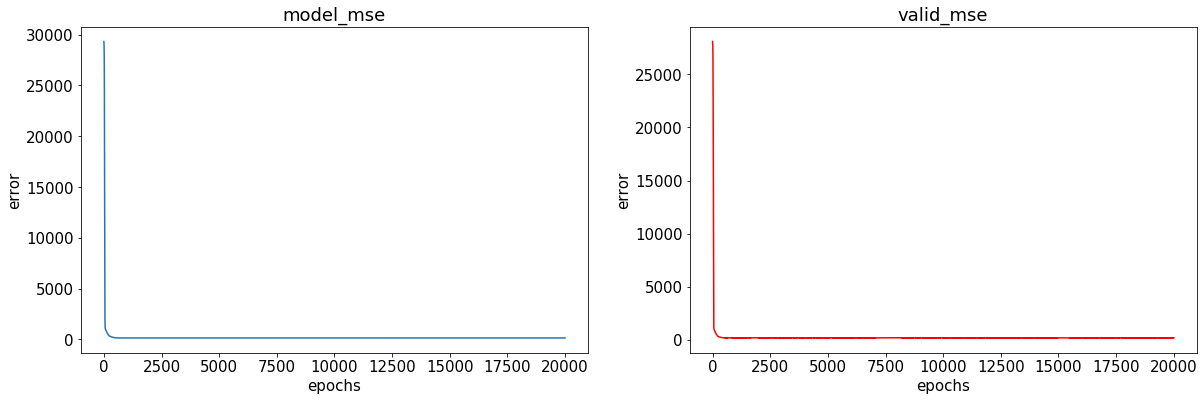

In [70]:
    plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(20, 6))

model_mse = fig.add_subplot(1, 2, 1)
plt.plot(results.history['mean_squared_error'])
model_mse.title.set_text("model_mse")
model_mse.set(xlabel="epochs")
model_mse.set(Ylabel="error")

valid_mse = fig.add_subplot(1, 2, 2)
plt.plot(results.history['val_mean_squared_error'], color="r")
valid_mse.title.set_text("valid_mse")
valid_mse.set(xlabel="epochs")
valid_mse.set(Ylabel="error")

plt.show()

I'll load the saved "best" model to see how good it is. I'm setting the "compile" hyperparameter to false becasue I don't need to do any training of the model, just testing of how well it works. This prevents an error.

In [72]:
model = keras.models.load_model("./Models/proj_7_best_model.h5", compile=False)

prediction = model.predict(test_features)
error = sklearn.metrics.mean_squared_error(prediction, test_labels)
print(error)

139.89907937953248


All right, so it looks like my error is around 110 most of the time. While it's not great, I can expect an answer within +/- 10cm of the truth when estimating height.